In [1]:
suppressPackageStartupMessages(library(rstanarm))
suppressPackageStartupMessages(library(ggformula))
library(tibble)
suppressPackageStartupMessages(library(glue))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(modelr))
library(stringr)
library(tidyr)
library(forcats)
suppressPackageStartupMessages(library(bayesplot))

In [2]:
# Set the maximum number of columns and rows to display
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)
# Set the default plot size
options(repr.plot.width=18, repr.plot.height=12)

In [3]:
download_if_missing <- function(filename, url) {
    if (!file.exists(filename)) {
        dir.create(dirname(filename), showWarnings=FALSE, recursive=TRUE)
        download.file(url, destfile = filename, method="curl")
    }
}

# Fitting logistic regression to data

The folder [NES](https://github.com/avehtari/ROS-Examples/tree/master/NES/) contains sthe survey data of presidential preference and income for the 1992 election analyzed in Section 13.1, along with other variables including sex, ethnicity, education, party identification, and political ideology.

### Load the data

A trick: read the DTA file because the txt file drops all the factors!

To get more information, this looks like an extract from the  [time series data](https://electionstudies.org/data-center/anes-time-series-cumulative-data-file/) which has a useful [codebook](https://electionstudies.org/wp-content/uploads/2018/12/anes_timeseries_cdf_codebook_var.pdf).

Here are some I mapped out before I realised this:

* resid: Likely some sort of respondent_id (VCF0006 or VCF0006a), only useful for longitudinal studies
* weight1-3: Some of the demographic weightings (who knows which ones or how they were calculated?)
* age: Self-explanatory, likely VCF0101
* gender: Likely VCF0104 . 1 = Male, 2 = Female (Other introduced in 2016, 0 is NA)
* race: Given there are 5 categories in the data likely VCF0105a (which has 6 categories in 1992). 1. White non-Hispanic, 2. Black non-Hispanic, 3. Asian or Pacific Islander, non-Hispanic, 4. American Indian or Alaska Native non-Hispanic, 5. Hispanic, 6. Other or multiple races, non-Hispanic
* educ1: Perhaps VCF0110 
* urban: VCF0111
* region: VCF0112
* income: VCF0114 (no data in 96th-100th percentile of income seems reasonable)
* occup1: VCF0115 We will replace NA with other (not a home maker, armed service, etc.)
* union: VCF0127 - "Do you or anyone else in this household belong to a labor union?"
* religion: VCF0128
* educ2: VCF0140 - "What is the highest degree you have earned?"
* educ3: VCF0140a - "What is the highest degree that you have earned?", this is compatible with educ2 being VCF0140 (doing a joint count) so this seems highly likely
* martial_status: VCF0147 - Respondent Marital Status "Are you married now and living with your husband/wife?". Note the typo: martial instead of marital...
* occup2: VCF0151 (how is this different from occupation??)
* fips_cty: I guess a [FIPS code](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt)
* partyid7: VCF0301
* partyid3: VCF0303

In [4]:
filename <- 'data/nes/nes5200_processed_voters_realideo.dta'

download_if_missing(filename, 'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/NES/data/nes5200_processed_voters_realideo.dta')

nes <- foreign::read.dta(filename)

Filter to dta from 1992

In [5]:
nes92_raw <- 
nes %>%
filter(year == 1992)

In [6]:
nes92_raw %>% head()

year resid weight1 weight2 weight3 age gender    race              
32093 1992 1     1       1       1       41  2. female 4. native american
32094 1992 2     1       1       1       83  2. female 1. white          
32095 1992 3     1       1       1       37  2. female 1. white          
32096 1992 4     1       1       1       67  2. female 2. black          
32097 1992 6     1       1       1       28  1. male   1. white          
32098 1992 8     1       1       1       71  2. female 4. native american
      educ1                                   
32093 2. high school (12 grades or fewer, incl
32094 3. some college(13 grades or more,but no
32095 2. high school (12 grades or fewer, incl
32096 2. high school (12 grades or fewer, incl
32097 4. college or advanced degree (no cases 
32098 2. high school (12 grades or fewer, incl
      urban                                   
32093 2. suburban areas                       
32094 3. rural, small towns, outlying and adja
32095 1. central cities                       
32096 1. central cities                       
32097 2. suburban areas                       
32098 2. suburban areas                       
      region                                   income                
32093 2. north central(il,in,ia,ks,mi,mn,mo,ne 4. 68 to 95 percentile
32094 3. south (al,ar,de,d.c.,fl,ga,ky,la,md,m 2. 17 to 33 percentile
32095 3. south (al,ar,de,d.c.,fl,ga,ky,la,md,m 3. 34 to 67 percentile
32096 2. north central(il,in,ia,ks,mi,mn,mo,ne 1. 0 to 16 percentile 
32097 3. south (al,ar,de,d.c.,fl,ga,ky,la,md,m 2. 17 to 33 percentile
32098 2. north central(il,in,ia,ks,mi,mn,mo,ne 3. 34 to 67 percentile
      occup1                                  
32093 2. clerical and sales workers           
32094 6. homemkrs(1972-92:7 in vcf0116,4 in vc
32095 3. skilled, semi-skilled and service wor
32096 3. skilled, semi-skilled and service wor
32097 1. professional and managerial          
32098 6. homemkrs(1972-92:7 in vcf0116,4 in vc
      union                                    religion     
32093 2. no, no one in the household belongs t 1. protestant
32094 2. no, no one in the household belongs t 1. protestant
32095 2. no, no one in the household belongs t 1. protestant
32096 2. no, no one in the household belongs t 1. protestant
32097 2. no, no one in the household belongs t 1. protestant
32098 2. no, no one in the household belongs t 1. protestant
      educ2                                   
32093 3. 12 grades, diploma or equivalency    
32094 5. some college, no degree/ junior/commu
32095 3. 12 grades, diploma or equivalency    
32096 2. 9-12 grades ('high school'), no diplo
32097 6. ba level degrees/ advanced degrees in
32098 3. 12 grades, diploma or equivalency    
      educ3                                   
32093 3. 12 grades, diploma or equivalency    
32094 5. some college, no degree/ junior/commu
32095 3. 12 grades, diploma or equivalency    
32096 2. 9-12 grades ('high school'), no diplo
32097 6. ba level degree                      
32098 3. 12 grades, diploma or equivalency    
      martial_status                          
32093 1. married and living with spouse (or sp
32094 5. widowed                              
32095 1. married and living with spouse (or sp
32096 5. widowed                              
32097 3. divorced                             
32098 1. married and living with spouse (or sp
      occup2                                   icpsr_cty fips_cty
32093 2. clerical and sales workers            NA        29095   
32094 6. homemakers (1980-later: no other occu NA        13031   
32095 3. skilled, semi-skilled and service wor NA        12105   
32096 3. skilled, semi-skilled and service wor NA        39113   
32097 1. professional and managerial           NA        13135   
32098 6. homemakers (1980-later: no other occu NA        29095   
      partyid7                   partyid3                          
32093 7. strong republican       3. republicans (including leaners)

In [7]:
nes92_raw %>% count(gender)

gender    n   
1 1. male    904
2 2. female 1043

Engineer the features a little.

In [8]:
nes92_raw %>% summarise(n(), n_distinct(resid))

n()  n_distinct(resid)
1 1947 1947

Of the 3 education variable educ3 is the most granular, best to start off with that and rollup as needed.

In [9]:
nes92_raw %>% count(educ1, educ2, educ3)

educ1                                   
1 1. grade school of less (0-8 grades)    
2 2. high school (12 grades or fewer, incl
3 2. high school (12 grades or fewer, incl
4 3. some college(13 grades or more,but no
5 4. college or advanced degree (no cases 
6 4. college or advanced degree (no cases 
7 NA                                      
  educ2                                   
1 1. 8 grades or less ('grade school')    
2 2. 9-12 grades ('high school'), no diplo
3 3. 12 grades, diploma or equivalency    
4 5. some college, no degree/ junior/commu
5 6. ba level degrees/ advanced degrees in
6 6. ba level degrees/ advanced degrees in
7 NA                                      
  educ3                                    n  
1 1. 8 grades or less ('grade school')     147
2 2. 9-12 grades ('high school'), no diplo 171
3 3. 12 grades, diploma or equivalency     608
4 5. some college, no degree/ junior/commu 452
5 6. ba level degree                       345
6 7. advanced degrees incl. llb            172
7 NA                                        52

occup1 is VCF0115, replaced by occup2 VCF0151 which has more information (see codebook)

Use occup2 instead

In [10]:
nes92_raw %>% count(occup1, occup2)

occup1                                  
1  1. professional and managerial          
2  2. clerical and sales workers           
3  3. skilled, semi-skilled and service wor
4  4. laborers, except farm                
5  5. farmers,farm managers,farm laborers &
6  6. homemkrs(1972-92:7 in vcf0116,4 in vc
7  6. homemkrs(1972-92:7 in vcf0116,4 in vc
8  6. homemkrs(1972-92:7 in vcf0116,4 in vc
9  6. homemkrs(1972-92:7 in vcf0116,4 in vc
10 6. homemkrs(1972-92:7 in vcf0116,4 in vc
11 6. homemkrs(1972-92:7 in vcf0116,4 in vc
12 NA                                      
13 NA                                      
14 NA                                      
15 NA                                      
16 NA                                      
17 NA                                      
   occup2                                   n  
1  1. professional and managerial           578
2  2. clerical and sales workers            399
3  3. skilled, semi-skilled and service wor 597
4  4. laborers, except farm                  42
5  5. farmers, farm managers, farm laborers  63
6  1. professional and managerial             8
7  2. clerical and sales workers              8
8  3. skilled, semi-skilled and service wor  10
9  4. laborers, except farm                   1
10 5. farmers, farm managers, farm laborers   2
11 6. homemakers (1980-later: no other occu 156
12 1. professional and managerial             9
13 2. clerical and sales workers             14
14 3. skilled, semi-skilled and service wor   6
15 4. laborers, except farm                   2
16 5. farmers, farm managers, farm laborers   1
17 NA                                        51

There's a few equivalent encodings here, I think it makes sense to use partyid3_b x str_partyid

In [11]:
nes92_raw %>% count(partyid7, partyid3, partyid3_b, str_partyid)

partyid7                   partyid3                          
1 1. strong democrat         1. democrats (including leaners)  
2 2. weak democrat           1. democrats (including leaners)  
3 3. independent-democrat    1. democrats (including leaners)  
4 4. independent-independent 2. independents                   
5 5. independent-republican  3. republicans (including leaners)
6 6. weak republican         3. republicans (including leaners)
7 7. strong republican       3. republicans (including leaners)
8 NA                         9. apolitical (1966 only: and dk) 
9 NA                         NA                                
  partyid3_b                               str_partyid                  n  
1 1. democrats (including leaners)         4. strong partisan           410
2 1. democrats (including leaners)         3. weak partisan             354
3 1. democrats (including leaners)         2. leaning independent       260
4 2. indpendents and apolitical (1966 only 1. independent or apolitical 171
5 3. republicans (including leaners)       2. leaning independent       221
6 3. republicans (including leaners)       3. weak partisan             273
7 3. republicans (including leaners)       4. strong partisan           248
8 2. indpendents and apolitical (1966 only 1. independent or apolitical   4
9 NA                                       NA                             6

We're only interested in people who actually voted for one of the 2 primary parties, so we will restrict to those (presvote_2party).

In [12]:
nes92_raw %>% count(vote,regisvote,presvote,presvote_2party)

vote                regisvote                        
1 1. no, did not vote 1. not registed, and did not vote
2 1. no, did not vote 2. registered, but did not vote  
3 2. yes, voted       3. voted (registered)            
4 2. yes, voted       3. voted (registered)            
5 2. yes, voted       3. voted (registered)            
6 2. yes, voted       3. voted (registered)            
7 NA                  NA                               
  presvote                                 presvote_2party n  
1 NA                                       NA              127
2 NA                                       NA              111
3 1. democrat                              1. democrat     765
4 2. republican                            2. republican   539
5 3. major third party cand (wallace 1968/ NA              194
6 NA                                       NA               34
7 NA                                       NA              177

In [13]:
nes92_raw %>% count(ideo, ideo7)

ideo                               ideo7                           n  
1  1. liberal                         1. extremely liberal             40
2  1. liberal                         2. liberal                      272
3  1. liberal                         3. slightly liberal             195
4  1. liberal                         4. moderate, middle of the road 154
5  3. moderate ('middle of the road') 4. moderate, middle of the road 148
6  5. conservative                    4. moderate, middle of the road 205
7  5. conservative                    5. slightly conservative        296
8  5. conservative                    6. conservative                 460
9  5. conservative                    7. extremely conservative        54
10 NA                                 NA                              123

In [14]:
nes92_pre <- nes92_raw %>%
# Only people who actually voted republican or democrat
filter(!is.na(presvote_2party)) %>%
transmute(#year is 1992,
          #resid: Respondent id - only useful for longitudinal, all distinct
          # weight1,..3: Demographic weights? Not useful
    age= age,
    gender=gender,
    race=race,
    # educ1, use educ3 instead
    urban=urban,
    region=region,
    income=income,
    # occup1 is VCF0115, replaced by occup2 VCF0151 which has more information (see codebook)
    union=union,
    religion=religion,
    education=educ3,
    marital_status = martial_status, # Note the Freudian slip
    occupation = occup2,
    # icpsr_cty - is NA
    #fips_cty,   - interesting, but need to join to external data sources to make useful
    # partyid7 - is just partyid3_b x str_partyid
    # partyid3 just separates out independent from unknown, few differences in 1992
    party = partyid3_b,
    partisan = str_partyid,
    father_party,
    mother_party,
    dlikes,
    rlikes,
    dem_therm,
    rep_therm,
    #regis - NA
    rvote = presvote_2party == '2. republican',
    ideology = ideo7, # ideo is just a summary
    ## There are some more columns, but enough for now
)
    
          

nes92_pre %>% head()

age gender    race               urban                                   
32093 41  2. female 4. native american 2. suburban areas                       
32094 83  2. female 1. white           3. rural, small towns, outlying and adja
32096 67  2. female 2. black           1. central cities                       
32097 28  1. male   1. white           2. suburban areas                       
32098 71  2. female 4. native american 2. suburban areas                       
32099 53  2. female 1. white           2. suburban areas                       
      region                                   income                
32093 2. north central(il,in,ia,ks,mi,mn,mo,ne 4. 68 to 95 percentile
32094 3. south (al,ar,de,d.c.,fl,ga,ky,la,md,m 2. 17 to 33 percentile
32096 2. north central(il,in,ia,ks,mi,mn,mo,ne 1. 0 to 16 percentile 
32097 3. south (al,ar,de,d.c.,fl,ga,ky,la,md,m 2. 17 to 33 percentile
32098 2. north central(il,in,ia,ks,mi,mn,mo,ne 3. 34 to 67 percentile
32099 2. north central(il,in,ia,ks,mi,mn,mo,ne 4. 68 to 95 percentile
      union                                    religion     
32093 2. no, no one in the household belongs t 1. protestant
32094 2. no, no one in the household belongs t 1. protestant
32096 2. no, no one in the household belongs t 1. protestant
32097 2. no, no one in the household belongs t 1. protestant
32098 2. no, no one in the household belongs t 1. protestant
32099 2. no, no one in the household belongs t 1. protestant
      education                               
32093 3. 12 grades, diploma or equivalency    
32094 5. some college, no degree/ junior/commu
32096 2. 9-12 grades ('high school'), no diplo
32097 6. ba level degree                      
32098 3. 12 grades, diploma or equivalency    
32099 5. some college, no degree/ junior/commu
      marital_status                          
32093 1. married and living with spouse (or sp
32094 5. widowed                              
32096 5. widowed                              
32097 3. divorced                             
32098 1. married and living with spouse (or sp
32099 4. separated                            
      occupation                              
32093 2. clerical and sales workers           
32094 6. homemakers (1980-later: no other occu
32096 3. skilled, semi-skilled and service wor
32097 1. professional and managerial          
32098 6. homemakers (1980-later: no other occu
32099 1. professional and managerial          
      party                                    partisan                    
32093 3. republicans (including leaners)       4. strong partisan          
32094 3. republicans (including leaners)       2. leaning independent      
32096 1. democrats (including leaners)         4. strong partisan          
32097 3. republicans (including leaners)       2. leaning independent      
32098 2. indpendents and apolitical (1966 only 1. independent or apolitical
32099 1. democrats (including leaners)         4. strong partisan          
      father_party  mother_party  dlikes rlikes dem_therm rep_therm rvote
32093 3. republican 3. republican -4     -2      0        97         TRUE
32094 1. democrat   1. democrat   -1      4     50        85         TRUE
32096 1. democrat   1. democrat    5     -5     85        40        FALSE
32097 1. democrat   1. democrat    0     -1     60        85         TRUE
32098 NA            NA             5     -5     85        30        FALSE
32099 3. republican 3. republican  4     -1     97        40        FALSE
      ideology                       
32093 5. slightly conservative       
32094 5. slightly conservative       
32096 4. moderate, middle of the road
32097 3. slightly liberal            
32098 2. liberal                     
32099 1. extremely liberal

In [15]:
nes92_pre %>% nrow()

[1] 1304

In [16]:
nes92_pre %>% count(rvote)

rvote n  
1 FALSE 765
2  TRUE 539

## Fit logistic regression models

Fit a logistic regression predicting support for Bush given all these inputs.
Consider how to include these as regression predictors and also consider possible interactions.

### Preprocessing - dealing with missing values

There's more discussion about imputation later, for now let's do the dumb thing and just drop all missing values.

Note this has pretty severe impact on how we evaluate the model, since we're throwing away unusual data that could be highly informative.

The biggest missing values are mother_party and father_party followed by income and ideology.

Since we've been explicitly asked to use income and ideology let's keep everything below them.

In [17]:
nes92_pre %>% 
mutate_all(is.na) %>% 
summarise_all(mean) %>% 
tidyr::pivot_longer(everything(), values_to="missing") %>%
arrange(desc(missing)) %>%
mutate(missing=scales::percent(missing, accuracy=0.1)) %>%
t()

[,1]         [,2]         [,3]   [,4]     [,5]      [,6]      
name    father_party mother_party income ideology education occupation
missing 15.3%        14.7%        6.3%   4.8%     2.5%      2.1%      
        [,7]      [,8] [,9]      [,10] [,11]    [,12]          [,13] [,14]   
name    dem_therm race rep_therm union religion marital_status party partisan
missing 1.2%      1.2% 0.5%      0.5%  0.3%     0.2%           0.2%  0.2%    
        [,15] [,16]  [,17] [,18]  [,19]  [,20]  [,21]
name    age   gender urban region dlikes rlikes rvote
missing 0.0%  0.0%   0.0%  0.0%   0.0%   0.0%   0.0%

In [18]:
nes92 <-
nes92_pre %>%
select(-father_party, -mother_party) %>%
filter_all(~!is.na(.))

Dropped 16% of the data

In [19]:
1 - nrow(nes92) / nrow(nes92_pre)

[1] 0.1641104

### Income

Income is an ordered catagorical variable so there's a few ways we could treat it for modelling

In [20]:
nes92 %>% count(income)

income                  n  
1 1. 0 to 16 percentile   109
2 2. 17 to 33 percentile  183
3 3. 34 to 67 percentile  336
4 4. 68 to 95 percentile  390
5 5. 96 to 100 percentile  72

A simple way to model this is to look at the percentage for each category and the change between them.

In [21]:
nes92 %>% 
group_by(income) %>% 
summarise(rvote=mean(rvote), se=sqrt(rvote * (1-rvote)/n())) %>%
mutate(logit_rvote = logit(rvote),
       logit_change = logit_rvote - lag(logit_rvote))

income                  rvote     se         logit_rvote logit_change
1 1. 0 to 16 percentile   0.2293578 0.04026891 -1.21194097         NA  
2 2. 17 to 33 percentile  0.3387978 0.03498742 -0.66865616 0.54328481  
3 3. 34 to 67 percentile  0.3988095 0.02671278 -0.41042790 0.25822826  
4 4. 68 to 95 percentile  0.4871795 0.02531016 -0.05129329 0.35913460  
5 5. 96 to 100 percentile 0.5000000 0.05892557  0.00000000 0.05129329

Note it starts at 2?

In [22]:
nes92 %>% count(as.integer(income))

as.integer(income) n  
1 2                  109
2 3                  183
3 4                  336
4 5                  390
5 6                   72

In [23]:
nes92 <- nes92 %>%
mutate(income_int = as.integer(income) - 1)

nes92 %>% count(income, income_int)

income                  income_int n  
1 1. 0 to 16 percentile   1          109
2 2. 17 to 33 percentile  2          183
3 3. 34 to 67 percentile  3          336
4 4. 68 to 95 percentile  4          390
5 5. 96 to 100 percentile 5           72

As an integer we get something very close to the text

In [24]:
(fit_nes_income_cts <- stan_glm(rvote ~ income_int, family=binomial(link="logit"), data=nes92, refresh=0))

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ income_int
 observations: 1090
 predictors:   2
------
            Median MAD_SD
(Intercept) -1.4    0.2  
income_int   0.3    0.1  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

Another approach is to map each to it's quantile midpoint (noting it's much higher in the last 2 categories)

In [25]:
nes_income_percentiles <- c((0+16)/200, (17+33)/200, (34+67)/200, (68+95)/200, (96+100)/200)

nes92 <- nes92 %>%
mutate(income_percentile = nes_income_percentiles[income_int])

nes92 %>% count(income, income_percentile)

income                  income_percentile n  
1 1. 0 to 16 percentile   0.080             109
2 2. 17 to 33 percentile  0.250             183
3 3. 34 to 67 percentile  0.505             336
4 4. 68 to 95 percentile  0.815             390
5 5. 96 to 100 percentile 0.980              72

In [26]:
(fit_nes_income_pctile <- stan_glm(rvote ~ income_percentile, family=binomial(link="logit"), data=nes92, refresh=0))

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ income_percentile
 observations: 1090
 predictors:   2
------
                  Median MAD_SD
(Intercept)       -1.1    0.1  
income_percentile  1.2    0.2  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

We could treat it as an unordered factor with 5 (or less?) levels

In [27]:
(fit_nes_income_factor <- stan_glm(rvote ~ income, family=binomial(link="logit"), data=nes92, refresh=0))

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ income
 observations: 1090
 predictors:   5
------
                              Median MAD_SD
(Intercept)                   -1.2    0.2  
income2. 17 to 33 percentile   0.5    0.3  
income3. 34 to 67 percentile   0.8    0.3  
income4. 68 to 95 percentile   1.2    0.2  
income5. 96 to 100 percentile  1.2    0.3  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

We could treat it as an ordered factor, which Stan GLM does some interesting things for.

In [28]:
(fit_nes_income_ordered <- stan_glm(rvote ~ as.ordered(income), family=binomial(link="logit"), data=nes92, refresh=0))

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ as.ordered(income)
 observations: 1090
 predictors:   5
------
                     Median MAD_SD
(Intercept)          -0.5    0.1  
as.ordered(income).L  1.0    0.2  
as.ordered(income).Q -0.2    0.2  
as.ordered(income).C  0.0    0.2  
as.ordered(income)^4 -0.1    0.1  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

Let's compare the models

In [29]:
models <- list(income_cts=fit_nes_income_cts, income_percentile=fit_nes_income_pctile, income_factor=fit_nes_income_factor, income_ordered=fit_nes_income_ordered)

In [30]:
models_loo <- purrr::map(models, loo)

It seems fitting as a factor slightly overfits, and the continuous approach in the book seems as good as any.

In [31]:
loo_compare(models_loo)

elpd_diff   se_diff   elpd_loo  se_elpd_loo p_loo   
income_cts         0.00000000 0.0000000 -724.8330 7.847071    2.008925
income_percentile -0.09054805 0.6901354 -724.9236 7.831767    1.989455
income_ordered    -2.22566637 1.3770796 -727.0587 8.034998    5.124397
income_factor     -2.30872276 1.3687663 -727.1417 8.056292    5.206811
                  se_p_loo   looic    se_looic
income_cts        0.05954844 1449.666 15.69414
income_percentile 0.04998964 1449.847 15.66353
income_ordered    0.18421358 1454.117 16.07000
income_factor     0.17663794 1454.283 16.11258

Plotting it like in the book

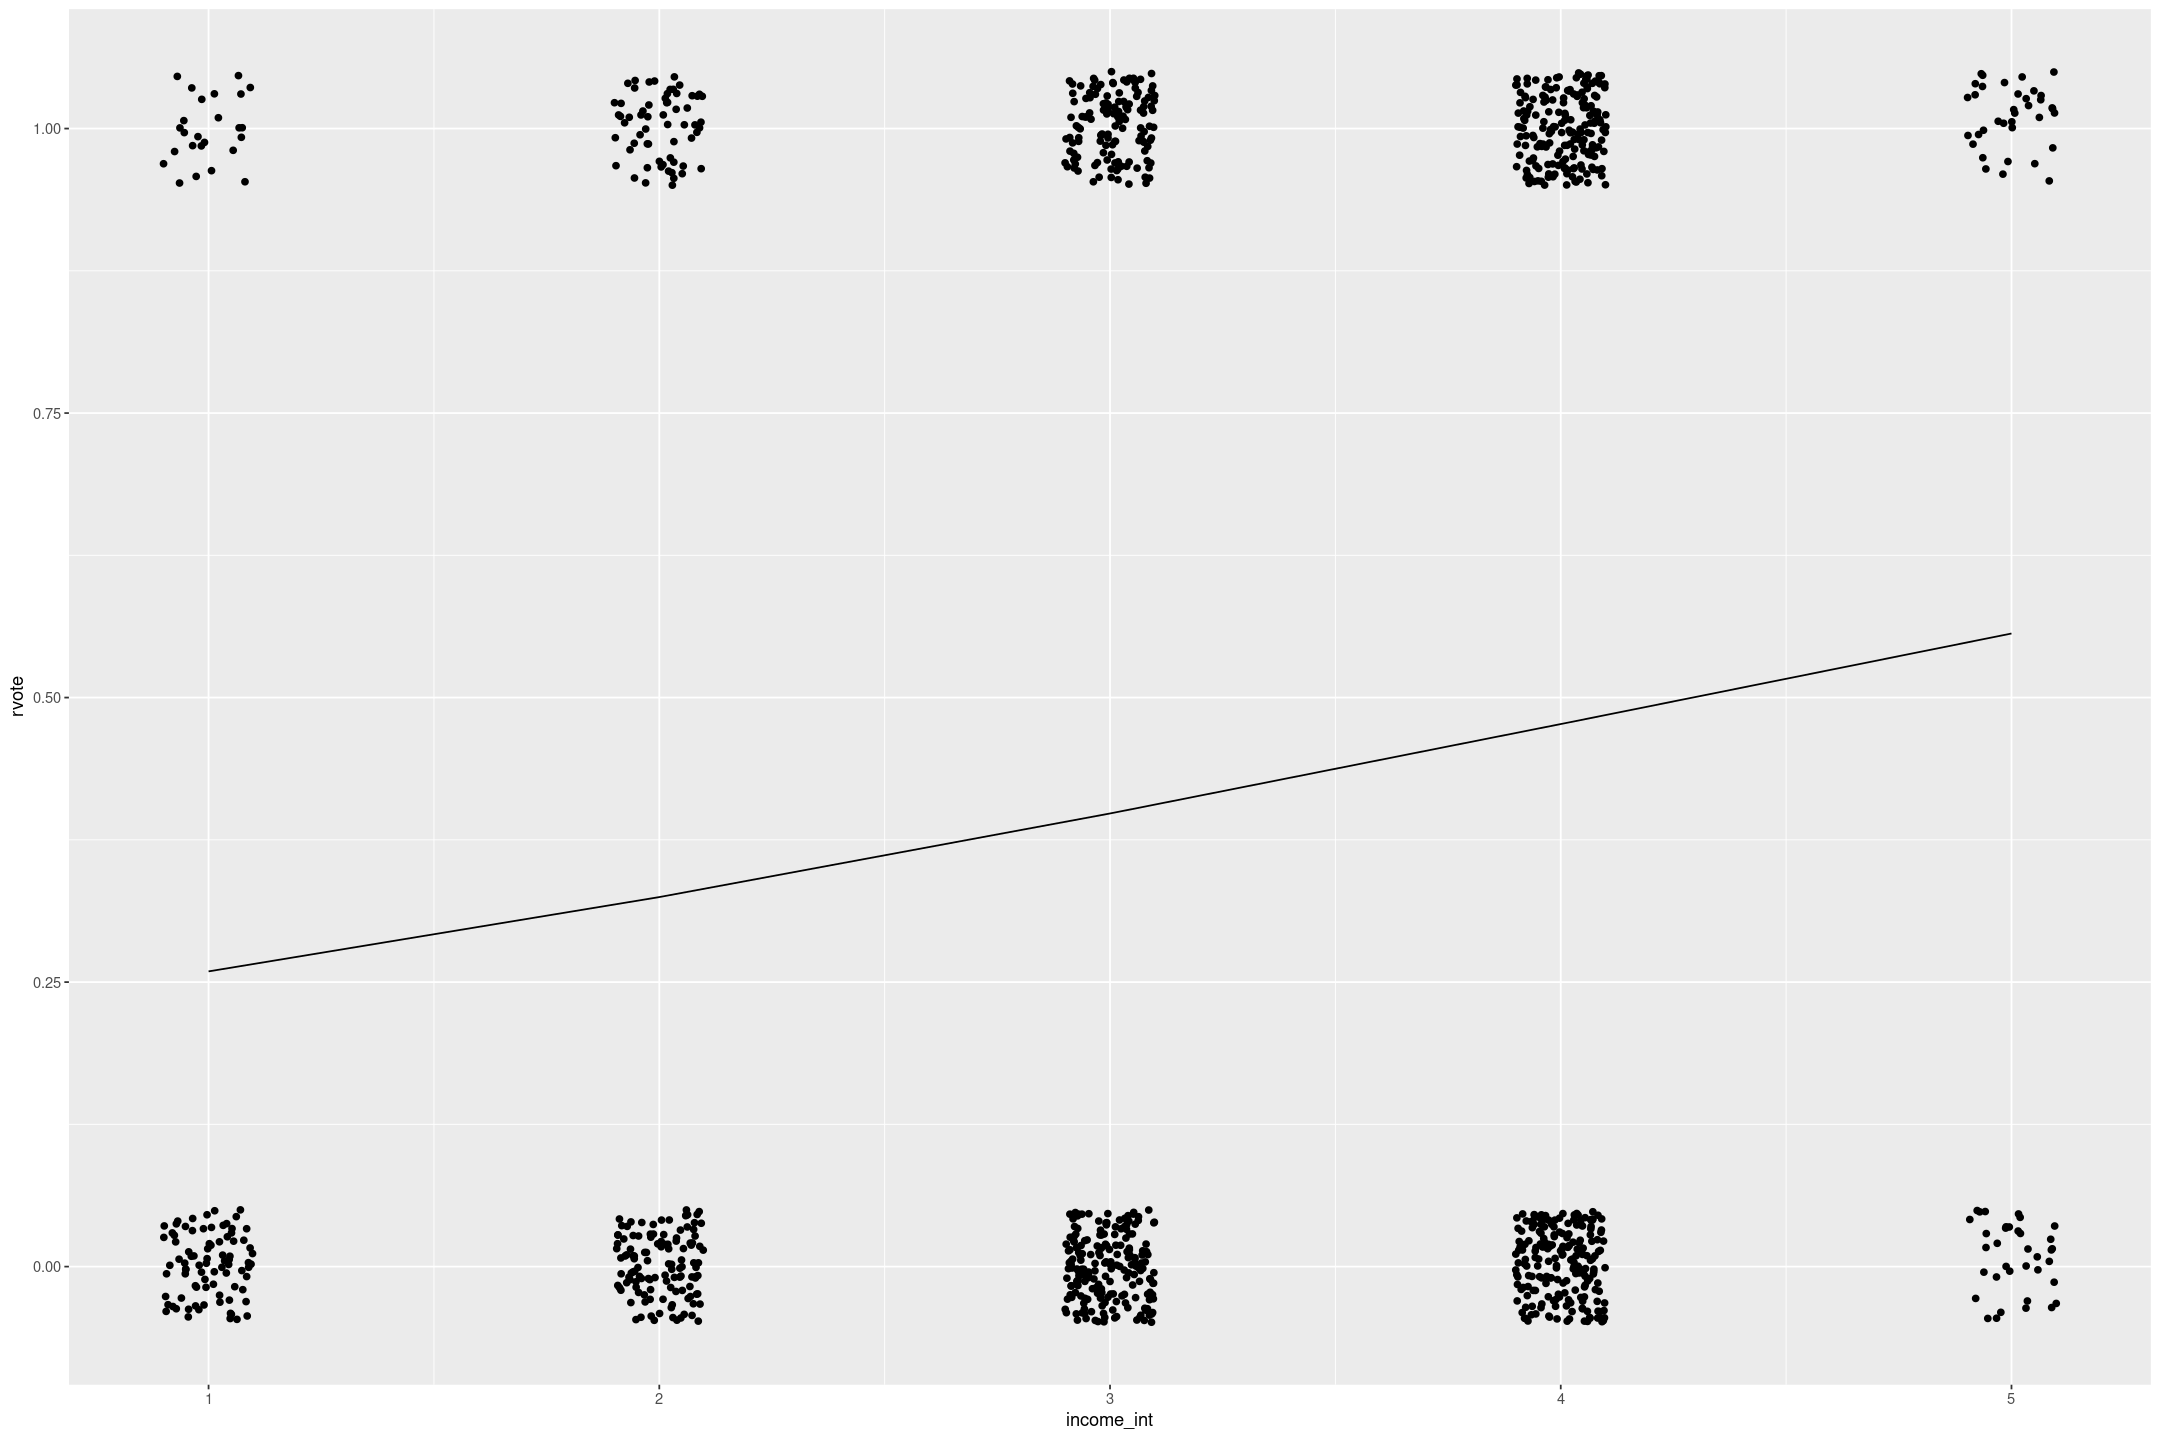

In [32]:
nes92 %>%
mutate(prob = predict(fit_nes_income_cts, newdata=., type="response")) %>%
mutate(rvote = as.integer(rvote)) %>%
gf_jitter(rvote ~ income_int, width=0.1, height=0.05) %>%
gf_line(prob ~ income_int)

### Impact of age

To get an idea of the shape of it we can plot the average percentage that vote republican by age.

Conservatism raises with age but there's an interesting dip around 40 (generation gap?)

It would be interesting to see what a tree model did to this.

In [33]:
nes92 %>%
group_by(age) %>%
summarise(rvote=mean(rvote), se=sqrt(rvote * (1-rvote)/ n())) %>%
gf_point(rvote ~ age) %>%
gf_errorbar(ymin=~rvote-se, ymax=~rvote+se) +
scale_x_continuous(breaks=seq(20, 100, by=10), minor_breaks=seq(18, 100, by=2))

By grouping things up we can get a more reliable, but less granular signal

In [34]:
nes92 %>%
group_by(age5 = 5*(age %/% 5)) %>%
summarise(p = mean(rvote), se = sqrt(p * (1-p) / n())) %>%
gf_point(p ~ age5) %>%
gf_errorbar(ymin=~p-se, ymax=~p+se)

Using a 2-year rolling window makes this clearer, but also overfits to noise (you have to look 3 ages across to remove the incfluence of 1 age point).

In [35]:
nes92 %>%
group_by(age) %>%
summarise(n=n(), rvote=sum(rvote)) %>%
arrange(age) %>%
# To do this right we should fill in 0's for missing ages in the range
# Here it only happens for the last data point, so I don't worry about it
mutate(n_roll = n + lag(n) + lag(n,2), 
       p = (rvote + lag(rvote) + lag(rvote,2))/n_roll,
       se = sqrt(p * (1-p) / n_roll)) %>%
gf_point(p ~ age) %>%
gf_errorbar(ymin=~p-se, ymax=~p+se) +
scale_x_continuous(breaks=seq(20, 100, by=10), minor_breaks=seq(18, 100, by=2))

Warning message:
“Removed 2 rows containing missing values (geom_point).”


In [36]:
nes92 %>% count(age) %>% filter(age - lag(age) != 1)

age n
1 91  1

There's a few ways we could address this.

Let's start with a linear model

In [37]:
nes92 <- nes92 %>% mutate(age10 = age/10, age10sq = age10^2)

In [38]:
fit_nes_age_linear <- stan_glm(rvote ~ age10, family=binomial(link="logit"), data=nes92, refresh=0)
print(fit_nes_age_linear, digits=2)

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ age10
 observations: 1090
 predictors:   2
------
            Median MAD_SD
(Intercept) -0.33   0.18 
age10       -0.01   0.04 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


And a quadratic model

In [39]:
fit_nes_age_quadratic <- stan_glm(rvote ~ age10 + age10sq, family=binomial(link="logit"), data=nes92, refresh=0)
print(fit_nes_age_quadratic, digits=2)

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ age10 + age10sq
 observations: 1090
 predictors:   3
------
            Median MAD_SD
(Intercept) -0.35   0.53 
age10        0.00   0.22 
age10sq      0.00   0.02 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


Another option would be to fit age groups; let's break it roughly into 5 equal size age groups

In [40]:
quantile(nes92$age, seq(0, 1, 0.2))

0%  20%  40%  60%  80% 100% 
18.0 32.0 39.0 49.4 65.0 91.0

In [41]:
nes92 <- nes92 %>%
mutate(age_group = cut(age, c(0, 30, 40, 50, 64, Inf), right=FALSE, labels=c('18-29', '30-39', '40-49', '50-64', '65+')))

In [42]:
nes92 %>% group_by(age_group) %>% summarise(min(age), max(age), n())

age_group min(age) max(age) n()
1 18-29     18       29       145
2 30-39     30       39       294
3 40-49     40       49       215
4 50-64     50       63       198
5 65+       64       91       238

At a glance this captures more signal

In [43]:
fit_nes_age_group <- stan_glm(rvote ~ age_group, family=binomial(link="logit"), data=nes92, refresh=0)
print(fit_nes_age_group, digits=2)

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ age_group
 observations: 1090
 predictors:   5
------
               Median MAD_SD
(Intercept)    -0.61   0.17 
age_group30-39  0.57   0.20 
age_group40-49 -0.01   0.22 
age_group50-64  0.27   0.22 
age_group65+    0.21   0.21 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


The medians are essentially what you get if you calculcate the average by group.

In [44]:
nes_avg_by_age_group <- nes92 %>%
group_by(age_group) %>%
summarise(p=mean(rvote)) %>%
mutate(x=logit(p))

c(intercept=nes_avg_by_age_group$x[1], coef=nes_avg_by_age_group$x[2:nrow(nes_avg_by_age_group)] - nes_avg_by_age_group$x[1])

intercept       coef1       coef2       coef3       coef4 
-0.61146915  0.57064716 -0.01268516  0.26459821  0.20250141

We could also use an ordered factor

In [45]:
fit_nes_age_group_order <- stan_glm(rvote ~ as.ordered(age_group), family=binomial(link="logit"), data=nes92, refresh=0)
print(fit_nes_age_group_order, digits=2)

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ as.ordered(age_group)
 observations: 1090
 predictors:   5
------
                        Median MAD_SD
(Intercept)             -0.41   0.06 
as.ordered(age_group).L  0.03   0.15 
as.ordered(age_group).Q -0.11   0.15 
as.ordered(age_group).C  0.26   0.13 
as.ordered(age_group)^4 -0.38   0.14 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


We can see if we can catch a by year trend as well (but I doubt it)

In [46]:
fit_nes_age_group_cts <- stan_glm(rvote ~ age_group + age, family=binomial(link="logit"), data=nes92, refresh=0)
print(fit_nes_age_group_cts, digits=2)

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ age_group + age
 observations: 1090
 predictors:   6
------
               Median MAD_SD
(Intercept)    -1.05   0.41 
age_group30-39  0.42   0.25 
age_group40-49 -0.34   0.37 
age_group50-64 -0.27   0.52 
age_group65+   -0.64   0.77 
age             0.02   0.02 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


Comparing the models we've built using Leave One Out Cross Validation, the age groups performs the best (ordered or categorical are about the same).

We could take this further and look at different grouping, but this is good enough.

In [47]:
nes_age_models <- list(linear=fit_nes_age_linear, quadratic=fit_nes_age_quadratic, group=fit_nes_age_group, group_cts=fit_nes_age_group_cts, ordered=fit_nes_age_group_order)
nes_age_models_loo <- purrr::map(nes_age_models, loo)
loo_compare(nes_age_models_loo)

elpd_diff  se_diff    elpd_loo  se_elpd_loo p_loo    se_p_loo  
ordered    0.0000000 0.00000000 -736.1484 6.919493    4.939790 0.08297780
group     -0.1892494 0.04446247 -736.3376 6.935324    5.129225 0.08458774
group_cts -0.3326083 1.17132386 -736.4810 7.054823    6.018368 0.10595907
linear    -3.6168132 3.61699474 -739.7652 5.920252    1.972573 0.04221435
quadratic -4.5346156 3.61761637 -740.6830 5.947423    2.881780 0.08843441
          looic    se_looic
ordered   1472.297 13.83899
group     1472.675 13.87065
group_cts 1472.962 14.10965
linear    1479.530 11.84050
quadratic 1481.366 11.89485

### Throwing it all in

Everything in our dataframe except rlikes, dlikes, dem_therm and rep_therm

Renormalise our income_int

In [48]:
nes92 <- nes92 %>% mutate(income_int_std = (income_int - mean(income_int))/(2*sd(income_int)))

In [49]:
fit_nes_all <- stan_glm(rvote ~ income_int_std + gender + race + urban + region + union + religion + education +
                       marital_status + occupation + party + partisan + ideology,
                        family=binomial(link="logit"),
                        data=nes92,
                       refresh=0)

In [50]:
fit_nes_all

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ income_int_std + gender + race + urban + region + union + 
	   religion + education + marital_status + occupation + party + 
	   partisan + ideology
 observations: 1090
 predictors:   42
------
                                                       Median MAD_SD
(Intercept)                                            -6.1    3.5  
income_int_std                                         -0.1    0.3  
gender2. female                                         0.5    0.3  
race2. black                                           -2.0    0.5  
race3. asian                                            0.2    0.9  
race4. native american                                  0.7    0.7  
race5. hispanic                                         0.8    0.5  
urban2. suburban areas                                 -0.1    0.3  
urban3. rural, small towns, outlying and adja          -0.1    0.3  
region2. north central(il,in,ia,ks,mi,mn,mo,ne      

Looking at each piece in isolation the most influential factors are:

* Political party
* Race (black)
* Marital status
* Education
* Ideology
* Religion
* Gender
* Region

Though note many of these will be correlated and so can mask each other.

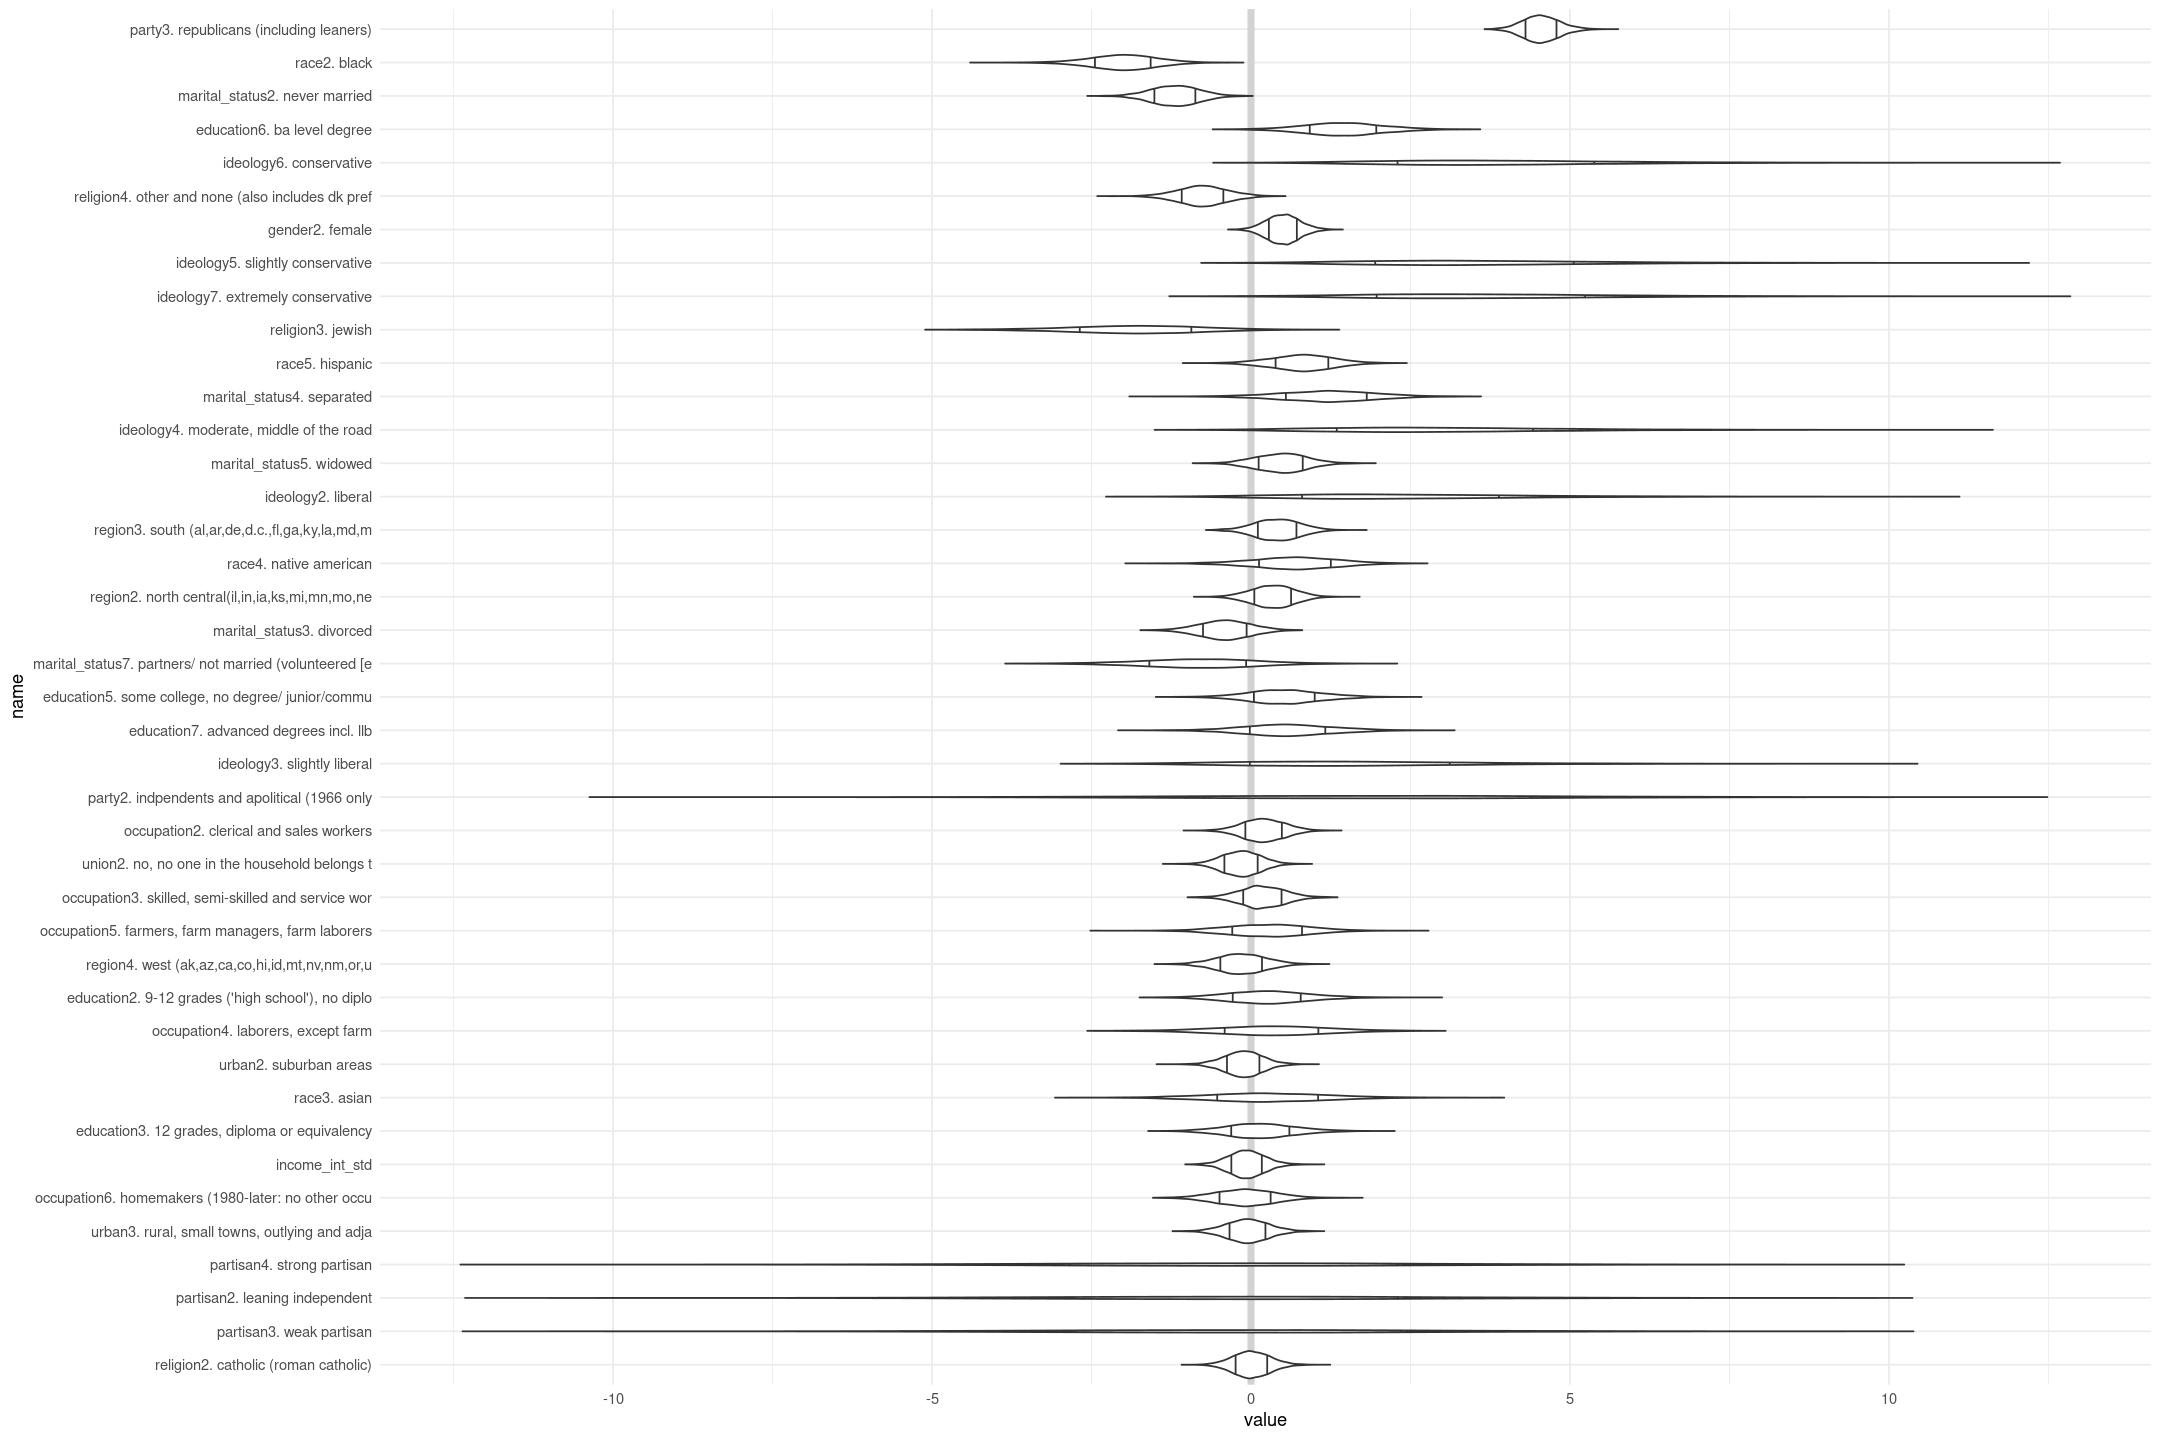

In [51]:
fit_nes_all %>%
as.data.frame() %>%
select(-`(Intercept)`) %>%
pivot_longer(everything()) %>%
mutate(name=forcats::fct_reorder(name, value, function(.) abs(median(.)) / sd(.))) %>%
gf_hline(yintercept=~0, col="lightgrey", size=2) %>%                                 
gf_violin(value ~ name, draw_quantiles=(c(0.2, 0.8)), scale="area") +
coord_flip() +
theme_minimal()

One way to select these would be using a horseshoe prior

### Horseshoe prior

I would *like* to use this but I don't know how to adapt the arguments to a logistic regression

### How to include ideology

In [52]:
nes92 %>% group_by(party) %>% summarise(n=n(), p=mean(rvote))

party                                    n   p         
1 1. democrats (including leaners)         603 0.07960199
2 2. indpendents and apolitical (1966 only  63 0.36507937
3 3. republicans (including leaners)       424 0.88679245

Ideology looks just like a logit!
A continuous encoding is likely to work quite well

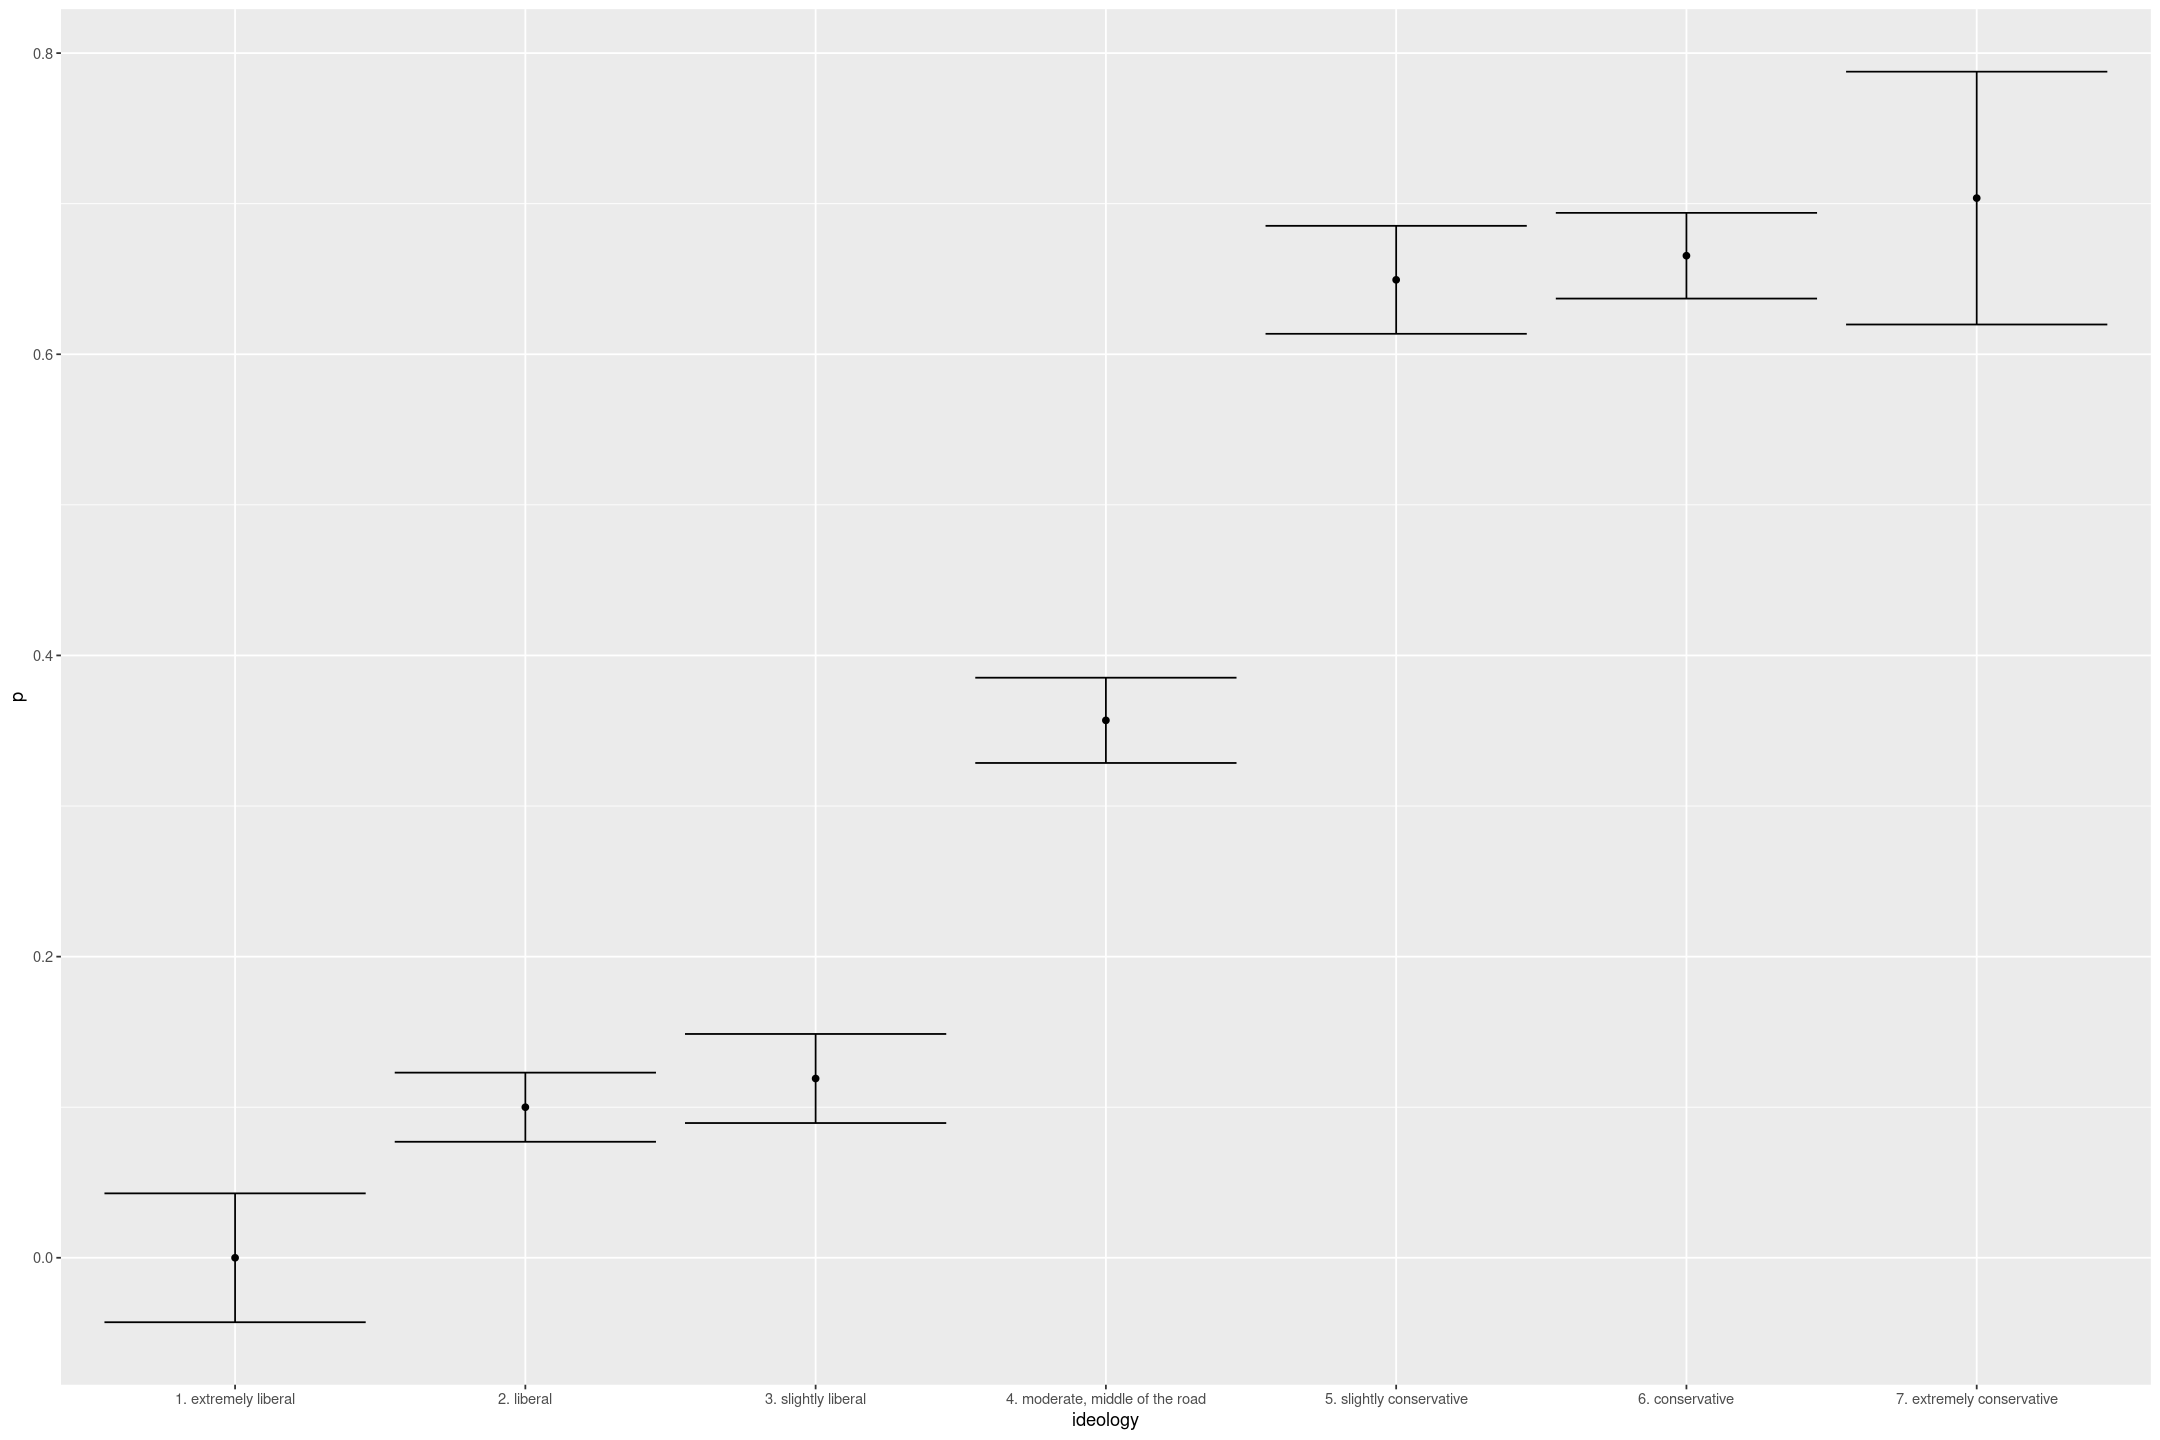

In [53]:
nes92 %>% 
group_by(ideology) %>% 
summarise(n=n(), p=mean(rvote)) %>% 
mutate(phat = (p*n+2)/(n+4), se = sqrt(phat*(1-phat)/(n+4))) %>%
gf_point(p ~ ideology) %>%
gf_errorbar(ymin=~p-se, ymax=~p+se)

In [54]:
(fit_nes_ideology <- stan_glm(rvote ~ ideology, family=binomial(link="logit"), data=nes92, refresh=0))

Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”


stan_glm
 family:       binomial [logit]
 formula:      rvote ~ ideology
 observations: 1090
 predictors:   7
------
                                        Median MAD_SD
(Intercept)                             -4.7    1.5  
ideology2. liberal                       2.5    1.5  
ideology3. slightly liberal              2.6    1.5  
ideology4. moderate, middle of the road  4.1    1.5  
ideology5. slightly conservative         5.3    1.5  
ideology6. conservative                  5.4    1.5  
ideology7. extremely conservative        5.6    1.5  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [55]:
nes92 <- nes92 %>% mutate(ideology_int = (as.numeric(ideology) - 5)/6)
nes92 %>% count(ideology, ideology_int)

ideology                        ideology_int n  
1 1. extremely liberal            -0.5000000    28
2 2. liberal                      -0.3333333   180
3 3. slightly liberal             -0.1666667   126
4 4. moderate, middle of the road  0.0000000   283
5 5. slightly conservative         0.1666667   174
6 6. conservative                  0.3333333   272
7 7. extremely conservative        0.5000000    27

In [56]:
(fit_nes_ideology_cts <- stan_glm(rvote ~ ideology_int, family=binomial(link="logit"), data=nes92, refresh=0))

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ ideology_int
 observations: 1090
 predictors:   2
------
             Median MAD_SD
(Intercept)  -0.7    0.1  
ideology_int  4.6    0.3  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [57]:
df_ideology <- data.frame(ideology_int=seq(-0.5,0.5,by=0.01)) %>% 
mutate(p=predict(fit_nes_ideology_cts, type="response", newdata=.))

It doesn't do quite as well at the extremes - a non-linear transformation of ideology could improve it.

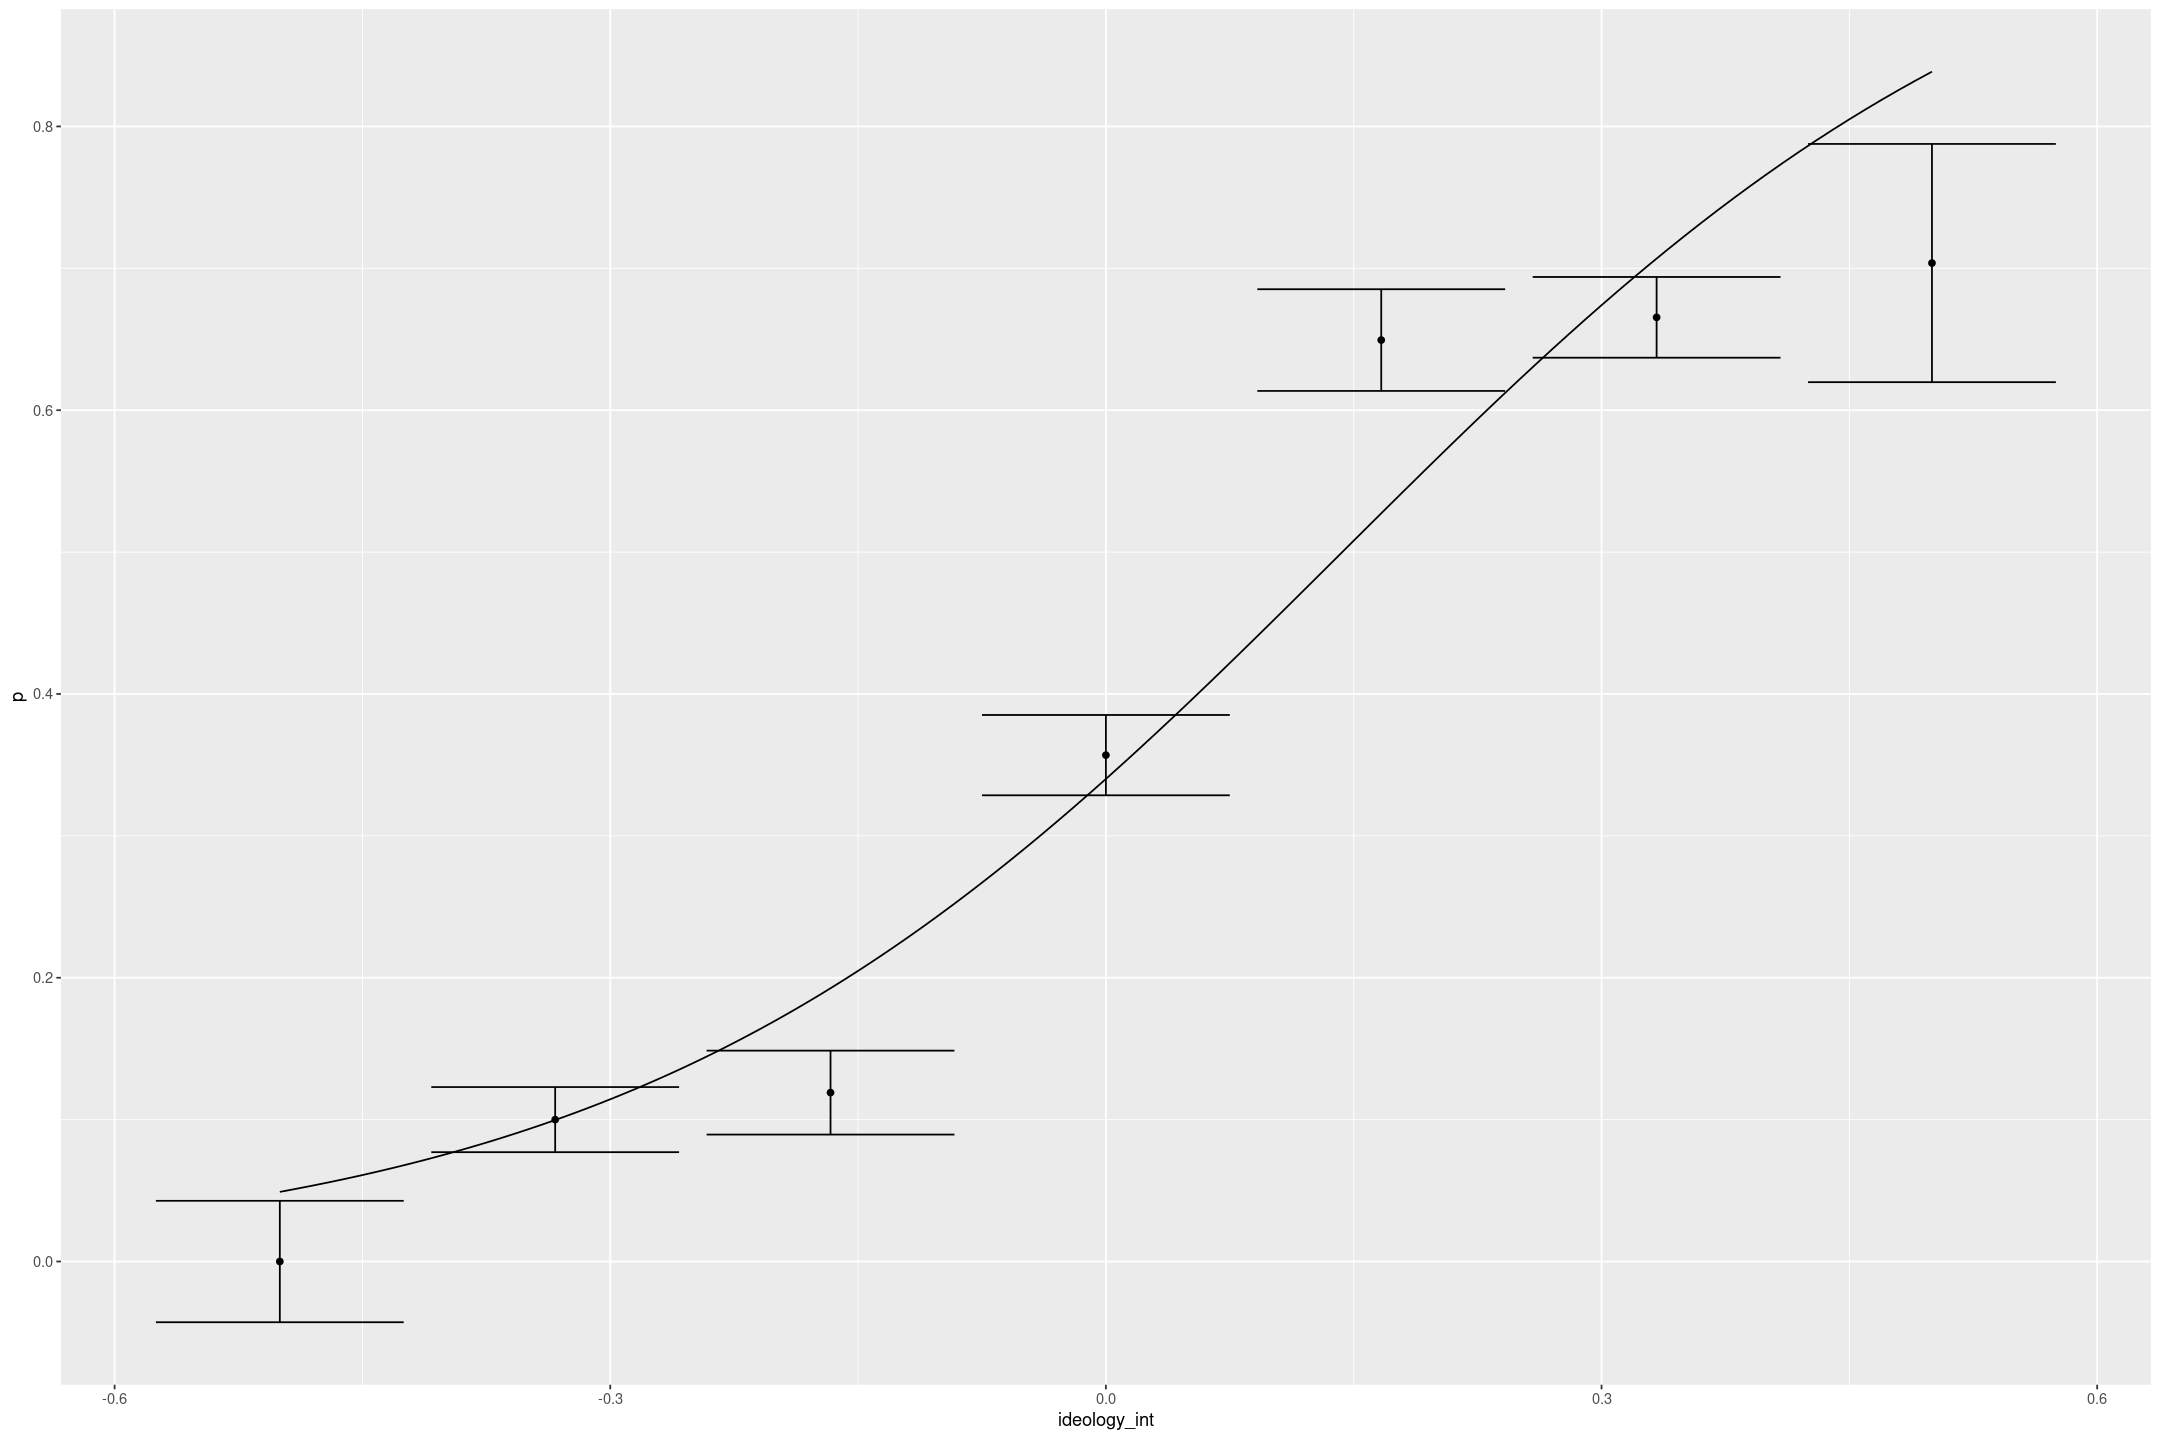

In [58]:
nes92 %>% 
group_by(ideology_int) %>% 
summarise(n=n(), p=mean(rvote)) %>% 
mutate(phat = (p*n+2)/(n+4), se = sqrt(phat*(1-phat)/(n+4))) %>%
gf_point(p ~ ideology_int) %>%
gf_errorbar(ymin=~p-se, ymax=~p+se) %>%
gf_line(data=df_ideology)

Anothe way would be to reduce this to 5 groups

In [59]:
nes92 %>% count(ideology)

ideology                        n  
1 1. extremely liberal             28
2 2. liberal                      180
3 3. slightly liberal             126
4 4. moderate, middle of the road 283
5 5. slightly conservative        174
6 6. conservative                 272
7 7. extremely conservative        27

In [60]:
(ideology_mapping <- c("1. extremely liberal", "2. liberal", "2. liberal", "3. moderate", "4. conservative", "4. conservative", "5. extremely conservative"))

[1] "1. extremely liberal"      "2. liberal"               
[3] "2. liberal"                "3. moderate"              
[5] "4. conservative"           "4. conservative"          
[7] "5. extremely conservative"

In [61]:
nes92 <- nes92 %>% mutate(ideology5 = ideology_mapping[(as.integer(ideology)-1)])
nes92 %>% count(ideology, ideology5)

ideology                        ideology5                 n  
1 1. extremely liberal            1. extremely liberal       28
2 2. liberal                      2. liberal                180
3 3. slightly liberal             2. liberal                126
4 4. moderate, middle of the road 3. moderate               283
5 5. slightly conservative        4. conservative           174
6 6. conservative                 4. conservative           272
7 7. extremely conservative       5. extremely conservative  27

In [62]:
(fit_nes_ideology5 <- stan_glm(rvote ~ ideology5, family=binomial(link="logit"), data=nes92, refresh=0))

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ ideology5
 observations: 1090
 predictors:   5
------
                                   Median MAD_SD
(Intercept)                        -4.6    1.5  
ideology52. liberal                 2.4    1.5  
ideology53. moderate                4.0    1.5  
ideology54. conservative            5.2    1.5  
ideology55. extremely conservative  5.5    1.6  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [63]:
nes92 <- nes92 %>% mutate(ideology3 = if_else(ideology_int < 0, "liberal", if_else(ideology_int > 0, "conservative", "moderate")))
nes92 %>% count(ideology, ideology3)

ideology                        ideology3    n  
1 1. extremely liberal            liberal       28
2 2. liberal                      liberal      180
3 3. slightly liberal             liberal      126
4 4. moderate, middle of the road moderate     283
5 5. slightly conservative        conservative 174
6 6. conservative                 conservative 272
7 7. extremely conservative       conservative  27

In [64]:
(fit_nes_ideology3 <- stan_glm(rvote ~ ideology3, family=binomial(link="logit"), data=nes92, refresh=0))

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ ideology3
 observations: 1090
 predictors:   3
------
                  Median MAD_SD
(Intercept)        0.7    0.1  
ideology3liberal  -2.9    0.2  
ideology3moderate -1.3    0.2  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

It seems the continuous version does oversimplify without some additional transformation to rescale (a second parameter) and potentially an asymmetry.

However all 7 together aren't all informative, 5 or 3 captures most of the information.

In [65]:
loo_nes_ideology_cts <- loo(fit_nes_ideology_cts)
loo_nes_ideology <- loo(fit_nes_ideology)
loo_nes_ideology5 <- loo(fit_nes_ideology5)
loo_nes_ideology3 <- loo(fit_nes_ideology3)


loo_compare(loo_nes_ideology_cts, loo_nes_ideology, loo_nes_ideology5, loo_nes_ideology3)

elpd_diff se_diff   elpd_loo  se_elpd_loo p_loo   
fit_nes_ideology5     0.000000 0.0000000 -596.2085 15.35728    4.071512
fit_nes_ideology3    -1.507602 0.9329839 -597.7161 15.57334    2.950447
fit_nes_ideology     -1.788396 0.5979635 -597.9969 15.45820    6.103696
fit_nes_ideology_cts -9.201599 5.0193125 -605.4101 15.08978    2.030496
                     se_p_loo  looic    se_looic
fit_nes_ideology5    0.3127219 1192.417 30.71456
fit_nes_ideology3    0.1541968 1195.432 31.14668
fit_nes_ideology     0.4049490 1195.994 30.91641
fit_nes_ideology_cts 0.1045185 1210.820 30.17957

#### Interaction of ideology and party

In [66]:
nes92 %>% 
count(ideology, party) %>%
pivot_wider(names_from=c(party), values_from=n, values_fill=0)

ideology                        1. democrats (including leaners)
1 1. extremely liberal             28                             
2 2. liberal                      162                             
3 3. slightly liberal             101                             
4 4. moderate, middle of the road 162                             
5 5. slightly conservative         55                             
6 6. conservative                  89                             
7 7. extremely conservative         6                             
  2. indpendents and apolitical (1966 only 3. republicans (including leaners)
1  0                                         0                               
2  7                                        11                               
3  7                                        18                               
4 28                                        93                               
5  7                                       112                               
6 12                                       171                               
7  2                                        19

Party is a much stronger indicator, but ideology moderates the effect.

In [67]:
nes92 %>% 
group_by(ideology, party) %>%
summarise(rvote=mean(rvote)) %>%
pivot_wider(names_from=c(party), values_from=rvote)

`summarise()` has grouped output by 'ideology'. You can override using the `.groups` argument.



ideology                        1. democrats (including leaners)
1 1. extremely liberal            0.00000000                      
2 2. liberal                      0.03086420                      
3 3. slightly liberal             0.02970297                      
4 4. moderate, middle of the road 0.08641975                      
5 5. slightly conservative        0.20000000                      
6 6. conservative                 0.16853933                      
7 7. extremely conservative       0.00000000                      
  2. indpendents and apolitical (1966 only 3. republicans (including leaners)
1        NA                                       NA                         
2 0.2857143                                1.0000000                         
3 0.1428571                                0.6111111                         
4 0.3571429                                0.8279570                         
5 0.4285714                                0.8839286                         
6 0.5000000                                0.9356725                         
7 0.5000000                                0.9473684

In [68]:
(fit_nes_ideology_party <- stan_glm(rvote ~ party + ideology, data=nes92, family=binomial(link="logit"), refresh=0))

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ party + ideology
 observations: 1090
 predictors:   9
------
                                              Median MAD_SD
(Intercept)                                   -5.3    1.8  
party2. indpendents and apolitical (1966 only  1.8    0.3  
party3. republicans (including leaners)        4.2    0.2  
ideology2. liberal                             2.2    1.8  
ideology3. slightly liberal                    1.6    1.8  
ideology4. moderate, middle of the road        2.8    1.8  
ideology5. slightly conservative               3.4    1.8  
ideology6. conservative                        3.7    1.8  
ideology7. extremely conservative              3.4    1.9  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [69]:
(fit_nes_ideology_cts_party <- stan_glm(rvote ~ party + ideology_int, data=nes92, family=binomial(link="logit"), refresh=0))

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ party + ideology_int
 observations: 1090
 predictors:   4
------
                                              Median MAD_SD
(Intercept)                                   -2.4    0.2  
party2. indpendents and apolitical (1966 only  1.7    0.3  
party3. republicans (including leaners)        4.1    0.2  
ideology_int                                   2.6    0.5  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [70]:
(fit_nes_ideology_5_party <- stan_glm(rvote ~ party + ideology5, data=nes92, family=binomial(link="logit"), refresh=0))

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ party + ideology5
 observations: 1090
 predictors:   7
------
                                              Median MAD_SD
(Intercept)                                   -5.2    1.8  
party2. indpendents and apolitical (1966 only  1.7    0.3  
party3. republicans (including leaners)        4.1    0.2  
ideology52. liberal                            2.0    1.8  
ideology53. moderate                           2.8    1.8  
ideology54. conservative                       3.6    1.8  
ideology55. extremely conservative             3.5    1.8  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [71]:
(fit_nes_ideology_3_party <- stan_glm(rvote ~ party + ideology3, data=nes92, family=binomial(link="logit"), refresh=0))

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ party + ideology3
 observations: 1090
 predictors:   5
------
                                              Median MAD_SD
(Intercept)                                   -1.7    0.2  
party2. indpendents and apolitical (1966 only  1.8    0.3  
party3. republicans (including leaners)        4.1    0.2  
ideology3liberal                              -1.6    0.3  
ideology3moderate                             -0.8    0.2  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [72]:
(fit_nes_ideology_3_party_int <- stan_glm(rvote ~ party * ideology3, data=nes92, family=binomial(link="logit"), refresh=0))

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ party * ideology3
 observations: 1090
 predictors:   9
------
                                                                Median MAD_SD
(Intercept)                                                     -1.6    0.2  
party2. indpendents and apolitical (1966 only                    1.5    0.5  
party3. republicans (including leaners)                          4.0    0.3  
ideology3liberal                                                -2.0    0.4  
ideology3moderate                                               -0.8    0.3  
party2. indpendents and apolitical (1966 only:ideology3liberal   0.8    0.9  
party3. republicans (including leaners):ideology3liberal         0.8    0.7  
party2. indpendents and apolitical (1966 only:ideology3moderate  0.3    0.7  
party3. republicans (including leaners):ideology3moderate        0.0    0.5  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors

In [73]:
(fit_nes_ideology_cts_party_int <- stan_glm(rvote ~ party * ideology_int, data=nes92, family=binomial(link="logit"), refresh=0))

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ party * ideology_int
 observations: 1090
 predictors:   6
------
                                                           Median MAD_SD
(Intercept)                                                -2.5    0.2  
party2. indpendents and apolitical (1966 only               1.8    0.3  
party3. republicans (including leaners)                     4.2    0.2  
ideology_int                                                3.0    0.6  
party2. indpendents and apolitical (1966 only:ideology_int -1.1    1.5  
party3. republicans (including leaners):ideology_int       -0.5    1.0  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [74]:
(fit_nes_ideology_party <- stan_glm(rvote ~ party, data=nes92, family=binomial(link="logit"), refresh=0))

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ party
 observations: 1090
 predictors:   3
------
                                              Median MAD_SD
(Intercept)                                   -2.5    0.1  
party2. indpendents and apolitical (1966 only  1.9    0.3  
party3. republicans (including leaners)        4.5    0.2  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

It looks again like the 3 and 5 groups are the most informative.

In [75]:
ideo_party_models <- list(party=(fit_nes_ideology_party),
                          ideo3_int = (fit_nes_ideology_3_party_int),
                          ideo3 = fit_nes_ideology_3_party,
                          ideo5 = fit_nes_ideology_5_party,
                          ideo7 = fit_nes_ideology_party,
                          ideo_cts = fit_nes_ideology_cts_party,
                          ideo_cts_int =fit_nes_ideology_cts_party_int)
loo_ideo_party_models <- purrr::map(ideo_party_models, loo)
loo_compare(loo_ideo_party_models)

elpd_diff   se_diff   elpd_loo  se_elpd_loo p_loo    se_p_loo 
ideo3          0.0000000 0.0000000 -344.5120 20.93664    5.008839 0.3744593
ideo5         -0.2257774 0.3122635 -344.7378 20.91233    5.810208 0.4983997
ideo_cts      -0.9607123 2.2209050 -345.4728 20.83095    3.878885 0.2954685
ideo_cts_int  -2.7040771 2.3539549 -347.2161 20.93274    5.905783 0.5274946
ideo3_int     -3.6109092 1.6337288 -348.1230 21.24547    9.650082 0.8781563
party        -17.0996921 6.1910702 -361.6117 21.57268    3.010135 0.2188581
ideo7        -17.0996921 6.1910702 -361.6117 21.57268    3.010135 0.2188581
             looic    se_looic
ideo3        689.0241 41.87328
ideo5        689.4756 41.82466
ideo_cts     690.9455 41.66191
ideo_cts_int 694.4322 41.86549
ideo3_int    696.2459 42.49094
party        723.2235 43.14536
ideo7        723.2235 43.14536

#### Interaction  with partisan

In [76]:
nes92 %>% 
group_by(ideology, partisan) %>%
summarise(rvote=mean(rvote)) %>%
pivot_wider(names_from=c(partisan), values_from=rvote)

`summarise()` has grouped output by 'ideology'. You can override using the `.groups` argument.



ideology                        2. leaning independent 3. weak partisan
1 1. extremely liberal            0.0000000              0.00000000      
2 2. liberal                      0.1276596              0.08888889      
3 3. slightly liberal             0.2222222              0.13513514      
4 4. moderate, middle of the road 0.3230769              0.42574257      
5 5. slightly conservative        0.6666667              0.67567568      
6 6. conservative                 0.7121212              0.60810811      
7 7. extremely conservative       0.8750000              0.50000000      
  4. strong partisan 1. independent or apolitical
1 0.00000000                NA                   
2 0.07407407         0.2857143                   
3 0.02173913         0.1428571                   
4 0.30337079         0.3571429                   
5 0.62962963         0.4285714                   
6 0.69166667         0.5000000                   
7 0.66666667         0.5000000

In [77]:
nes92 %>% 
group_by(party, partisan) %>%
summarise(rvote=mean(rvote)) %>%
pivot_wider(names_from=c(partisan), values_from=rvote)

`summarise()` has grouped output by 'party'. You can override using the `.groups` argument.



party                                    2. leaning independent
1 1. democrats (including leaners)         0.08053691            
2 2. indpendents and apolitical (1966 only         NA            
3 3. republicans (including leaners)       0.86554622            
  3. weak partisan 4. strong partisan 1. independent or apolitical
1 0.1465969        0.03041825                NA                   
2        NA                NA         0.3650794                   
3 0.8163265        0.96835443                NA

In [78]:
(fit_nes_party_partisan <- stan_glm(rvote ~ party + partisan, family=binomial(link="logit"), data=nes92, refresh=0))

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ party + partisan
 observations: 1090
 predictors:   6
------
                                              Median MAD_SD
(Intercept)                                   -2.3    3.2  
party2. indpendents and apolitical (1966 only  1.8    3.2  
party3. republicans (including leaners)        4.5    0.2  
partisan2. leaning independent                -0.3    3.2  
partisan3. weak partisan                       0.0    3.2  
partisan4. strong partisan                    -0.1    3.2  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [79]:
nes92 <- nes92 %>% mutate(party_cts = (as.integer(partisan) - 2) * (as.integer(party) - 3)/6)
nes92 %>% count(party, partisan, party_cts)

party                                    partisan                    
1 1. democrats (including leaners)         2. leaning independent      
2 1. democrats (including leaners)         3. weak partisan            
3 1. democrats (including leaners)         4. strong partisan          
4 2. indpendents and apolitical (1966 only 1. independent or apolitical
5 3. republicans (including leaners)       2. leaning independent      
6 3. republicans (including leaners)       3. weak partisan            
7 3. republicans (including leaners)       4. strong partisan          
  party_cts  n  
1 -0.1666667 149
2 -0.3333333 191
3 -0.5000000 263
4  0.0000000  63
5  0.1666667 119
6  0.3333333 147
7  0.5000000 158

In [80]:
(fit_nes_party_partisan_cts <- stan_glm(rvote ~ party_cts, family=binomial(link="logit"), data=nes92, refresh=0))

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ party_cts
 observations: 1090
 predictors:   2
------
            Median MAD_SD
(Intercept) -0.2    0.1  
party_cts    6.6    0.4  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [81]:
(fit_nes_party_partisan_int <- stan_glm(rvote ~ party_cts, family=binomial(link="logit"), data=nes92, refresh=0))

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ party_cts
 observations: 1090
 predictors:   2
------
            Median MAD_SD
(Intercept) -0.2    0.1  
party_cts    6.6    0.4  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [82]:
(fit_nes_party <- stan_glm(rvote ~ party, family=binomial(link="logit"), data=nes92, refresh=0))

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ party
 observations: 1090
 predictors:   3
------
                                              Median MAD_SD
(Intercept)                                   -2.4    0.2  
party2. indpendents and apolitical (1966 only  1.9    0.3  
party3. republicans (including leaners)        4.5    0.2  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

Maybe something more subtle would help, but none of these do.

In [83]:
loo_nes_party <- loo(fit_nes_party)
loo_nes_party_partisan <- loo(fit_nes_party_partisan)
loo_nes_party_partisan_cts <- loo(fit_nes_party_partisan_cts)

loo_compare(loo_nes_party, loo_nes_party_partisan, loo_nes_party_partisan_cts)

elpd_diff se_diff   elpd_loo  se_elpd_loo p_loo   
fit_nes_party               0.000000 0.0000000 -361.6950 21.56244    3.092438
fit_nes_party_partisan     -1.863238 0.8587617 -363.5582 21.72650    5.238958
fit_nes_party_partisan_cts -3.893217 7.1812184 -365.5882 20.85637    2.135580
                           se_p_loo  looic    se_looic
fit_nes_party              0.2245277 723.3899 43.12488
fit_nes_party_partisan     0.3895145 727.1164 43.45300
fit_nes_party_partisan_cts 0.1900889 731.1764 41.71274

### Reducing the coefficients

Interestingly, on its own, education correlates strongly with a Republican vote *except* at advanced degrees.

In [84]:
nes92 %>% group_by(education) %>% summarise(n=n(), p=mean(rvote)) %>% mutate(se=sqrt(p*(1-p)/n))

education                                n   p         se        
1 1. 8 grades or less ('grade school')      52 0.2500000 0.06004806
2 2. 9-12 grades ('high school'), no diplo  69 0.3333333 0.05675044
3 3. 12 grades, diploma or equivalency     340 0.3764706 0.02627571
4 5. some college, no degree/ junior/commu 263 0.4182510 0.03041644
5 6. ba level degree                       235 0.5319149 0.03254989
6 7. advanced degrees incl. llb            131 0.3664122 0.04209715

Is there a way to group up marital status?

Notice widowed behaves differently, but has a very different age demographic.

In [85]:
nes92 %>% group_by(marital_status) %>% summarise(n=n(), p=mean(rvote), age=mean(age)) %>% mutate(se=sqrt(p*(1-p)/n))

marital_status                           n   p         age      se        
1 1. married and living with spouse (or sp 657 0.4824962 47.54795 0.01949490
2 2. never married                         152 0.2039474 33.61842 0.03268196
3 3. divorced                              118 0.3305085 44.41525 0.04330348
4 4. separated                              26 0.3461538 45.15385 0.09330087
5 5. widowed                               111 0.4054054 71.54955 0.04660084
6 7. partners/ not married (volunteered [e  26 0.2307692 33.07692 0.08262864

In [86]:
marital_status_map <- c("married", "unmarried", "separated", "separated", "married", "unmarried")

In [87]:
nes92 <- nes92 %>% 
mutate(marital_group = marital_status_map[as.integer(marital_status) - 1])
nes92 %>% count(marital_status, marital_group)

marital_status                           marital_group n  
1 1. married and living with spouse (or sp married       657
2 2. never married                         unmarried     152
3 3. divorced                              separated     118
4 4. separated                             separated      26
5 5. widowed                               married       111
6 7. partners/ not married (volunteered [e unmarried      26

In [88]:
nes92 <- nes92 %>% mutate(advanced_degree = education == '7. advanced degrees incl. llb',
                 education_cts = (as.integer(education) - 5)/6)
nes92 %>% count(education, advanced_degree, education_cts)

education                                advanced_degree education_cts n  
1 1. 8 grades or less ('grade school')     FALSE           -0.5000000     52
2 2. 9-12 grades ('high school'), no diplo FALSE           -0.3333333     69
3 3. 12 grades, diploma or equivalency     FALSE           -0.1666667    340
4 5. some college, no degree/ junior/commu FALSE            0.1666667    263
5 6. ba level degree                       FALSE            0.3333333    235
6 7. advanced degrees incl. llb             TRUE            0.5000000    131

In [89]:
(fit_nes_subset <- stan_glm(rvote ~ income_int_std + gender + race + region + religion + education_cts 
                            + advanced_degree + marital_group + party + ideology3,
                        family=binomial(link="logit"),
                        data=nes92,
                       refresh=0))

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ income_int_std + gender + race + region + religion + 
	   education_cts + advanced_degree + marital_group + party + 
	   ideology3
 observations: 1090
 predictors:   21
------
                                                 Median MAD_SD
(Intercept)                                      -1.8    0.4  
income_int_std                                   -0.2    0.2  
gender2. female                                   0.5    0.2  
race2. black                                     -1.7    0.5  
race3. asian                                      0.3    0.9  
race4. native american                            0.8    0.6  
race5. hispanic                                   0.9    0.5  
region2. north central(il,in,ia,ks,mi,mn,mo,ne    0.3    0.3  
region3. south (al,ar,de,d.c.,fl,ga,ky,la,md,m    0.3    0.3  
region4. west (ak,az,ca,co,hi,id,mt,nv,nm,or,u   -0.1    0.4  
religion2. catholic (roman catholic)              0.0    0.3  
reli

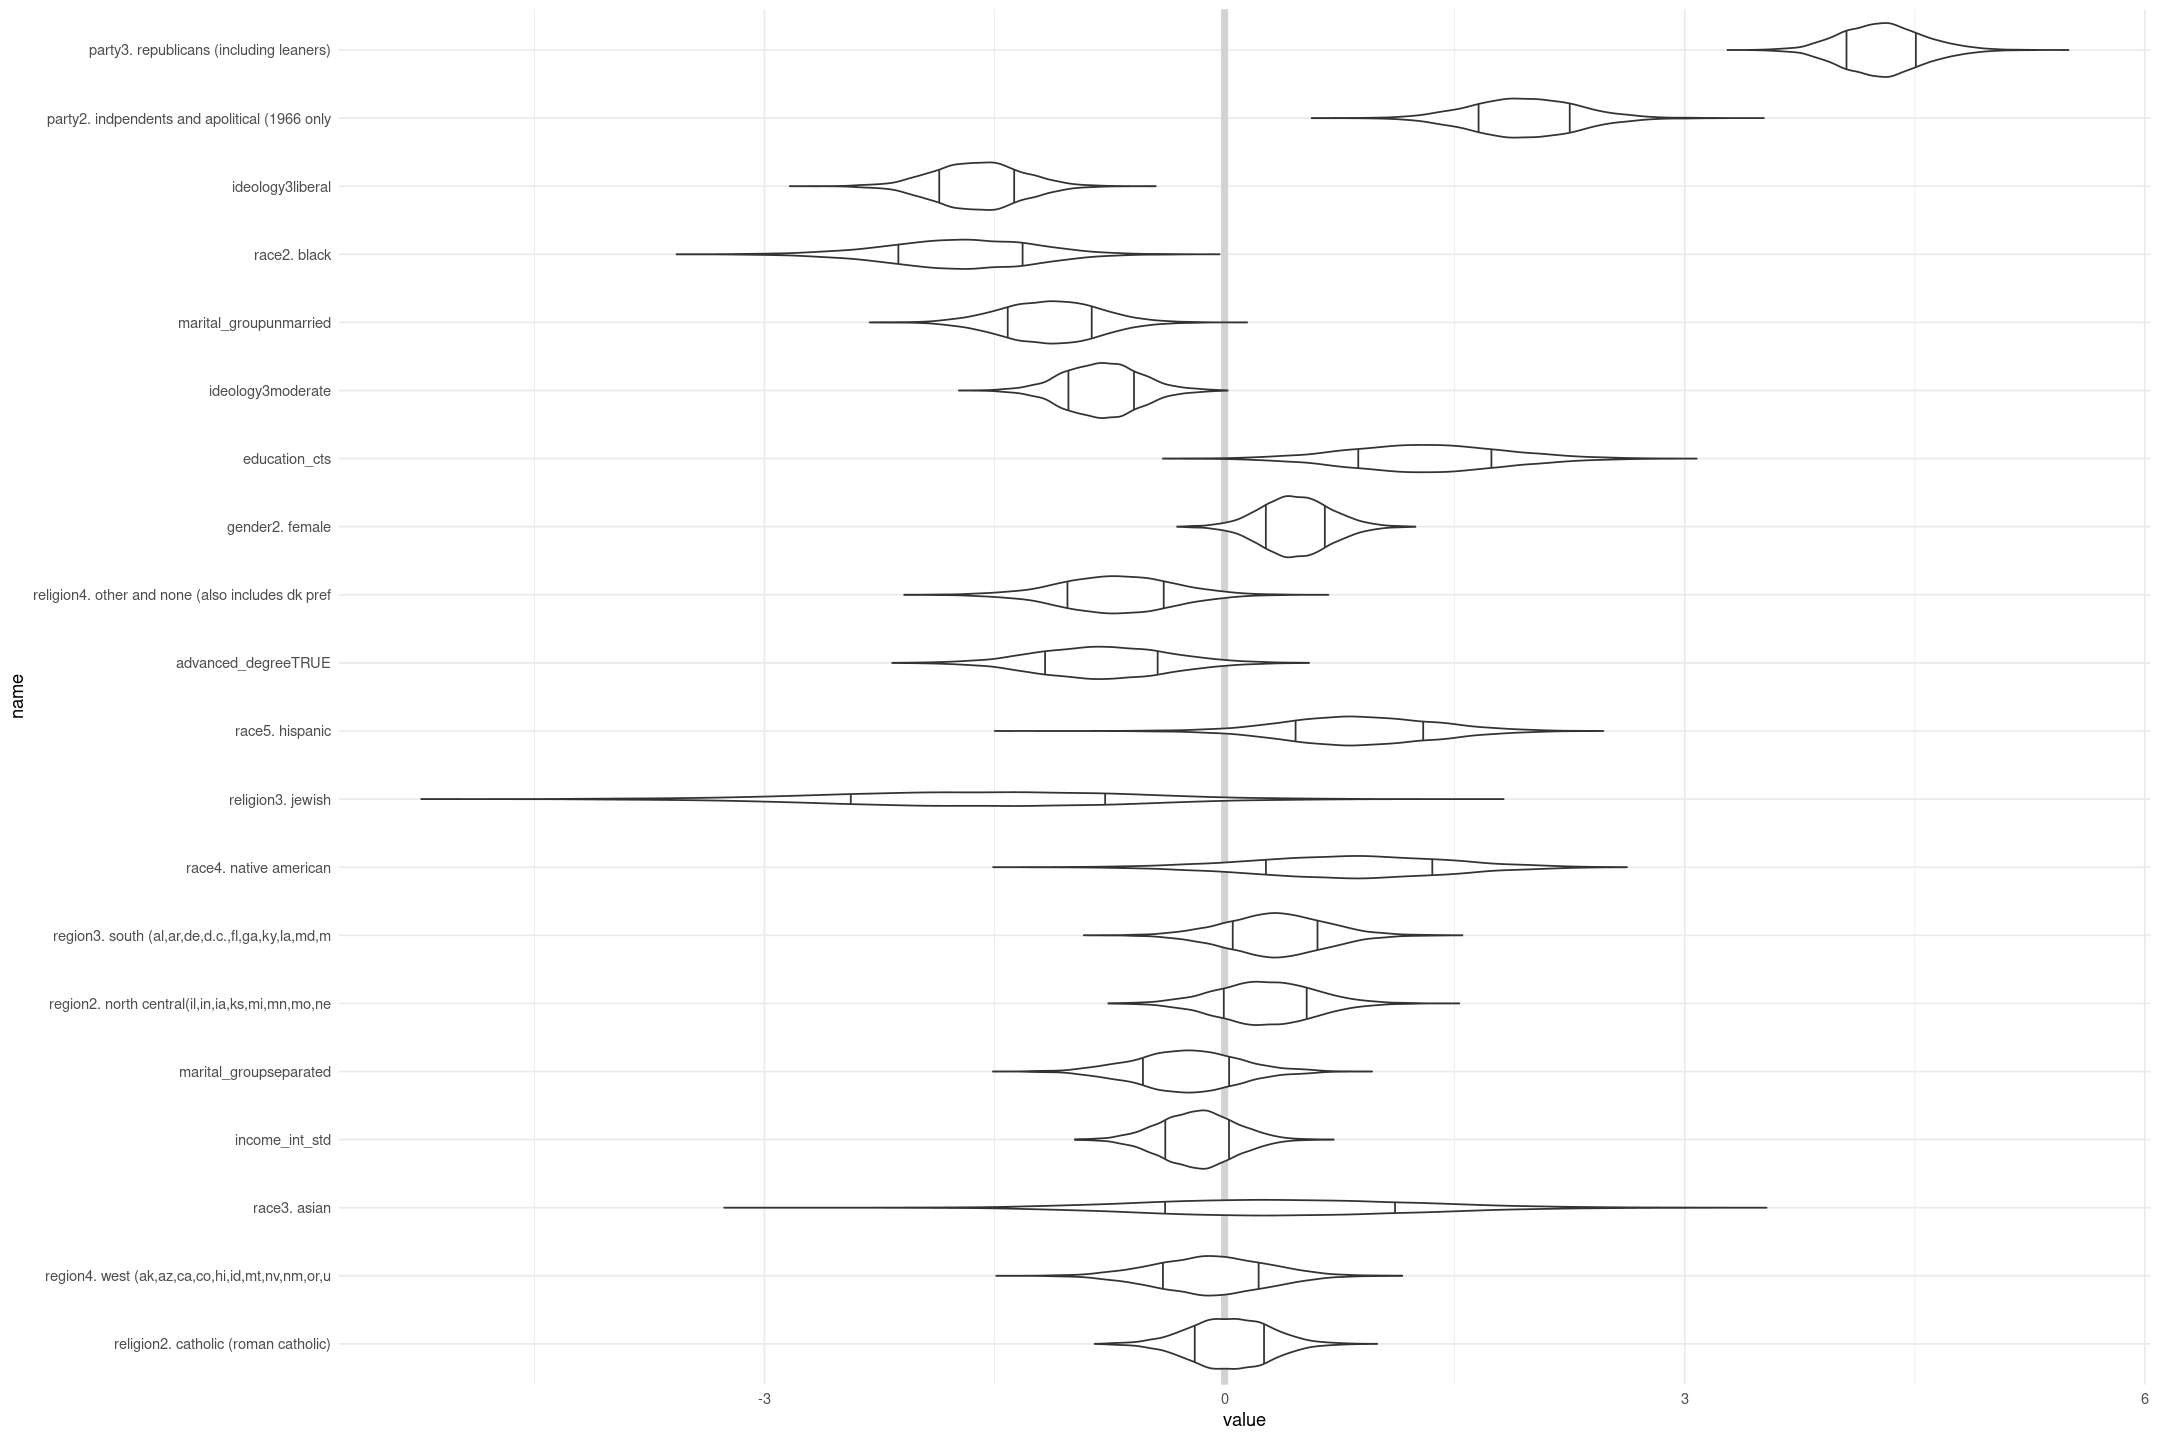

In [90]:
fit_nes_subset %>%
as.data.frame() %>%
select(-`(Intercept)`) %>%
pivot_longer(everything()) %>%
mutate(name=forcats::fct_reorder(name, value, function(.) abs(median(.)) / sd(.))) %>%
gf_hline(yintercept=~0, col="lightgrey", size=2) %>%                                 
gf_violin(value ~ name, draw_quantiles=(c(0.2, 0.8)), scale="area") +
coord_flip() +
theme_minimal()

### Adding Interactions

In [91]:
nes92 <- nes92 %>% mutate(black = race == '2. black') 
nes92 %>% count(race, black)

race               black n  
1 1. white           FALSE 864
2 2. black            TRUE 134
3 3. asian           FALSE  17
4 4. native american FALSE  29
5 5. hispanic        FALSE  46

Put in a lot of interactions

In [92]:
nes92 <- nes92 %>% mutate(married = marital_group == 'married')
nes92 %>% count(married, marital_group)

married marital_group n  
1 FALSE   separated     144
2 FALSE   unmarried     178
3  TRUE   married       768

In [93]:
(fit_nes_interactions <- stan_glm(rvote ~ income_int_std + gender + race + region + religion + education_cts 
                            + advanced_degree + marital_group + party + ideology3 +
                                  party : ideology3 + black : party + black : ideology3 +
                                  education_cts : party + education_cts : ideology3 +
                                  married : party + married : ideology3 + married:black +
                                  gender : ideology3 + gender : party,
                        family=binomial(link="logit"),
                        data=nes92,
                       refresh=0))

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ income_int_std + gender + race + region + religion + 
	   education_cts + advanced_degree + marital_group + party + 
	   ideology3 + party:ideology3 + black:party + black:ideology3 + 
	   education_cts:party + education_cts:ideology3 + married:party + 
	   married:ideology3 + married:black + gender:ideology3 + gender:party
 observations: 1090
 predictors:   44
------
                                                                Median MAD_SD
(Intercept)                                                     -2.3    2.9  
income_int_std                                                  -0.2    0.3  
gender2. female                                                  1.4    0.5  
race2. black                                                    -2.4    5.4  
race3. asian                                                     0.6    1.0  
race4. native american                                           0.6    0.7  
race5. hispanic     

In [94]:
fit_nes_interactions %>%
as.data.frame() %>%
select(-`(Intercept)`) %>%
pivot_longer(everything()) %>%
mutate(name=forcats::fct_reorder(name, value, function(.) abs(median(.)) / sd(.))) %>%
gf_hline(yintercept=~0, col="lightgrey", size=2) %>%                                 
gf_violin(value ~ name, draw_quantiles=(c(0.2, 0.8)), scale="area") +
coord_flip() +
theme_minimal()

### Picking the most significant interactions

In [95]:
(fit_nes_interactions_subset <- 
 stan_glm(rvote ~ income_int_std + gender + race + region + religion + education_cts 
                + advanced_degree + party + ideology3 +
                 gender : party,
        family=binomial(link="logit"),
        data=nes92,
           refresh=0))

stan_glm
 family:       binomial [logit]
 formula:      rvote ~ income_int_std + gender + race + region + religion + 
	   education_cts + advanced_degree + party + ideology3 + gender:party
 observations: 1090
 predictors:   21
------
                                                              Median MAD_SD
(Intercept)                                                   -2.4    0.5  
income_int_std                                                -0.1    0.2  
gender2. female                                                1.2    0.4  
race2. black                                                  -2.0    0.5  
race3. asian                                                   0.4    0.9  
race4. native american                                         0.6    0.6  
race5. hispanic                                                1.0    0.5  
region2. north central(il,in,ia,ks,mi,mn,mo,ne                 0.3    0.3  
region3. south (al,ar,de,d.c.,fl,ga,ky,la,md,m                 0.3    0.3  
region

## Evaluate and compare models

Evaluate and compare the different models you have fit.

Our interaction subset is or subset are the best models of the ones we picked.

It would be really interesting to compare with other machine learning approaches!

In [96]:
nes_final_models <- list(ideo_party=fit_nes_ideology_3_party,
all=fit_nes_all,
subset=fit_nes_subset,
interaction=fit_nes_interactions,
interaction_subset=fit_nes_interactions_subset)

nes_final_loo <- purrr::map(nes_final_models, loo)

loo_compare(nes_final_loo)

Warning message:
“Found 4 observation(s) with a pareto_k > 0.7. We recommend calling 'loo' again with argument 'k_threshold = 0.7' in order to calculate the ELPD without the assumption that these observations are negligible. This will refit the model 4 times to compute the ELPDs for the problematic observations directly.
”


elpd_diff  se_diff  elpd_loo  se_elpd_loo p_loo    
interaction_subset   0.000000 0.000000 -333.2628 21.41241    21.892475
subset              -1.052142 5.810184 -334.3149 21.60766    22.001103
ideo_party         -11.249239 7.928025 -344.5120 20.93664     5.008839
interaction        -14.510077 8.405725 -347.7729 23.83028    50.528461
all                -15.763748 7.559626 -349.0266 23.24210    43.387148
                   se_p_loo  looic    se_looic
interaction_subset 1.8623841 666.5256 42.82482
subset             1.8670537 668.6299 43.21532
ideo_party         0.3744593 689.0241 41.87328
interaction        5.7224777 695.5458 47.66056
all                3.5371312 698.0531 46.48419

## Variable importance

For the chosen model, discuss and compare the importance of each input variable in the prediction.

We have already rescaled coefficients to be on the same scale so the variable importance is based on the magnitude.

If we had binarised the categorical factors it would be easier to evaluate independently.
In this case I will put a bit of subjective judgement for categorical ones.
Most important factors are:

1. Political Party
2. Race
3. Ideology
4. Gender:Republican
5. Religion
6. Education and Advanced Degree
7. Region
8. Income

In [97]:
fit_nes_interactions_subset %>%
as.data.frame() %>%
select(-`(Intercept)`) %>%
pivot_longer(everything()) %>%
mutate(name=forcats::fct_reorder(name, value, function(.) abs(median(.)))) %>%
gf_hline(yintercept=~0, col="lightgrey", size=2) %>%                                 
gf_violin(value ~ name, draw_quantiles=(c(0.2, 0.8)), scale="area") +
coord_flip() +
theme_minimal()

# Sketching the logistic curve

Sketch the following logistic regression curves with pen on paper:

a) $ {\rm Pr}(y = 1) = {\rm logit}^{-1}(x) $

b) $ {\rm Pr}(y = 1) = {\rm logit}^{-1}(2+x) $

c) $ {\rm Pr}(y = 1) = {\rm logit}^{-1}(2x) $

d) $ {\rm Pr}(y = 1) = {\rm logit}^{-1}(2+2x) $

e) $ {\rm Pr}(y = 1) = {\rm logit}^{-1}(-2x) $

![Sketches](images/ros_13_2.jpeg)

# Understanding logistic regression coefficients

In Chapter 7 we fit a model predicting incumbent party's two-party vote percentage given economic growth: ${\rm vote} = 46.2 + 3.1 \times {\rm growth} + {\rm error} $, where `growth` ranges from -0.5 to 5.6 in the data, and errors are approximately normally distributed with mean 0 and standard deviation 3.8.
Suppose instead we were to fit a logitic regression, $ {\rm Pr}({\rm vote} > 50) = {\rm logit}^{-1}(a + b \times {\rm growth}) $. Approximately what are the estimates of $(a, b)$.

Figure this out in four steps:

<ol style="list-style-type:lower-roman;">
     
<li> Use the fitted linear regression model to estimate Pr(vote > 50) for different values of `growth`
    </li>
<li>Plot these probabilities and draw a logistic curve through them
    </li>
<li> Use the divide-by-4 rule to estimate the slope of the logistic regression model
    </li>
<li> Use the point where the probability goes through 0.5 to deduce the intercept.
    </li>
    </ol>
Do all this using the above information, without downloading the data and fitting the model.

## Estimating the probability vote > 50

$$ \begin{align}
{\rm Pr}({\rm vote} > 50) &= {\rm Pr}(46.2 + 3.1 {\rm growth} + {\mathcal N}(0, 3.8) > 50) \\
                          & ={\rm Pr}(3.8 {\mathcal N}(0,1) > 3.8 - 3.1{\rm growth}) \\
                          &= {\rm Pr}\left({\mathcal N}(0, 1) > \frac{3.8 - 3.1 {\rm growth}}{3.8}\right) \\
                          &= 1 - \Phi\left(\frac{3.8 - 3.1 {\rm growth}}{3.8}\right)
\end{align}
$$

As a check, at growth = 0:

In [98]:
mean(46.2 + rnorm(10000, sd=3.8) > 50)

[1] 0.1591

In [99]:
mean(rnorm(10000) > 1)

[1] 0.155

In [100]:
1 - pnorm(1)

[1] 0.1586553

Let's have a look at some typical average estimates of growth

In [101]:
(growth <- seq(-0.5, 5.6, length.out=5))

[1] -0.500  1.025  2.550  4.075  5.600

In [102]:
(vote_point <- 46.2 + 3.1 * growth)

[1] 44.6500 49.3775 54.1050 58.8325 63.5600

In [103]:
(incumbent_win_z <- (3.8 - 3.1 * growth)/3.8)

[1]  1.4078947  0.1638158 -1.0802632 -2.3243421 -3.5684211

We can estimate these using the 68-95-99.7 rule.

For example the probability of being more than 1 standard deviation below the mean is (100% - 68%)/2 = 16%.
So the probability at Z=-1 is 1-16% = 84%.

In [104]:
1 - pnorm(incumbent_win_z)

[1] 0.07958112 0.43493808 0.85998749 0.98994642 0.99982043

## Plotting

In [105]:
growth <- seq(-0.5, 5.6, length.out=100)
incumbent_win_z <- (3.8 - 3.1 * growth)/3.8
incumbent_win_p <- 1 - pnorm(incumbent_win_z)

n_sample <- 300
growth_sample <- runif(n_sample, -0.5, 5.6)
outcome_sample <- as.numeric(46.2 + 3.1 * growth_sample + rnorm(n_sample, sd=3.8) > 50)

gf_line(incumbent_win_p ~ growth) %>%
gf_point(outcome_sample ~ growth_sample) +
scale_x_continuous(breaks=seq(-0.5, 5, by=0.5), minor_breaks=seq(-0.5, 5, by=0.1)) +
scale_y_continuous(breaks=seq(0, 1, by=0.2), minor_breaks=seq(0, 1, by=0.1))

## Estimating Coefficients

In [106]:
1.3*1.2

[1] 1.56

A rise of 0.1 to 0.6 happens over a run of 0.3, so the maximum slope is about 1/3.
So 1/4 the coefficient of growth in the logistic regression model should be about this, so the coefficient is 4/3 or 1.3.

The probability 0.5 happens around growth = 1.2.
So `1.3 * 1.2 + intercept = 0`
That is `intercept = -1.6`.

So our model is: $$ p = {\rm logit}^{-1}(1.3 \times {\rm growth} - 1.6 ) $$

### Analytic solution

We can solve this analytically.

The probabilty of 0.5 happens where $ 46.2+3.1 {\rm growth} = 50 $, that is at `growth = 1.2`.

To calculate the slope:

$ \frac{\rm d}{{\rm d}\, {\rm growth}} 1 - \Phi\left(\frac{3.8 - 3.1 {\rm growth}}{3.8}\right) = \frac{3.1}{3.8} \phi\left(\frac{3.8 - 3.1 {\rm growth}}{3.8}\right) $

So where the probabiliy is 0.5 this is $\frac{3.1}{3.8} \phi(0) = \frac{0.81}{\sqrt{2 \pi}}  = 0.33.$
This is the same as we estimated from the graph above, giving the same equation.

## Checking with simulation

A simulation gives similar coefficients as we estimated.

In [107]:
n_sample <- 2000
growth_sample <- runif(n_sample, -0.5, 5.6)
preds <- 46.2 + 3.1 * growth_sample + rnorm(n_sample, sd=3.8) > 50

df_growth <- data.frame(growth_sample, preds)

(growth_sim_model <- stan_glm(preds ~ growth_sample, family=binomial(link="logit"), data=df_growth, refresh=0))

stan_glm
 family:       binomial [logit]
 formula:      preds ~ growth_sample
 observations: 2000
 predictors:   2
------
              Median MAD_SD
(Intercept)   -1.9    0.1  
growth_sample  1.4    0.1  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

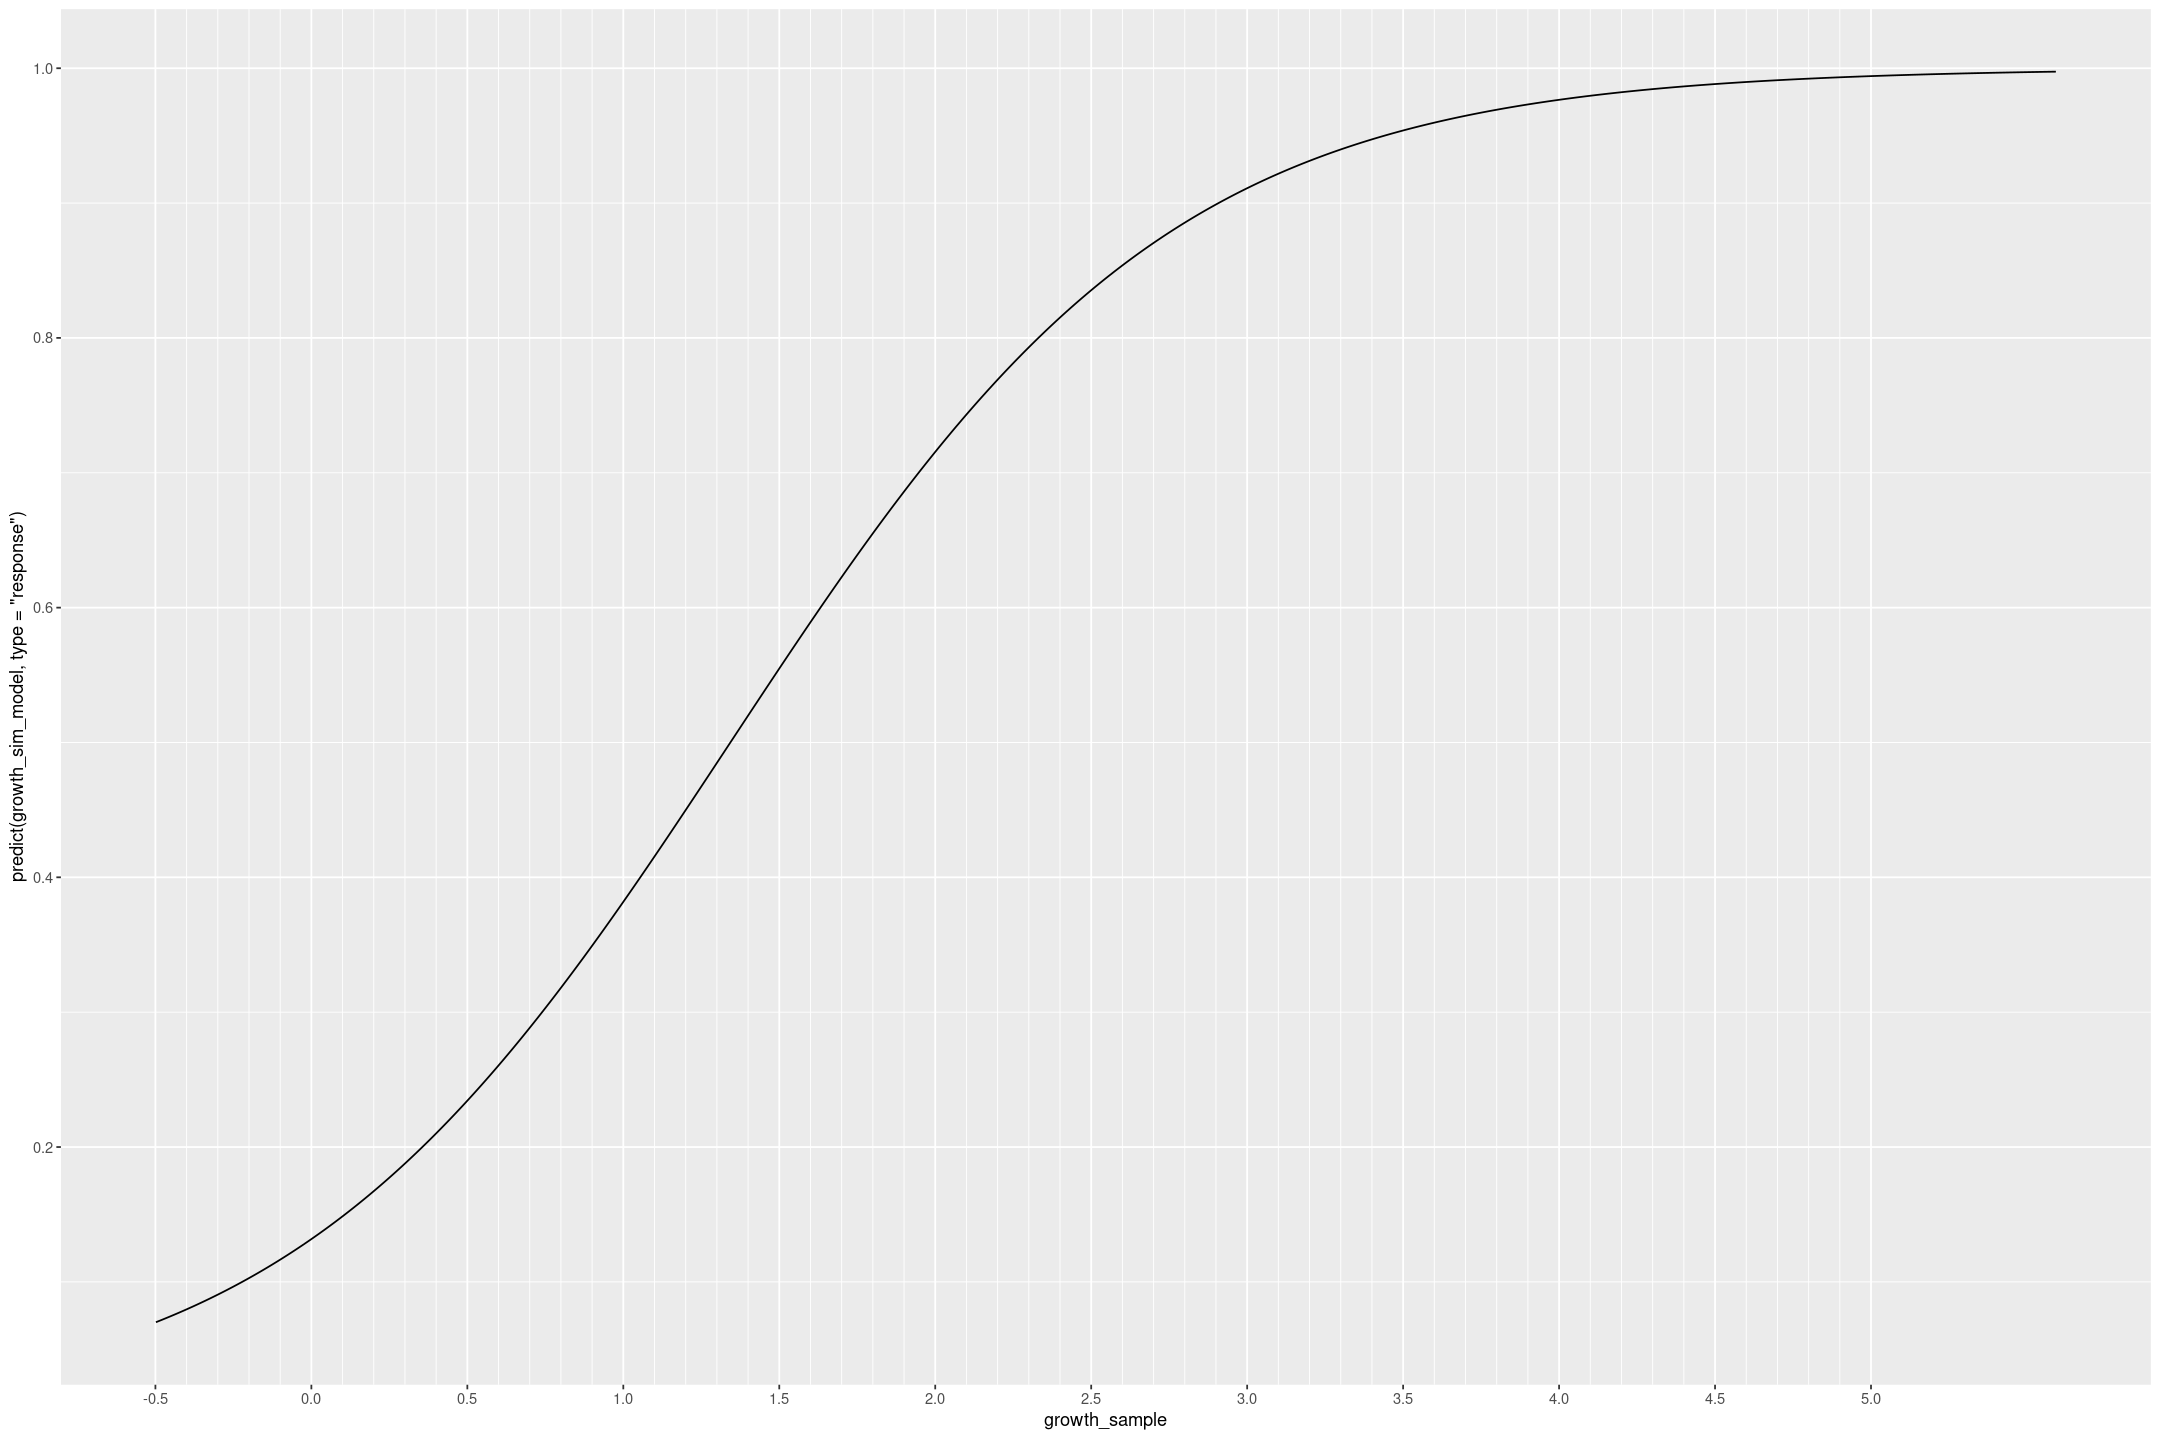

In [108]:
gf_line(predict(growth_sim_model, type="response") ~ growth_sample) +
scale_x_continuous(breaks=seq(-0.5, 5, by=0.5), minor_breaks=seq(-0.5, 5, by=0.1)) +
scale_y_continuous(breaks=seq(0, 1, by=0.2), minor_breaks=seq(0, 1, by=0.1))

# Logistic regression with two predictors

The following logistic regression has been fit:

```
            Median    MAD_SD
(Intercept)  -1.9      0.6
x             0.7      0.8
z             0.7      0.5
```

Here, $x$ is a continuous predictor ranging from 0 to 10, and $z$ is a binary predictor taking on the values 0 and 1.
Display the fitted model as two curves on a graph of ${\rm Pr}(y=1)$ vs $x$.

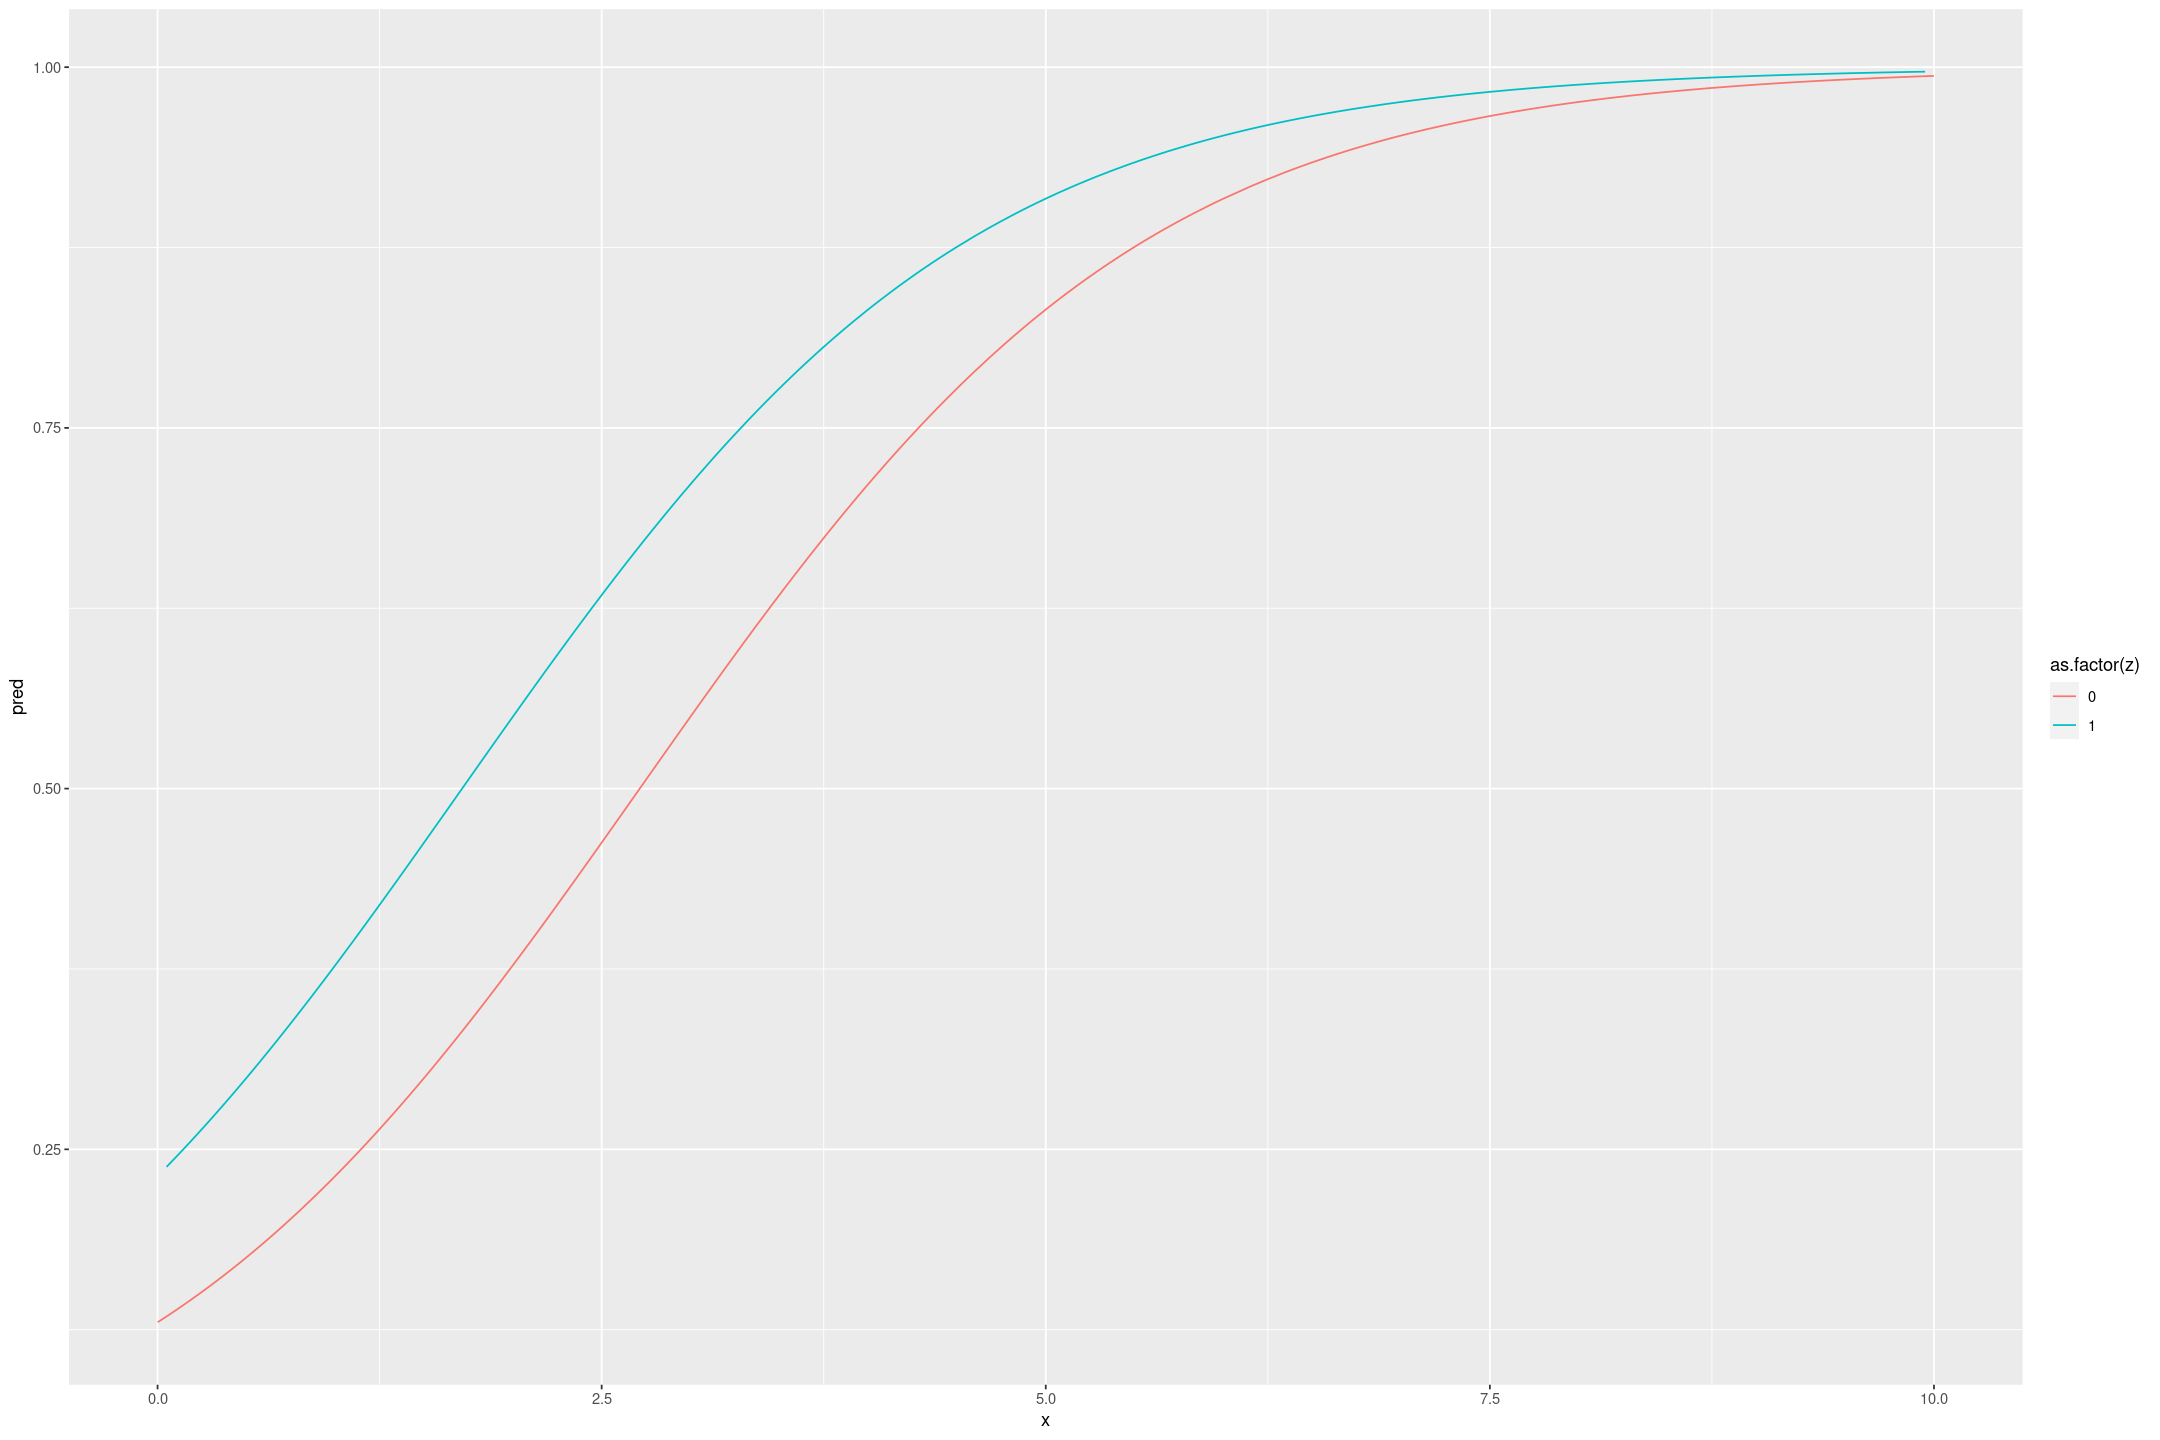

In [109]:
n <- 1000
fake_data <- data.frame(x=runif(n, 0, 10), z=rbinom(n, 1, 0.5)) %>%
mutate(pred = invlogit(-1.9 + 0.7 * x + 0.7 * z))

fake_data %>% 
gf_line(pred ~ x, col=~as.factor(z))

# Intepreting logistic regression coefficients

Here is a fitted model from the Bangladesh analysis predicting whether a person with high-arsenic drinking water will switch wells, given the arsenic level in their existing well and the disance to the nearest safe well:

```
stan_glm(formula = switch ~ dist100 + arsenic, family=binomial(link="logit"), data=wells)

            Median    MAD_SD
(Intercept)  0.00      0.08
dist100     -0.90      0.10
arsenic      0.46      0.04
```

Compare two people who live the same distance from the nearest well bus whose arsenic levels differ, with one person having an arsenic level of 0.5 and the other person having a level of 1.0.
You will estimate how much more likely this second person is to switch wells.
Give an approximate estimate, standard error, 50% interval, 95% interval, using two different methods.

## Divide-by-4

Use the divide-by-4 rule, based on the information from this regression output.

Using the divide by 4 rule a difference of 1 unit in arsenic is at most 0.46/4 = 0.115, and this approximation is good near 50%.

So an estimate of is the person whose nearest well has an arsenic level of 1.0 is about 5.8% (0.5 * 0.115) more likely to switch than the person whose well has an arsenic level of 0.5.
The standard error of this estimate is about 0.5% (0.5 * 0.04/4).

The 50% interval happens at a z-score of +/- 0.675, so it's around `[5.4%,6.1%]`.

A 95% interval happens at a z-score or +/- 2, so it's around `[4.7%,6.8%]`.

## Predictive simulation

Use predictive simulation from the fitted model in R, under the assumption that these two people each live 50 meters from the nearest well.

In [110]:
filename <- "./data/Arsenic/wells.csv"

download_if_missing(filename,
                    'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Arsenic/data/wells.csv')

wells <- read.csv(filename)

In [111]:
well_model <- stan_glm(formula = switch ~ dist100 + arsenic, family=binomial(link="logit"), data=wells, refresh=0)

In [112]:
print(well_model, digits=2)

stan_glm
 family:       binomial [logit]
 formula:      switch ~ dist100 + arsenic
 observations: 3020
 predictors:   3
------
            Median MAD_SD
(Intercept)  0.00   0.08 
dist100     -0.90   0.11 
arsenic      0.46   0.04 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


In [113]:
fake_well_data = data.frame(dist100=c(0.5, 0.5), arsenic=c(0.5, 1))

In [114]:
predictions <- posterior_epred(well_model, newdata=fake_well_data)

dim(predictions)

[1] 4000    2

In [115]:
pred_one <- predictions[,1]
pred_two <- predictions[,2]

pred_diff = pred_two - pred_one

The point predictions are the median (say) predictions.

This gives about 6%.

In [116]:
scales::percent(median(pred_diff), 0.1)

[1] "5.7%"

We can estimate the standard error of the predictions

In [117]:
scales::percent(sd(pred_diff), 0.1)

[1] "0.5%"

The 50% interval happens between the 25th and 75th quantile

In [118]:
pred_diff %>% quantile(c(0.25, 0.75)) %>% scales::percent(0.1)

25%    75% 
"5.4%" "6.1%"

The 95% interval happens between the 2.5% and 97.5% quantiles

In [119]:
pred_diff %>% quantile(c(0.025, 0.975)) %>% scales::percent(0.1)

2.5%  97.5% 
"4.8%" "6.7%"

# Interpreting logistic regression coefficient uncertainties

In Section 14.2, there were two models, `fit_4` and `fit_5`, with distance and arsenic levels as predictors along with an interaction term.
The model `fit_5` differed by using centred predictors.
Compare the reported uncertainty estimates (mad sd) for the coefficients, and use for example the `mcmc_pairs` function in the `bayesplot` package to examine the pairwise joint posterior distributions.
Explain why the mad sd values are different for `fit_4` and `fit_5`.

In [120]:
wells <- wells %>% 
mutate(dist100 = dist/100,
       c_dist100 = dist100 - mean(dist100),
       c_arsenic = arsenic - mean(arsenic))

In [121]:
fit4 <- stan_glm(switch ~ dist100 + arsenic + dist100:arsenic,
                family=binomial(link="logit"),
                data=wells,
                refresh=0)
print(fit4, digits=2)

stan_glm
 family:       binomial [logit]
 formula:      switch ~ dist100 + arsenic + dist100:arsenic
 observations: 3020
 predictors:   4
------
                Median MAD_SD
(Intercept)     -0.14   0.12 
dist100         -0.58   0.21 
arsenic          0.55   0.07 
dist100:arsenic -0.18   0.10 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


In [122]:
fit5 <- stan_glm(switch ~ c_dist100 + c_arsenic + c_dist100:c_arsenic,
                family=binomial(link="logit"),
                data=wells,
                refresh=0)
print(fit5, digits=2)

stan_glm
 family:       binomial [logit]
 formula:      switch ~ c_dist100 + c_arsenic + c_dist100:c_arsenic
 observations: 3020
 predictors:   4
------
                    Median MAD_SD
(Intercept)          0.35   0.04 
c_dist100           -0.88   0.10 
c_arsenic            0.47   0.04 
c_dist100:c_arsenic -0.18   0.10 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


The joint distributions are quite elliptical for fit_4, but for the centred model they're much more circular.

In [123]:
mcmc_pairs(fit4)

In [124]:
mcmc_pairs(fit5)

Let's consider how the models differ; for fit_5:

```
Pr(switch) = invlogit(a + b * (dist100 - mean(dist100)) + c * (arsenic - mean(arsenic)) + d * (arsenic - mean(arsenic)) * (dist100 - mean(dist100))
```

That is:

```
Pr(switch) = invlogit(a - b mean(dist100) - c mean(arsenic) + d * mean(arsenic) * mean(dist100) + dist100 (b - d * mean(arsenic)) + arsenic * (c - d * mean(dist100)) + d * arsenic * dist100)
```

In both models the coefficient for `arsenic:dist100` is the same.
But a small change in this coefficient has different effects for the estimates of `arsenic` (differing by `Delta(d) * mean(dist100)`) and `dist100` (differeng by `Delta(d) * mean(arsenic)`).

I wonder whether trying to estimate these near the centre of the data gives the most stable estimates and circular plots in general (or at least for reasonable datasets).

# Graphing a fitted logistic regression

We downloaded data with weight (in pounds) and age (in years) from a random sample of American adults.
We then defined a new variable:

```
heavy <- weight > 200
```

and fit a logistic regression, predicting `heavy` from `height` (in inches).

```
stan_glm(formula = heavy ~ height, family=binomial(link="logit"), data=health)

            Median    MAD_SD
(Intercept) -21.51     1.60
height        0.28     0.02
```

## Graph the curve

Graph the logistic regression curve (the probability that someone is heavy) over the approximate range of the data.
Be clear where the line goes through the 50% probability piont.

The line will cross 50% where 0.28 * height = 21.51, which is around 77 inches (195 cm)


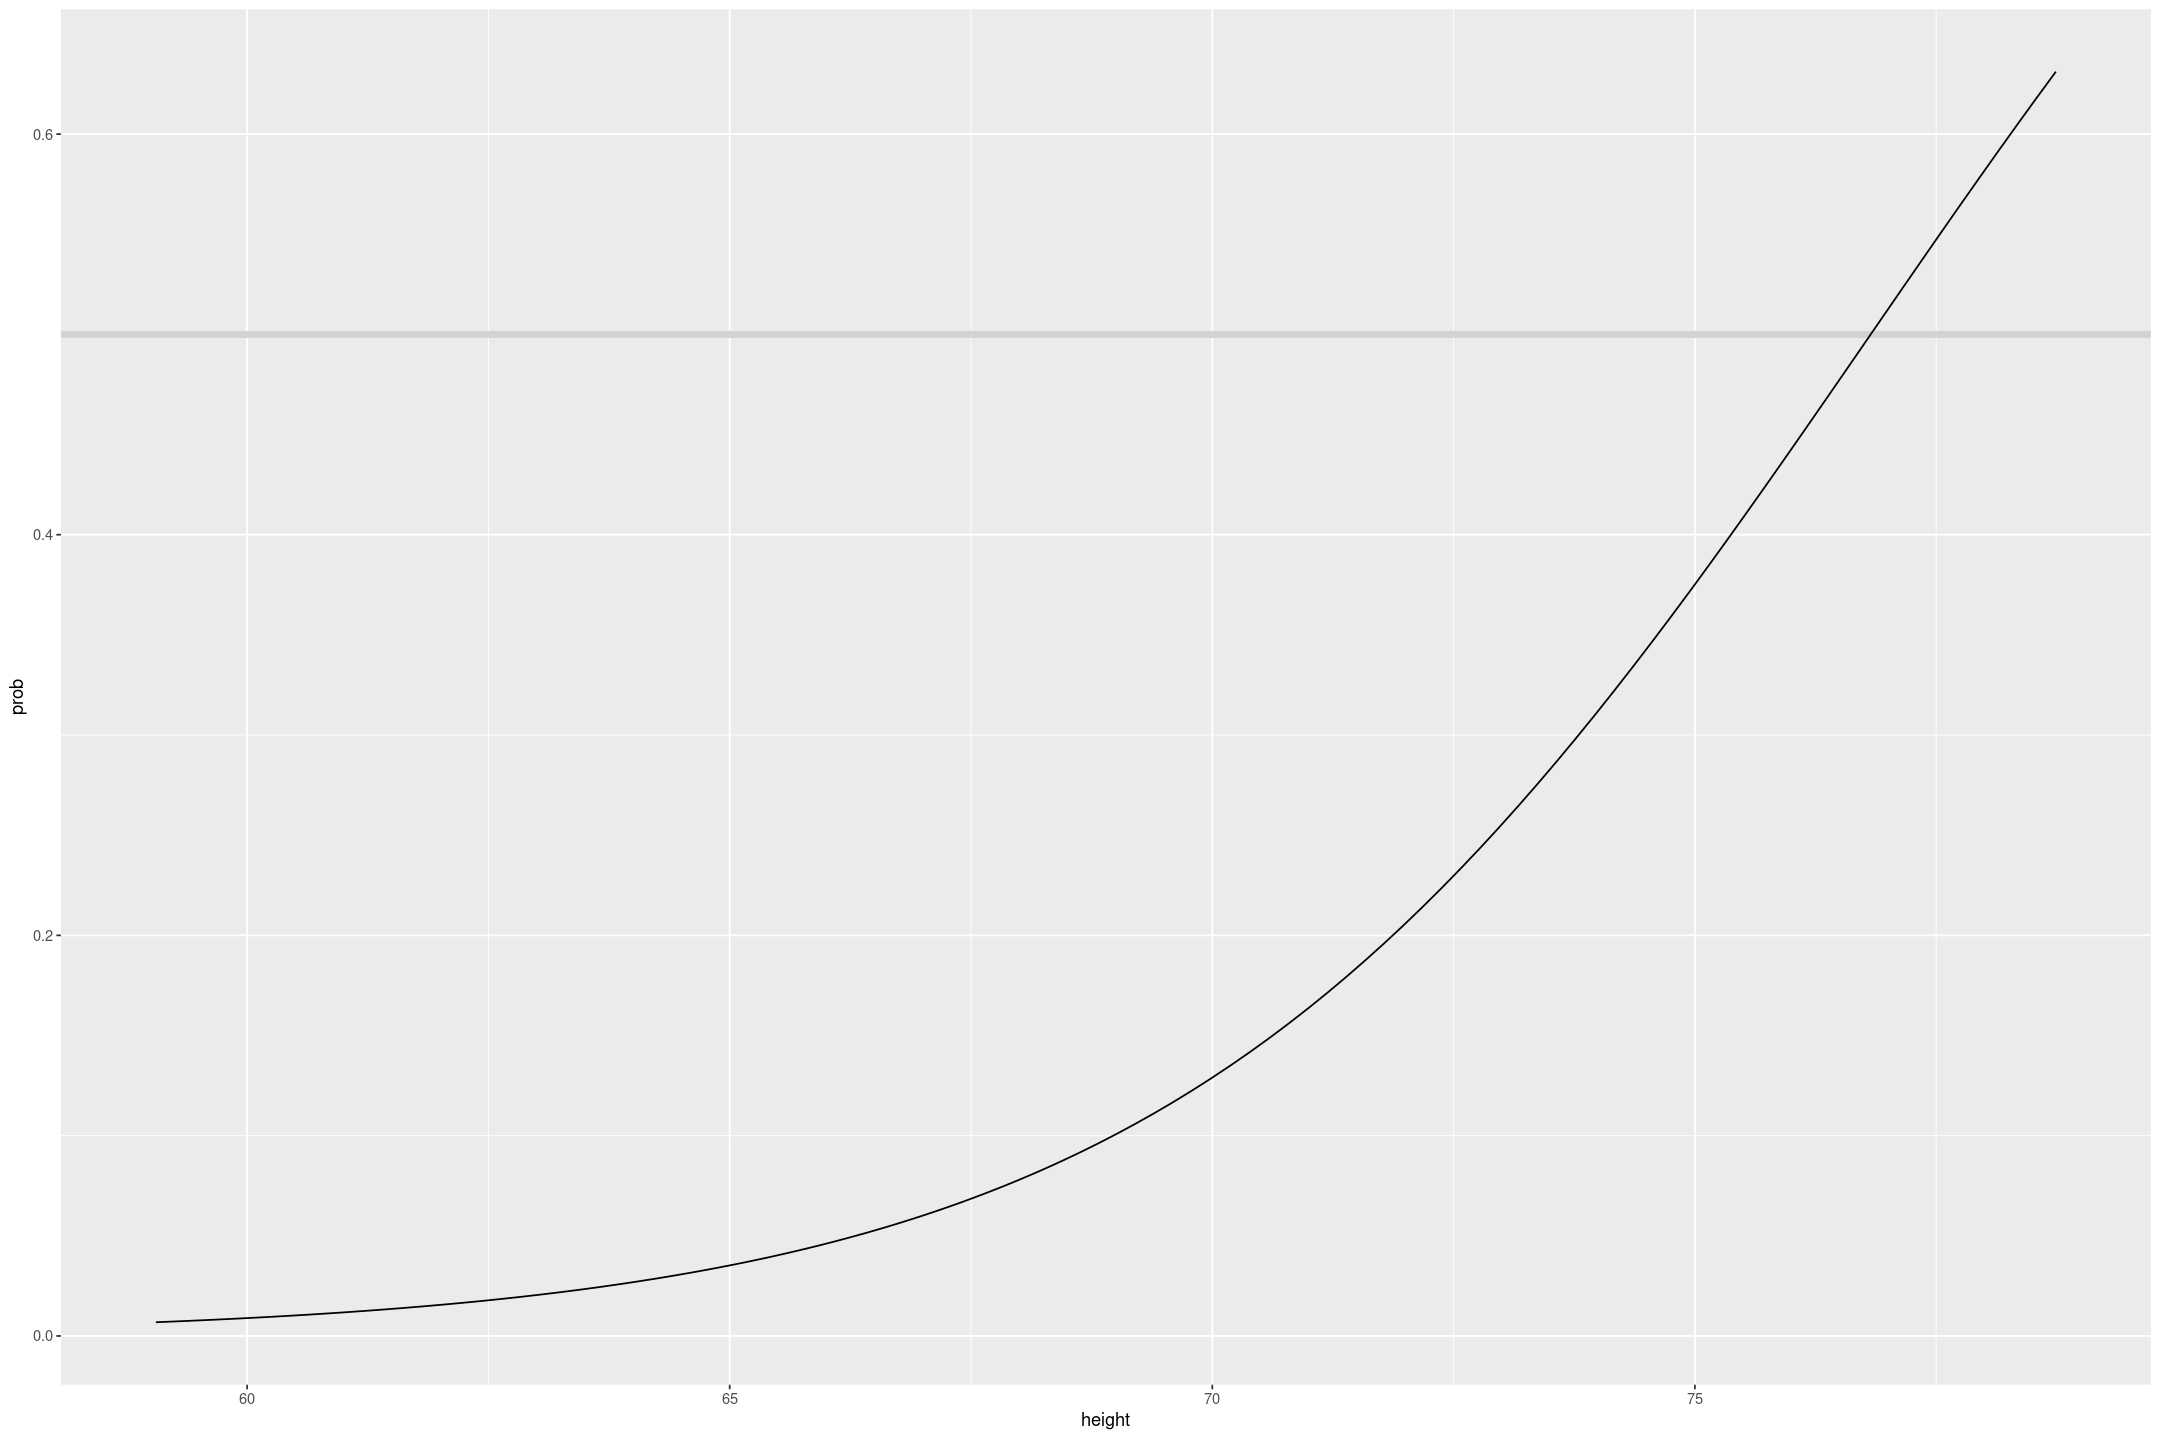

In [125]:
height <- seq(150, 200, length.out=100) / 2.54

prob <- invlogit(-21.51 + 0.28 * height)

gf_hline(yintercept=~0.5, size=2, colour="lightgrey") %>%
gf_line(prob ~ height)

## Fill in the blank

Near the 50% point, comparing two people who differ by one inch in height, you'll expect a difference of **7%** in the probability of being heavy.

Note that the change down for shorter heights, far away from 50% probability of being heavy.

At 76 inches it's a good approximation

In [126]:
invlogit(-21.51 + 0.28 * 76) - invlogit(-21.51 + 0.28 * 75)

[1] 0.06755862

Not so much at 62 inches, the difference here is only 0.4%

In [127]:
invlogit(-21.51 + 0.28 * 62) - invlogit(-21.51 + 0.28 * 61)

[1] 0.003745551

# Linear transformations

In the regression from the previous exercise, suppose you replace height in inches by height in centimeters.
What would then be the intercept and slope?

The slope is  0.28 logit points/inch / (2.54cm/inch) = 0.11 logit points/cm

The intercept gives the probability at 0 inches, which is also 0 cm, and so is unchanged at -21.51.

For example, converting the previous example to cm:

For example comparing at 76 inches = 76 inches * 2.54 cm/inch = 193 cm

In [128]:
76 * 2.54

[1] 193.04

In [129]:
invlogit(-21.51 + 0.11 * 193)

[1] 0.4304538

In [130]:
invlogit(-21.51 + 0.28 * 76)

[1] 0.4427521

# The algebra of logistic regression with one predictor

You are interested in how well the combined earnings of the parents in a child's family predicts high school graduation.
You are told that the probability a child graduates from high school is 27% for children whose parents earn no income and is 88% for children whose parents earn \\$60&thinsp;000.
Determine the logistic regression model that is consistent with this information.
For simplicity, you may want to assume that income is measured in units of \\$10&thinsp;000.

Model: $$ {\rm Pr}({\rm graduate}) = {\rm logit}^{-1}(a + b \,{\rm parents\_earnings\_10k})$$

where `parents_earnings_10k` is the parents income in units of \\$10&thinsp;000.
We are given that when parents income is 0 the probability is 27%.
Substituting in and solving for $a$ gives 

$$ a = {\rm logit}(0.27) = -1 $$

We are also given that at \\$60&thinsp;000 it's 88%.

$$ -1 + 6 b = \rm{logit}(0.88) $$

Solving for $b$ gives $b = \frac{{\rm logit}(0.88) + 1}{6} \approx 0.5 $.

So our model is  $$ {\rm Pr}({\rm graduate}) = {\rm logit}^{-1}(-1 + 0.5 \,{\rm parents\_earnings\_10k})$$

In [131]:
logit(0.27)

[1] -0.9946226

In [132]:
logit(0.88)

[1] 1.99243

In [133]:
(logit(0.88) + 1)/6

[1] 0.4987384

# Expressing a comparison of proportions as a logistic regression

A randomized experiment is performed within a survey, and 1000 people are contacted.
Half the people contacted are promised a \\$5 incentive to participate, and half are not promised and incentive.
The result is a 50% response rate among the treated group and 40% response rate among the control group.

## Fitting Logistic Regression

Set up these results as data in R.
From these data, fit a logistic regression of response on the treatment indicator.

In [134]:
df_prop <- data.frame(incentive = c(rep(1, 500), rep(0, 500))) %>%
mutate(respond = rbinom(length(incentive), 1, prob=if_else(incentive==1, 0.5, 0.4)))

df_prop %>% group_by(incentive) %>% summarise(n=n(), respond=mean(respond))

incentive n   respond
1 0         500 0.404  
2 1         500 0.490

In [135]:
fit_incentive <- stan_glm(respond ~ incentive, family=binomial(link="logit"), data=df_prop, refresh=0)

print(fit_incentive, digits=2)

stan_glm
 family:       binomial [logit]
 formula:      respond ~ incentive
 observations: 1000
 predictors:   2
------
            Median MAD_SD
(Intercept) -0.39   0.09 
incentive    0.35   0.12 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


## Comparing with Statistical Inference

Compare to the results from Exercise 4.1.

Using a binomial model

In [136]:
(se_incentive <- sqrt(0.5 * 0.5 / 500))

[1] 0.02236068

In [137]:
(se_no_incentive <- sqrt(0.4 * 0.6 / 500))

[1] 0.0219089

Then an estimate of the overall treatment effect is (normal approximation)

In [138]:
(se_effect <- sqrt(se_incentive^2 + se_no_incentive^2))

[1] 0.03130495

From our model we have an estimated uncertainty in the slope of 0.13.

Using the divide-by-4 rule (since the probabilities are close to 50%), this means the uncertainty in the effect size is about 3% - roughly the same as our probability estimate above.

# Building a logistic regression model

The folder [Rodents](https://github.com/avehtari/ROS-Examples/tree/master/Rodents) contains data on rodents in a sample of New York City apartments.

In [139]:
filename <- 'data/Rodents/rodents.dat'

download_if_missing(filename, 'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Rodents/rodents.dat')

rodents <- read.table(filename)

In [140]:
rodents %>% head()

borough numunits stories race personrm housewgt  sequenceno under6 cd
24 1       10       4       4    1.00     189.67769 128311     1      1 
25 1       10       4       4    1.33     191.49159 948690     2      1 
26 1       10       4       3    2.00     189.67769 898054     3      1 
27 1       10       4       4    0.67     176.21004 938231     1      1 
33 1        9       3       2    1.00      15.71861 656026     2      1 
34 1        9       3       4    1.50     182.99832 482104     1      1 
   unitflr2 regext totincom2 subsidy housing poverty povertyx2 extwin4_2
24 4        1      43540     0       2       0       0         0        
25 4        1      15000     0       2       1       1         0        
26 4        1      10000     0       2       1       1         0        
27 4        1      28100     0       2       0       0         0        
33 3        0      18200     0       4       1       1         0        
34 4        1      57000     0       2       0       0         0        
   extflr5_2 intcrack2 inthole2 intpeel_cat intleak2 duration board2 struct old
24 0         0         0        0           0         1       0      1      1  
25 0         0         0        0           0         9       0      1      1  
26 0         0         0        0           0         3       0      1      1  
27 0         0         0        0           0         3       0      1      1  
33 0         0         0        1           0        17       1      0      1  
34 0         0         0        0           1         8       0      0      1  
   help rodent2 foreign dilap black_Mean board2_Mean foreign_Mean help_Mean
24 1    0       1       0     0.23       0.26        0.64         0.55     
25 1    0       1       0     0.23       0.26        0.64         0.55     
26 1    0       1       0     0.23       0.26        0.64         0.55     
27 0    0       1       0     0.23       0.26        0.64         0.55     
33 1    1       0       0     0.23       0.26        0.64         0.55     
34 0    1       1       0     0.23       0.26        0.64         0.55     
   hispanic_Mean old_Mean poverty_Mean povertyx2_Mean pubhous_Mean regext_Mean
24 0.74          0.59     0.48         0.73           0.28         0.54       
25 0.74          0.59     0.48         0.73           0.28         0.54       
26 0.74          0.59     0.48         0.73           0.28         0.54       
27 0.74          0.59     0.48         0.73           0.28         0.54       
33 0.74          0.59     0.48         0.73           0.28         0.54       
34 0.74          0.59     0.48         0.73           0.28         0.54       
   struct_Mean dilap_Mean ownhous_Mean duration_Mean extwin4_2_Mean
24 0.43        0.03       0.05         11.6          0.02          
25 0.43        0.03       0.05         11.6          0.02          
26 0.43        0.03       0.05         11.6          0.02          
27 0.43        0.03       0.05         11.6          0.02          
33 0.43        0.03       0.05         11.6          0.02          
34 0.43        0.03       0.05         11.6          0.02          
   extflr5_2_Mean intcrack2_Mean inthole2_Mean intleak2_Mean vacrate bldg
24 0.07           0.22           0.16          0.27          0.05    11  
25 0.07           0.22           0.16          0.27          0.05    11  
26 0.07           0.22           0.16          0.27          0.05    11  
27 0.07           0.22           0.16          0.27          0.05    11  
33 0.07           0.22           0.16          0.27          0.05    16  
34 0.07           0.22           0.16          0.27          0.05    16

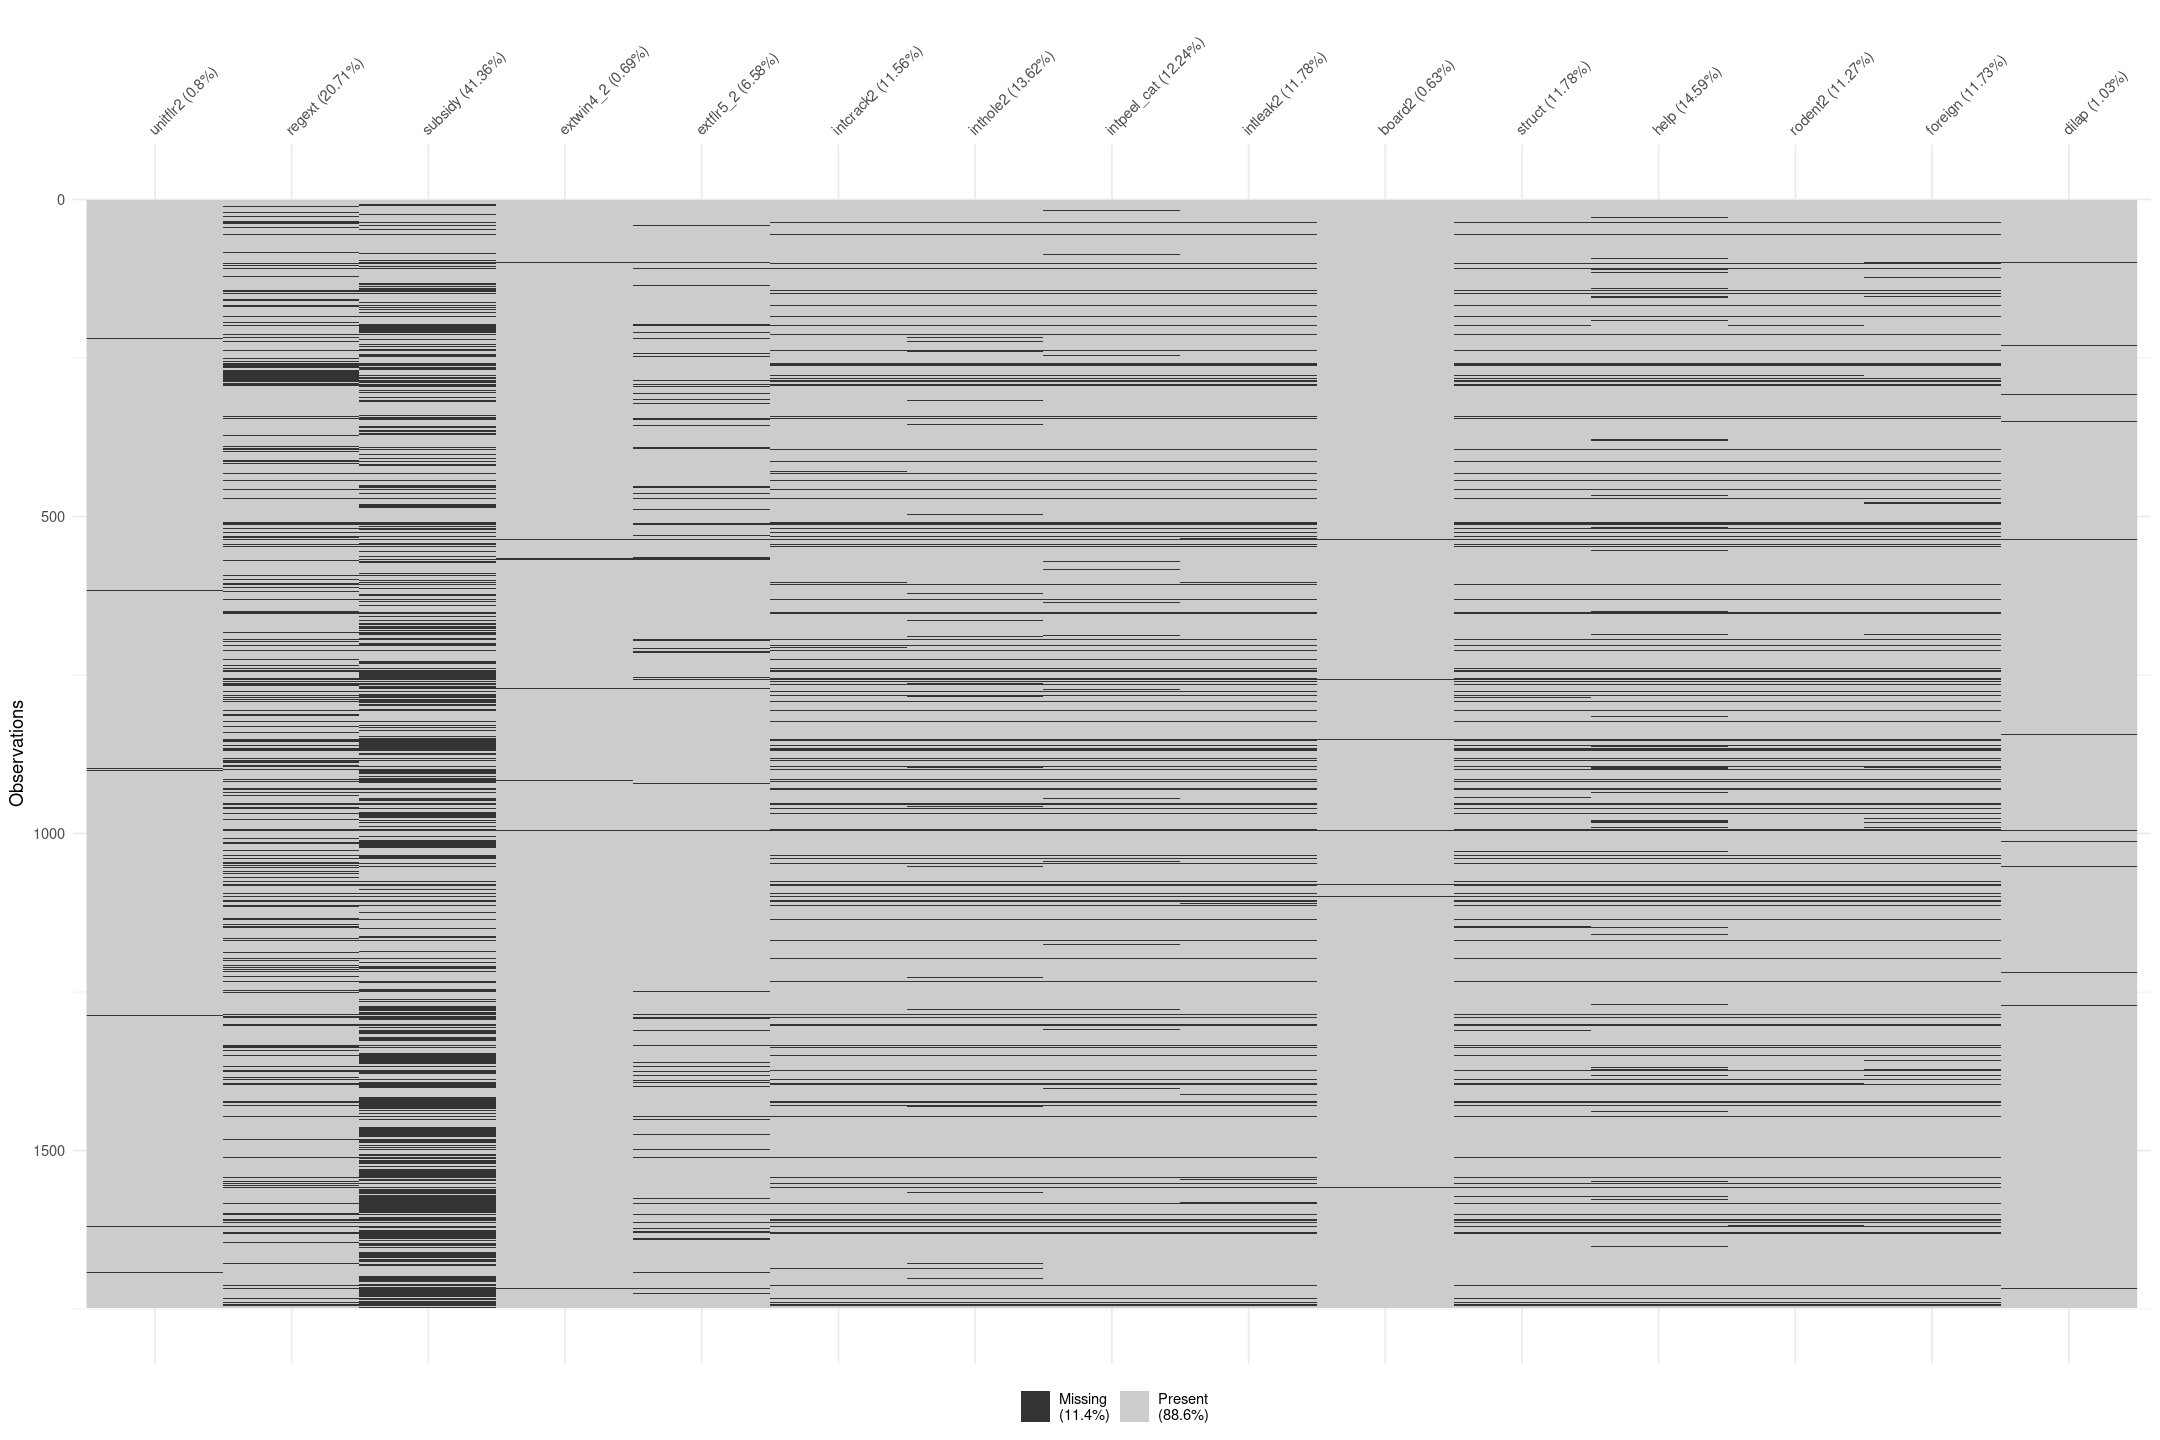

In [141]:
naniar::vis_miss(rodents %>% select_if(~any(is.na(.))))

In [142]:
nrow(rodents)

[1] 1748

In [143]:
Mode <- function(x) names(sort(table(x),decreasing=TRUE)[1])

In [144]:
Mode_frac <- function(x) sort(table(x),decreasing=TRUE)[1] / length(x)

In [145]:
rbind(
mean=rodents %>% summarise_all(mean),
median=rodents %>% summarise_all(median),
min=rodents %>% summarise_all(min),
max=rodents %>% summarise_all(max),
most_common = rodents %>% summarise_all(Mode),
most_common_frac = rodents %>% summarise_all(Mode_frac) %>% mutate_all(scales::percent),
na_frac = rodents %>% mutate_all(is.na) %>% summarise_all(mean) %>% mutate_all(scales::percent)
)

borough          numunits        stories         
mean             2.76716247139588 7.6870709382151 3.55949656750572
median           3                10              4               
min              1                1               1               
max              5                12              7               
most_common      2                12              1               
most_common_frac 30%              20%             25%             
na_frac          0%               0%              0%              
                 race             personrm          housewgt        
mean             2.24313501144165 0.662122425629291 189.875309050343
median           2                0.5               193.35768       
min              1                0.11              13.47395        
max              7                4                 317.95175       
most_common      1                0.33              16.25516        
most_common_frac 42%              16%               2%              
na_frac          0%               0%                0%              
                 sequenceno      under6           cd               unitflr2
mean             494756.45194508 1.18535469107551 29.2711670480549 NA      
median           487483.5        1                31               NA      
min              403             1                1                NA      
max              996768          5                55               NA      
most_common      403             1                50               2       
most_common_frac 0%              86%              4%               30%     
na_frac          0%              0%               0%               1%      
                 regext totincom2        subsidy housing         
mean             NA     56836.6493135011 NA      2.79061784897025
median           NA     37840            NA      3               
min              NA     -18200           NA      1               
max              NA     883946           NA      4               
most_common      0      0                0       2               
most_common_frac 43%    3%               50%     36%             
na_frac          21%    0%               41%     0%              
                 poverty           povertyx2         extwin4_2 extflr5_2
mean             0.205949656750572 0.380434782608696 NA        NA       
median           0                 0                 NA        NA       
min              0                 0                 NA        NA       
max              1                 1                 NA        NA       
most_common      0                 0                 0         0        
most_common_frac 79%               62%               96%       90%      
na_frac          0%                0%                1%        7%       
                 intcrack2 inthole2 intpeel_cat intleak2 duration        
mean             NA        NA       NA          NA       12.1681922196796
median           NA        NA       NA          NA       7               
min              NA        NA       NA          NA       0               
max              NA        NA       NA          NA       79              
most_common      0         0        0           0        1               
most_common_frac 78%       81%      74%         72%      10%             
na_frac          12%       14%      12%         12%      0%              
                 board2 struct old               help rodent2 foreign dilap
mean             NA     NA     0.617848970251716 NA   NA      NA      NA   
median           NA     NA     1                 NA   NA      NA      NA   
min              NA     NA     0                 NA   NA      NA      NA   
max              NA     NA     1                 NA   NA      NA      NA   
most_common      0      1      1                 1    0       0       0    
most_common_frac 84%    65%    62%               69%  68%     46%     96%  
na_frac          1%     12%    0%                15%  11%     12%     1%   
         

## Effect of Race

Build a logistic regression model to predict the presence of rodents (the variable `rodent2` in the dataset) given indicators for the ethnic groups (`race`).
Combine categories as appropriate.
Discuss the estimated coefficients in the model.

From the [documentation](https://github.com/avehtari/ROS-Examples/raw/master/Rodents/rodents.doc)

Householder race/ethnicity:

1. White (non-hispanic) 
2. Black (non-hispanic) 
3. Puerto Rican 
4. Other Hispanic 
5. Asian/Pacific Islander 
6. Amer-Indian/Native Alaskan 
7. Two or more races

In [146]:
rodents <- rodents %>% filter(!is.na(rodent2))

In [147]:
rodents <- rodents %>%
mutate(race=factor(race, labels=c("White", "Black", "Puerto Rican", "Other Hispanic", "Asian/Pacific Islander", "Amer-Indian/Native Alaskan", "Two or more races")))

The last 2 grouping are too small to get reasonable estimates on

In [148]:
rodents %>% group_by(race) %>% summarise(n=n(), p=mean(rodent2))

race                       n   p         
1 White                      633 0.09952607
2 Black                      404 0.30693069
3 Puerto Rican               139 0.36690647
4 Other Hispanic             223 0.44843049
5 Asian/Pacific Islander     139 0.20143885
6 Amer-Indian/Native Alaskan   6 0.16666667
7 Two or more races            7 0.14285714

In [149]:
rodents <- rodents %>%
mutate(race_group = fct_collapse(race, Other = c("Amer-Indian/Native Alaskan", "Asian/Pacific Islander", "Two or more races")))

rodents %>% count(race, race_group)

race                       race_group     n  
1 White                      White          633
2 Black                      Black          404
3 Puerto Rican               Puerto Rican   139
4 Other Hispanic             Other Hispanic 223
5 Asian/Pacific Islander     Other          139
6 Amer-Indian/Native Alaskan Other            6
7 Two or more races          Other            7

In [150]:
fit_rodent_race <- stan_glm(rodent2 ~ race_group, family=binomial(link="logit"), data=rodents, refresh=0)

In [151]:
fit_rodent_race

stan_glm
 family:       binomial [logit]
 formula:      rodent2 ~ race_group
 observations: 1551
 predictors:   5
------
                         Median MAD_SD
(Intercept)              -2.2    0.1  
race_groupBlack           1.4    0.2  
race_groupPuerto Rican    1.7    0.2  
race_groupOther Hispanic  2.0    0.2  
race_groupOther           0.8    0.3  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

We could use the divide by 4 rule, but because many of the probabilities are substantially below 50% it may be better to do a direct prediction.

The coefficint is substantially higher when the owners are "Other Hispanic" or "Puerto Rican", followed by "Black", then "Other", than "White".

The difference between the highest and lowest is 9 in 20 households, down to 2 in 20 households.

In [152]:
predict(fit_rodent_race, type="response",
        newdata=data.frame(race_group=c("White", "Black", "Puerto Rican", "Other Hispanic", "Other"))) %>%
purrr::map(scales::percent)

$`1`
[1] "10%"

$`2`
[1] "31%"

$`3`
[1] "37%"

$`4`
[1] "45%"

$`5`
[1] "20%"

Even after constructing 95% uncertainty intervals the differences are stark.

In [153]:
posterior_epred(fit_rodent_race, type="response",
        newdata=data.frame(race_group=c("White", "Black", "Puerto Rican", "Other Hispanic", "Other"))) %>%
apply(2, quantile, probs=c(0.025, 0.975)) %>%
as.data.frame %>%
mutate_all(scales::percent)

1     2     3   4   5  
2.5%  7.7%  26.3% 29% 38% 14%
97.5% 12.4% 35.2% 45% 52% 27%

## Building a model

Add to your model some other potentially relevant predictors describing the apartment, building, and community district.
Build your model using the general principles explained in Section 12.7.
Discuss the coefficients for the ethnicity indicators in your model.

Let's put labels on the factors [from the documentation]([documentation](https://github.com/avehtari/ROS-Examples/raw/master/Rodents/rodents.doc))

In [154]:
rodents <- rodents %>% 
mutate(borough=factor(borough, labels=c('Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island')),
       numunits=factor(numunits, labels=c("1 unit", "1 unit w/business", "2 units", "2 units w/business", "3 units", "4-5 units", "6-9 units", "10-12 units", "13-19 units", "20-49 units", "50-99 units", "100+ units")),
       cd = factor(cd, labels=c('Mott Haven/Hunts Point','Morrisania/East Tremont','Highbridge/S.Concourse','Univ.Hights/Fordham','Kings.Hights/Mosholu','Riverdale/Kingsbridge','Soundview/Parkchester','Throgs Neck/Co-op City','Pelham Parkway','Williamsbridge/Baychester','Williamsburg/Greenpoint','Brooklyn Hoghts/Fort Green','Bedford Stuyvesant','Bushwick','East New York/Starret City','Park Slope/Carroll Gardens','Sunset Park','N.Crown Heights/Pros.Heights','South Crown Heights','Bay Ridge','Bensonhurst','Borough Park','Coney Island','Flatbush','Sheepshead Bay/Gravsend','Brownsville/Ocean Hill','East Flatbush','Flatlands/Canarsie','Green.Village/Fin.District','L.East Side/Chinatown','Chealsea/Clinton/Midtown','Stuy.Town/Turtle Bay','Upper West Side','Upper East Side','Morning.Heights/Hamilton Heigh.','Central Harlem','East Harlem','Washington Heights/Inwood','Astoria','Sunnyside/Woodside','Jackson Heights','Elmhurst/Corona','Middle Village/Ridgewood','Forest Hill/Rego Park','Flushing/Whitestone','Hillcrest/Fresh Madows','Kew Gardens/Woodhaven','Howard Beach/S.Ozone Park','Bayside/Little Neck','Jamaica','Bellerose/Rosedale','Rockaways','North Shore','Mid Island','South Shore')),
       stories = factor(stories, labels=c("1-2 stories", "3 stories", "4 stories", "5 stories", "6-10 stories", "11-20 stories", "21+ stories")),
       unitflr2 = factor(unitflr2, labels=c("Basement", "1st", "2nd", "3rd", "4th", "5th", "6th-10th", "11th-20th", "21st-40th", "41st+")),
       housing = factor(housing, labels=c("public", "rent controlled", "owned", "other"))
       )

In [155]:
rodents %>% head()

borough numunits    stories   race           personrm housewgt  sequenceno
24 Bronx   20-49 units 5 stories Other Hispanic 1.00     189.67769 128311    
25 Bronx   20-49 units 5 stories Other Hispanic 1.33     191.49159 948690    
26 Bronx   20-49 units 5 stories Puerto Rican   2.00     189.67769 898054    
27 Bronx   20-49 units 5 stories Other Hispanic 0.67     176.21004 938231    
33 Bronx   13-19 units 4 stories Black          1.00      15.71861 656026    
34 Bronx   13-19 units 4 stories Other Hispanic 1.50     182.99832 482104    
   under6 cd                     unitflr2 regext totincom2 subsidy
24 1      Mott Haven/Hunts Point 3rd      1      43540     0      
25 2      Mott Haven/Hunts Point 3rd      1      15000     0      
26 3      Mott Haven/Hunts Point 3rd      1      10000     0      
27 1      Mott Haven/Hunts Point 3rd      1      28100     0      
33 2      Mott Haven/Hunts Point 2nd      0      18200     0      
34 1      Mott Haven/Hunts Point 3rd      1      57000     0      
   housing         poverty povertyx2 extwin4_2 extflr5_2 intcrack2 inthole2
24 rent controlled 0       0         0         0         0         0       
25 rent controlled 1       1         0         0         0         0       
26 rent controlled 1       1         0         0         0         0       
27 rent controlled 0       0         0         0         0         0       
33 other           1       1         0         0         0         0       
34 rent controlled 0       0         0         0         0         0       
   intpeel_cat intleak2 duration board2 struct old help rodent2 foreign dilap
24 0           0         1       0      1      1   1    0       1       0    
25 0           0         9       0      1      1   1    0       1       0    
26 0           0         3       0      1      1   1    0       1       0    
27 0           0         3       0      1      1   0    0       1       0    
33 1           0        17       1      0      1   1    1       0       0    
34 0           1         8       0      0      1   0    1       1       0    
   black_Mean board2_Mean foreign_Mean help_Mean hispanic_Mean old_Mean
24 0.23       0.26        0.64         0.55      0.74          0.59    
25 0.23       0.26        0.64         0.55      0.74          0.59    
26 0.23       0.26        0.64         0.55      0.74          0.59    
27 0.23       0.26        0.64         0.55      0.74          0.59    
33 0.23       0.26        0.64         0.55      0.74          0.59    
34 0.23       0.26        0.64         0.55      0.74          0.59    
   poverty_Mean povertyx2_Mean pubhous_Mean regext_Mean struct_Mean dilap_Mean
24 0.48         0.73           0.28         0.54        0.43        0.03      
25 0.48         0.73           0.28         0.54        0.43        0.03      
26 0.48         0.73           0.28         0.54        0.43        0.03      
27 0.48         0.73           0.28         0.54        0.43        0.03      
33 0.48         0.73           0.28         0.54        0.43        0.03      
34 0.48         0.73           0.28         0.54        0.43        0.03      
   ownhous_Mean duration_Mean extwin4_2_Mean extflr5_2_Mean intcrack2_Mean
24 0.05         11.6          0.02           0.07           0.22          
25 0.05         11.6          0.02           0.07           0.22          
26 0.05         11.6          0.02           0.07           0.22          
27 0.05         11.6          0.02           0.07           0.22          
33 0.05         11.6          0.02           0.07           0.22          
34 0.05         11.6          0.02           0.07           0.22          
   inthole2_Mean intleak2_Mean vacrate bldg race_group    
24 0.16          0.27          0.05    11   Other Hispanic
25 0.16          0.27          0.05    11   Other Hispanic
26 0.16          0.27          0.05    11   Puerto Rican  
27 0.16          0.27          0.05    11   Other Hispanic
33 0.16          0.27          0.

### Location variables

Borough is categorical, and a little bit geographical

In [156]:
rodents %>% group_by(borough) %>% summarise(n=n(), p=mean(rodent2))

borough       n   p         
1 Bronx         236 0.37711864
2 Brooklyn      457 0.29102845
3 Manhattan     370 0.23783784
4 Queens        406 0.13546798
5 Staten Island  82 0.03658537

We can further group it into Community District, but doing this naievely will overfit.
A more thorough modeling approach would look for external data linked to Community District (geographic factors, socioeconomic factors, proximity to potential rodent sources).

In [157]:
rodents %>% group_by(borough, cd) %>% summarise(n=n(), p=mean(rodent2))

`summarise()` has grouped output by 'borough'. You can override using the `.groups` argument.



borough       cd                              n  p         
1  Bronx         Mott Haven/Hunts Point          23 0.39130435
2  Bronx         Morrisania/East Tremont         22 0.50000000
3  Bronx         Highbridge/S.Concourse          31 0.45161290
4  Bronx         Univ.Hights/Fordham             18 0.72222222
5  Bronx         Kings.Hights/Mosholu            30 0.46666667
6  Bronx         Riverdale/Kingsbridge           25 0.36000000
7  Bronx         Soundview/Parkchester           32 0.18750000
8  Bronx         Throgs Neck/Co-op City          18 0.11111111
9  Bronx         Pelham Parkway                  11 0.18181818
10 Bronx         Williamsbridge/Baychester       26 0.34615385
11 Brooklyn      Williamsburg/Greenpoint         18 0.05555556
12 Brooklyn      Brooklyn Hoghts/Fort Green      20 0.30000000
13 Brooklyn      Bedford Stuyvesant              28 0.21428571
14 Brooklyn      Bushwick                        17 0.58823529
15 Brooklyn      East New York/Starret City      31 0.29032258
16 Brooklyn      Park Slope/Carroll Gardens      25 0.16000000
17 Brooklyn      Sunset Park                     29 0.24137931
18 Brooklyn      N.Crown Heights/Pros.Heights    27 0.37037037
19 Brooklyn      South Crown Heights             34 0.41176471
20 Brooklyn      Bay Ridge                       19 0.10526316
21 Brooklyn      Bensonhurst                     24 0.20833333
22 Brooklyn      Borough Park                    28 0.14285714
23 Brooklyn      Coney Island                    21 0.14285714
24 Brooklyn      Flatbush                        37 0.64864865
25 Brooklyn      Sheepshead Bay/Gravsend         26 0.11538462
26 Brooklyn      Brownsville/Ocean Hill          32 0.40625000
27 Brooklyn      East Flatbush                   14 0.28571429
28 Brooklyn      Flatlands/Canarsie              27 0.29629630
29 Manhattan     Green.Village/Fin.District      41 0.19512195
30 Manhattan     L.East Side/Chinatown           21 0.28571429
31 Manhattan     Chealsea/Clinton/Midtown        37 0.16216216
32 Manhattan     Stuy.Town/Turtle Bay            37 0.02702703
33 Manhattan     Upper West Side                 51 0.11764706
34 Manhattan     Upper East Side                 44 0.04545455
35 Manhattan     Morning.Heights/Hamilton Heigh. 50 0.38000000
36 Manhattan     Central Harlem                  30 0.26666667
37 Manhattan     East Harlem                     13 0.15384615
38 Manhattan     Washington Heights/Inwood       46 0.65217391
39 Queens        Astoria                         35 0.05714286
40 Queens        Sunnyside/Woodside              27 0.14814815
41 Queens        Jackson Heights                 31 0.25806452
42 Queens        Elmhurst/Corona                 30 0.36666667
43 Queens        Middle Village/Ridgewood        43 0.23255814
44 Queens        Forest Hill/Rego Park           20 0.10000000
45 Queens        Flushing/Whitestone             43 0.25581395
46 Queens        Hillcrest/Fresh Madows          26 0.00000000
47 Queens        Kew Gardens/Woodhaven           20 0.05000000
48 Queens        Howard Beach/S.Ozone Park       18 0.00000000
49 Queens        Bayside/Little Neck             27 0.00000000
50 Queens        Jamaica                         56 0.07142857
51 Queens        Bellerose/Rosedale              18 0.11111111
52 Queens        Rockaways                       12 0.00000000
53 Staten Island North Shore                     39 0.07692308
54 Staten Island Mid Island                      14 0.00000000
55 Staten Island South Shore                     29 0.00000000

### Building size

It's interesting that it increases with the number of units, then jumps at 13 and drops.
I wonder if it's a multi-storey kind of thing.

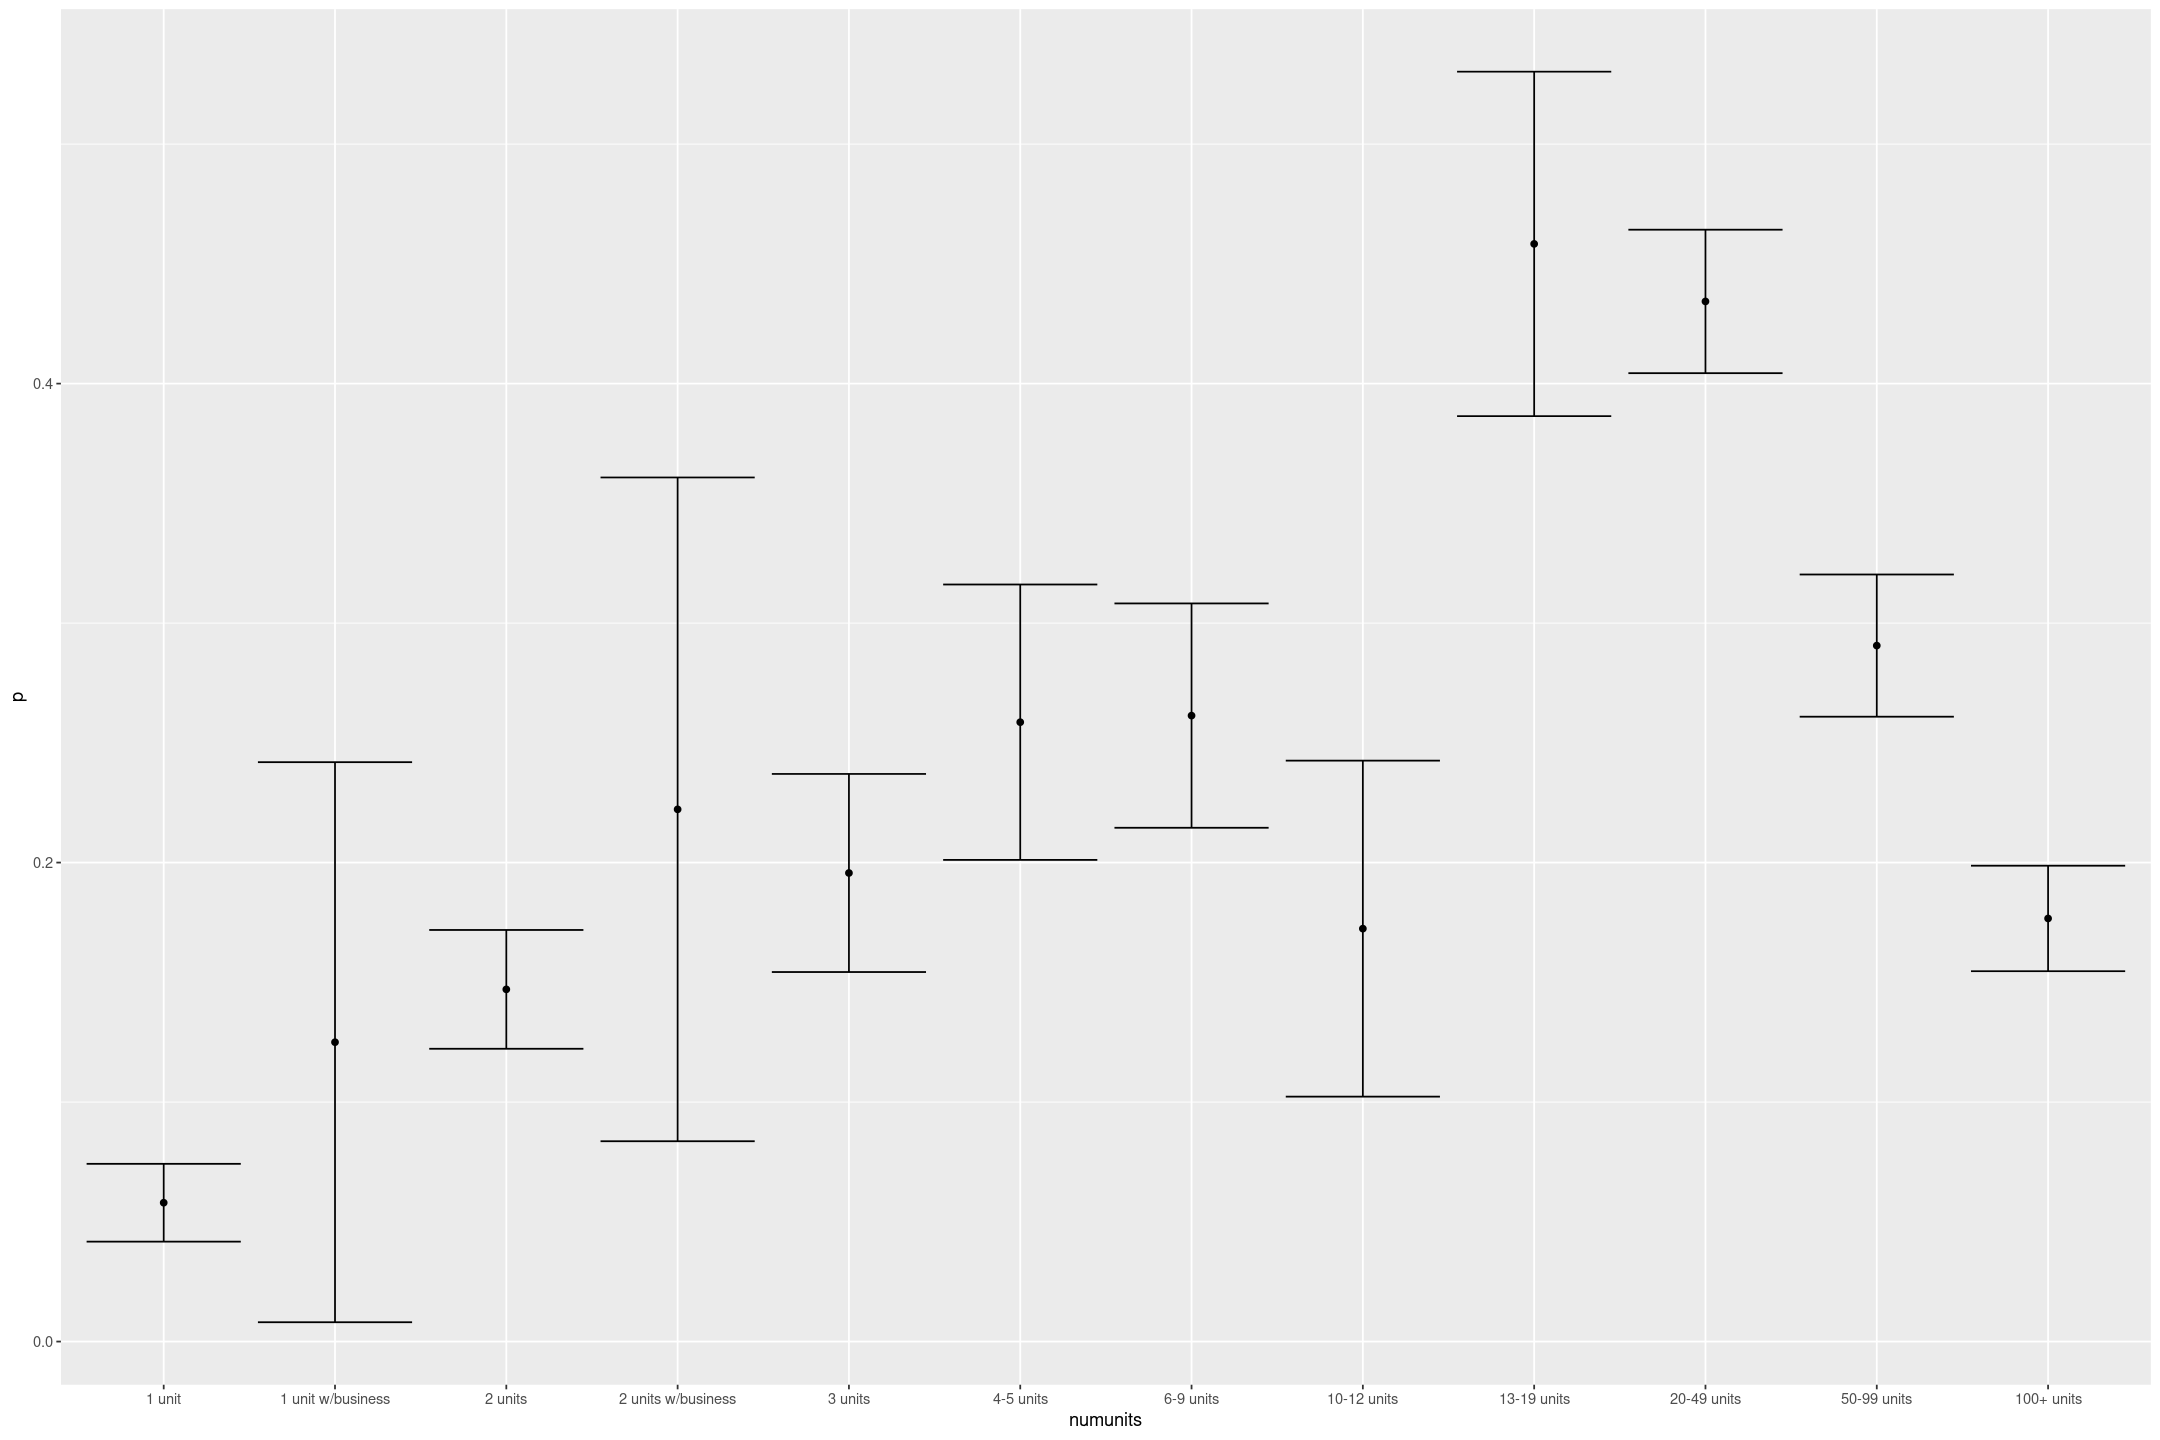

In [158]:
rodents %>% 
group_by(numunits) %>% 
summarise(n=n(), p=mean(rodent2)) %>%
ungroup() %>%
mutate(se = sqrt(p*(1-p)/n)) %>%
gf_point(p ~ numunits) %>%
gf_errorbar(ymin=~p-se, ymax=~p+se)

Interestingly it also increases with the unit floor... up to the 6th-10th floor!

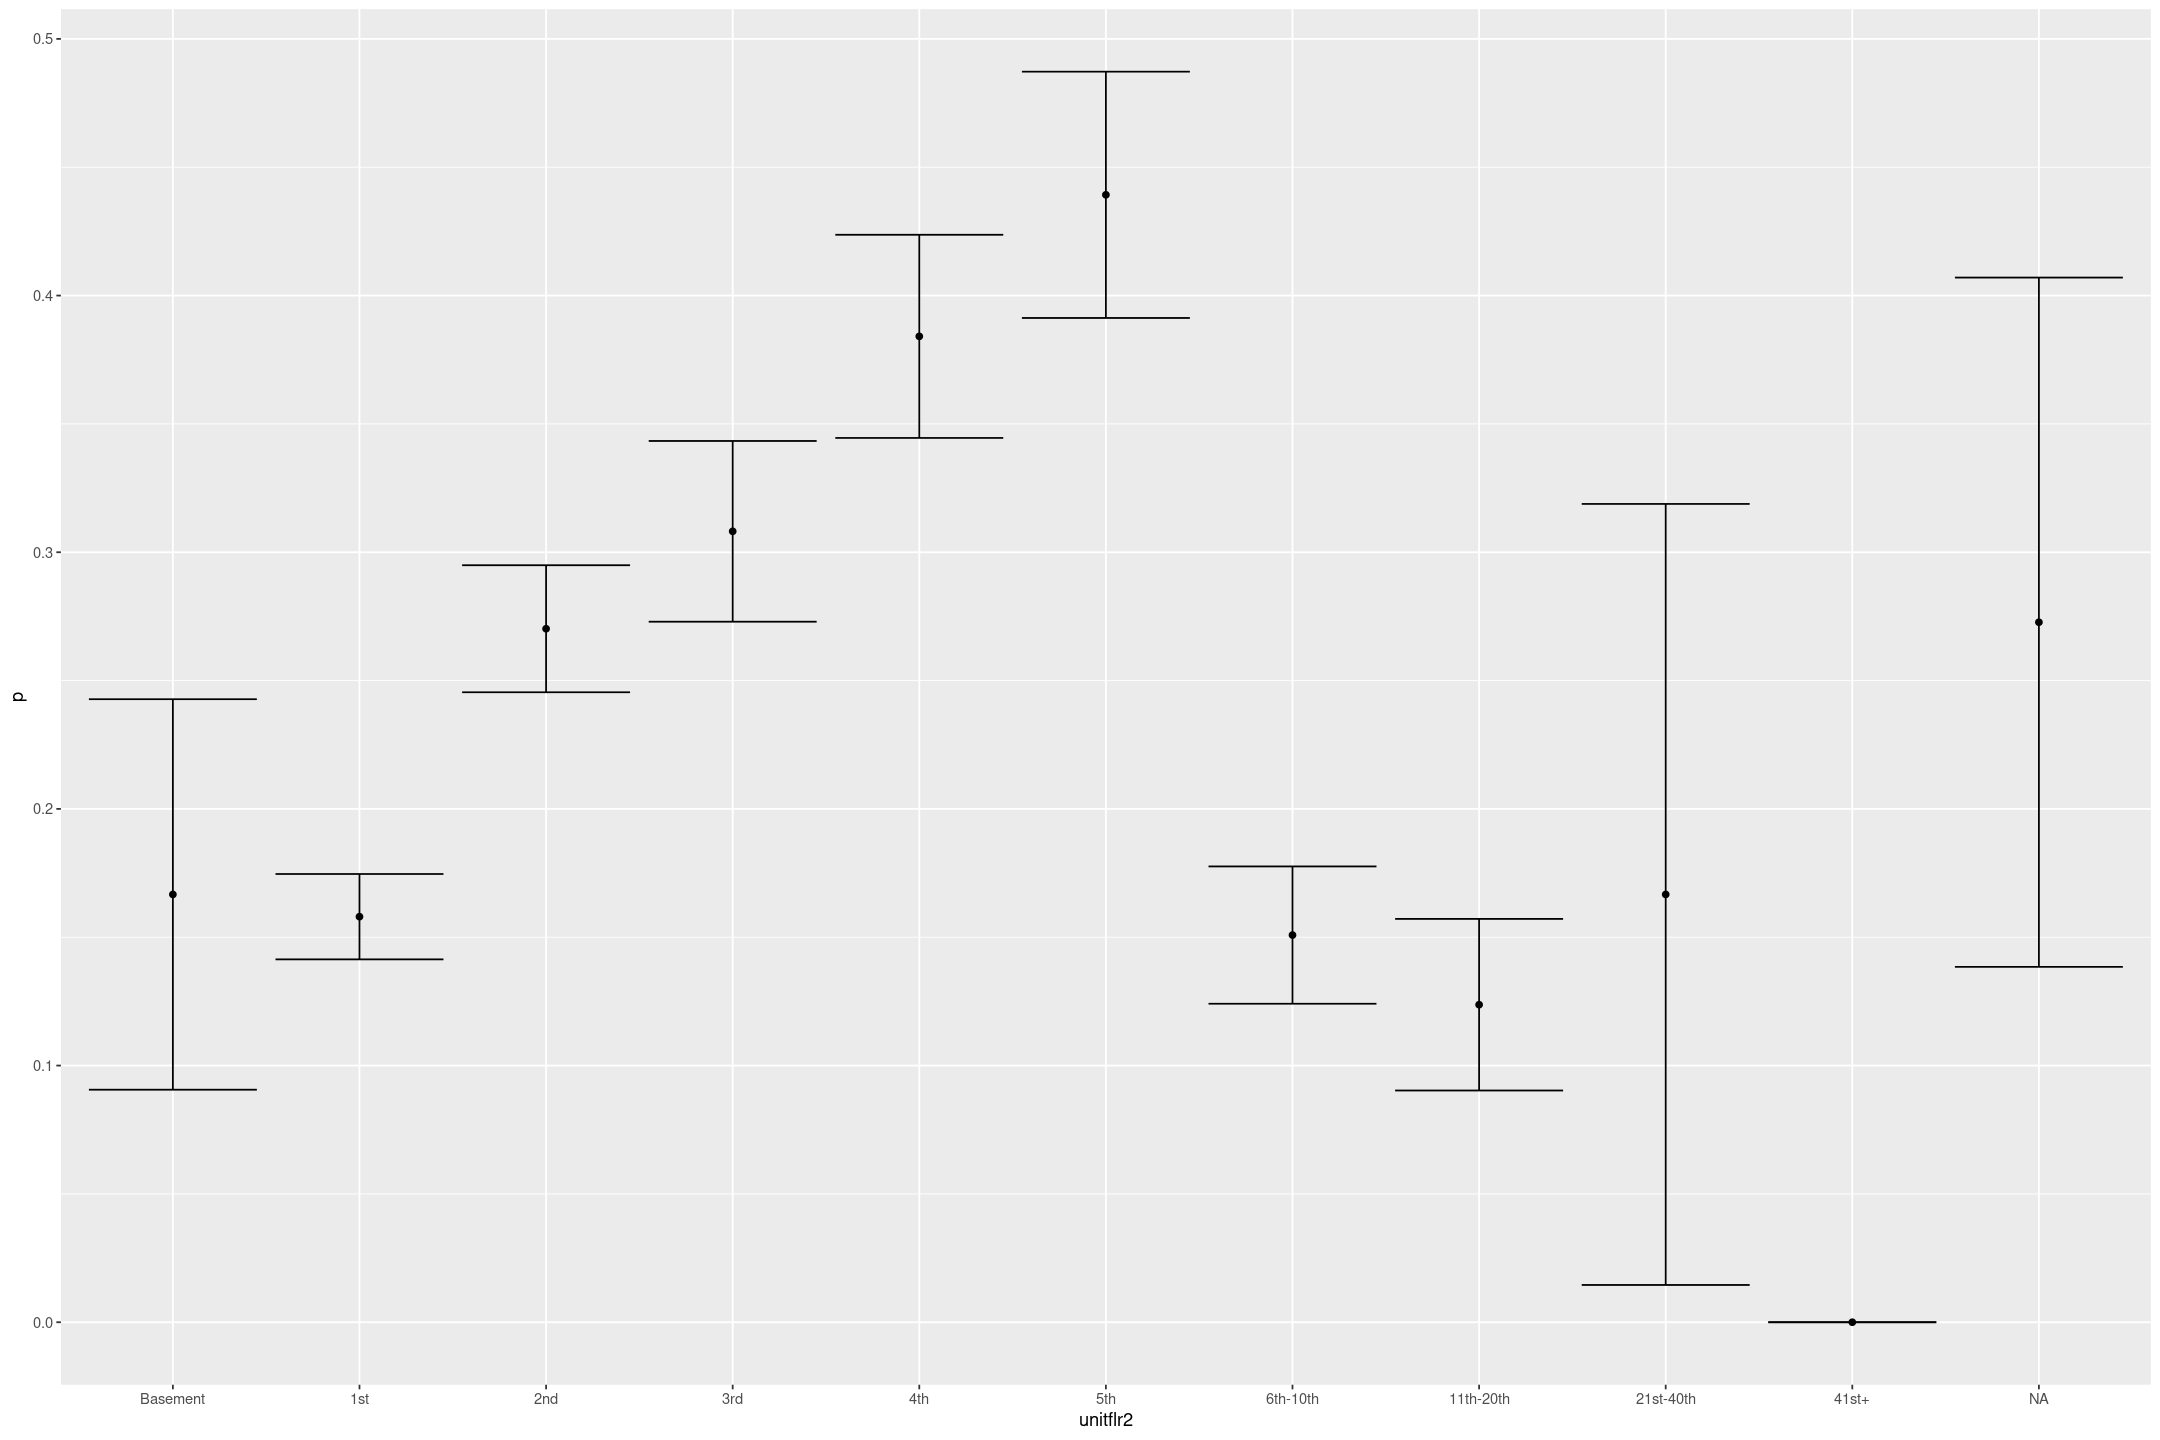

In [159]:
rodents %>% 
group_by(unitflr2) %>% 
summarise(n=n(), p=mean(rodent2)) %>%
ungroup() %>%
mutate(se = sqrt(p*(1-p)/n)) %>%
gf_point(p ~ unitflr2) %>%
gf_errorbar(ymin=~p-se, ymax=~p+se)

And similarly with stories.

In [160]:
rodents %>% 
group_by(stories) %>% 
summarise(n=n(), p=mean(rodent2)) %>%
ungroup() %>%
mutate(se = sqrt(p*(1-p)/n)) %>%
gf_point(p ~ stories) %>%
gf_errorbar(ymin=~p-se, ymax=~p+se)

Let's add some numeric predictors.

First we will impute the unit floor using the number of stories.

In [161]:
(unitflr_by_stories <- rodents %>% group_by(stories) %>% summarise(unitflr2 = median(as.integer(unitflr2), na.rm=T)))

stories       unitflr2
1 1-2 stories   2       
2 3 stories     3       
3 4 stories     4       
4 5 stories     4       
5 6-10 stories  5       
6 11-20 stories 7       
7 21+ stories   8

In [162]:
unitflr_by_stories %>% mutate(stories=as.integer(stories))

stories unitflr2
1 1       2       
2 2       3       
3 3       4       
4 4       4       
5 5       5       
6 6       7       
7 7       8

In [163]:
rodents <- rodents %>% 
mutate(unitflr_int = coalesce(as.integer(unitflr2), unitflr_by_stories$unitflr2[as.integer(stories)]),
       numunits_int = as.integer(numunits),
       unitflr_high = unitflr_int >= 7)

rodents %>%
group_by(unitflr2, unitflr_int, unitflr_high) %>%
count()

unitflr2  unitflr_int unitflr_high n  
1  Basement   1          FALSE         24
2  1st        2          FALSE        481
3  2nd        3          FALSE        322
4  3rd        4          FALSE        172
5  4th        5          FALSE        151
6  5th        6          FALSE        107
7  6th-10th   7           TRUE        179
8  11th-20th  8           TRUE         97
9  21st-40th  9           TRUE          6
10 41st+     10           TRUE          1
11 NA         2          FALSE          4
12 NA         3          FALSE          3
13 NA         5          FALSE          1
14 NA         7           TRUE          2
15 NA         8           TRUE          1

### Personrm

In the data the more people per room the more likely there is a rat.

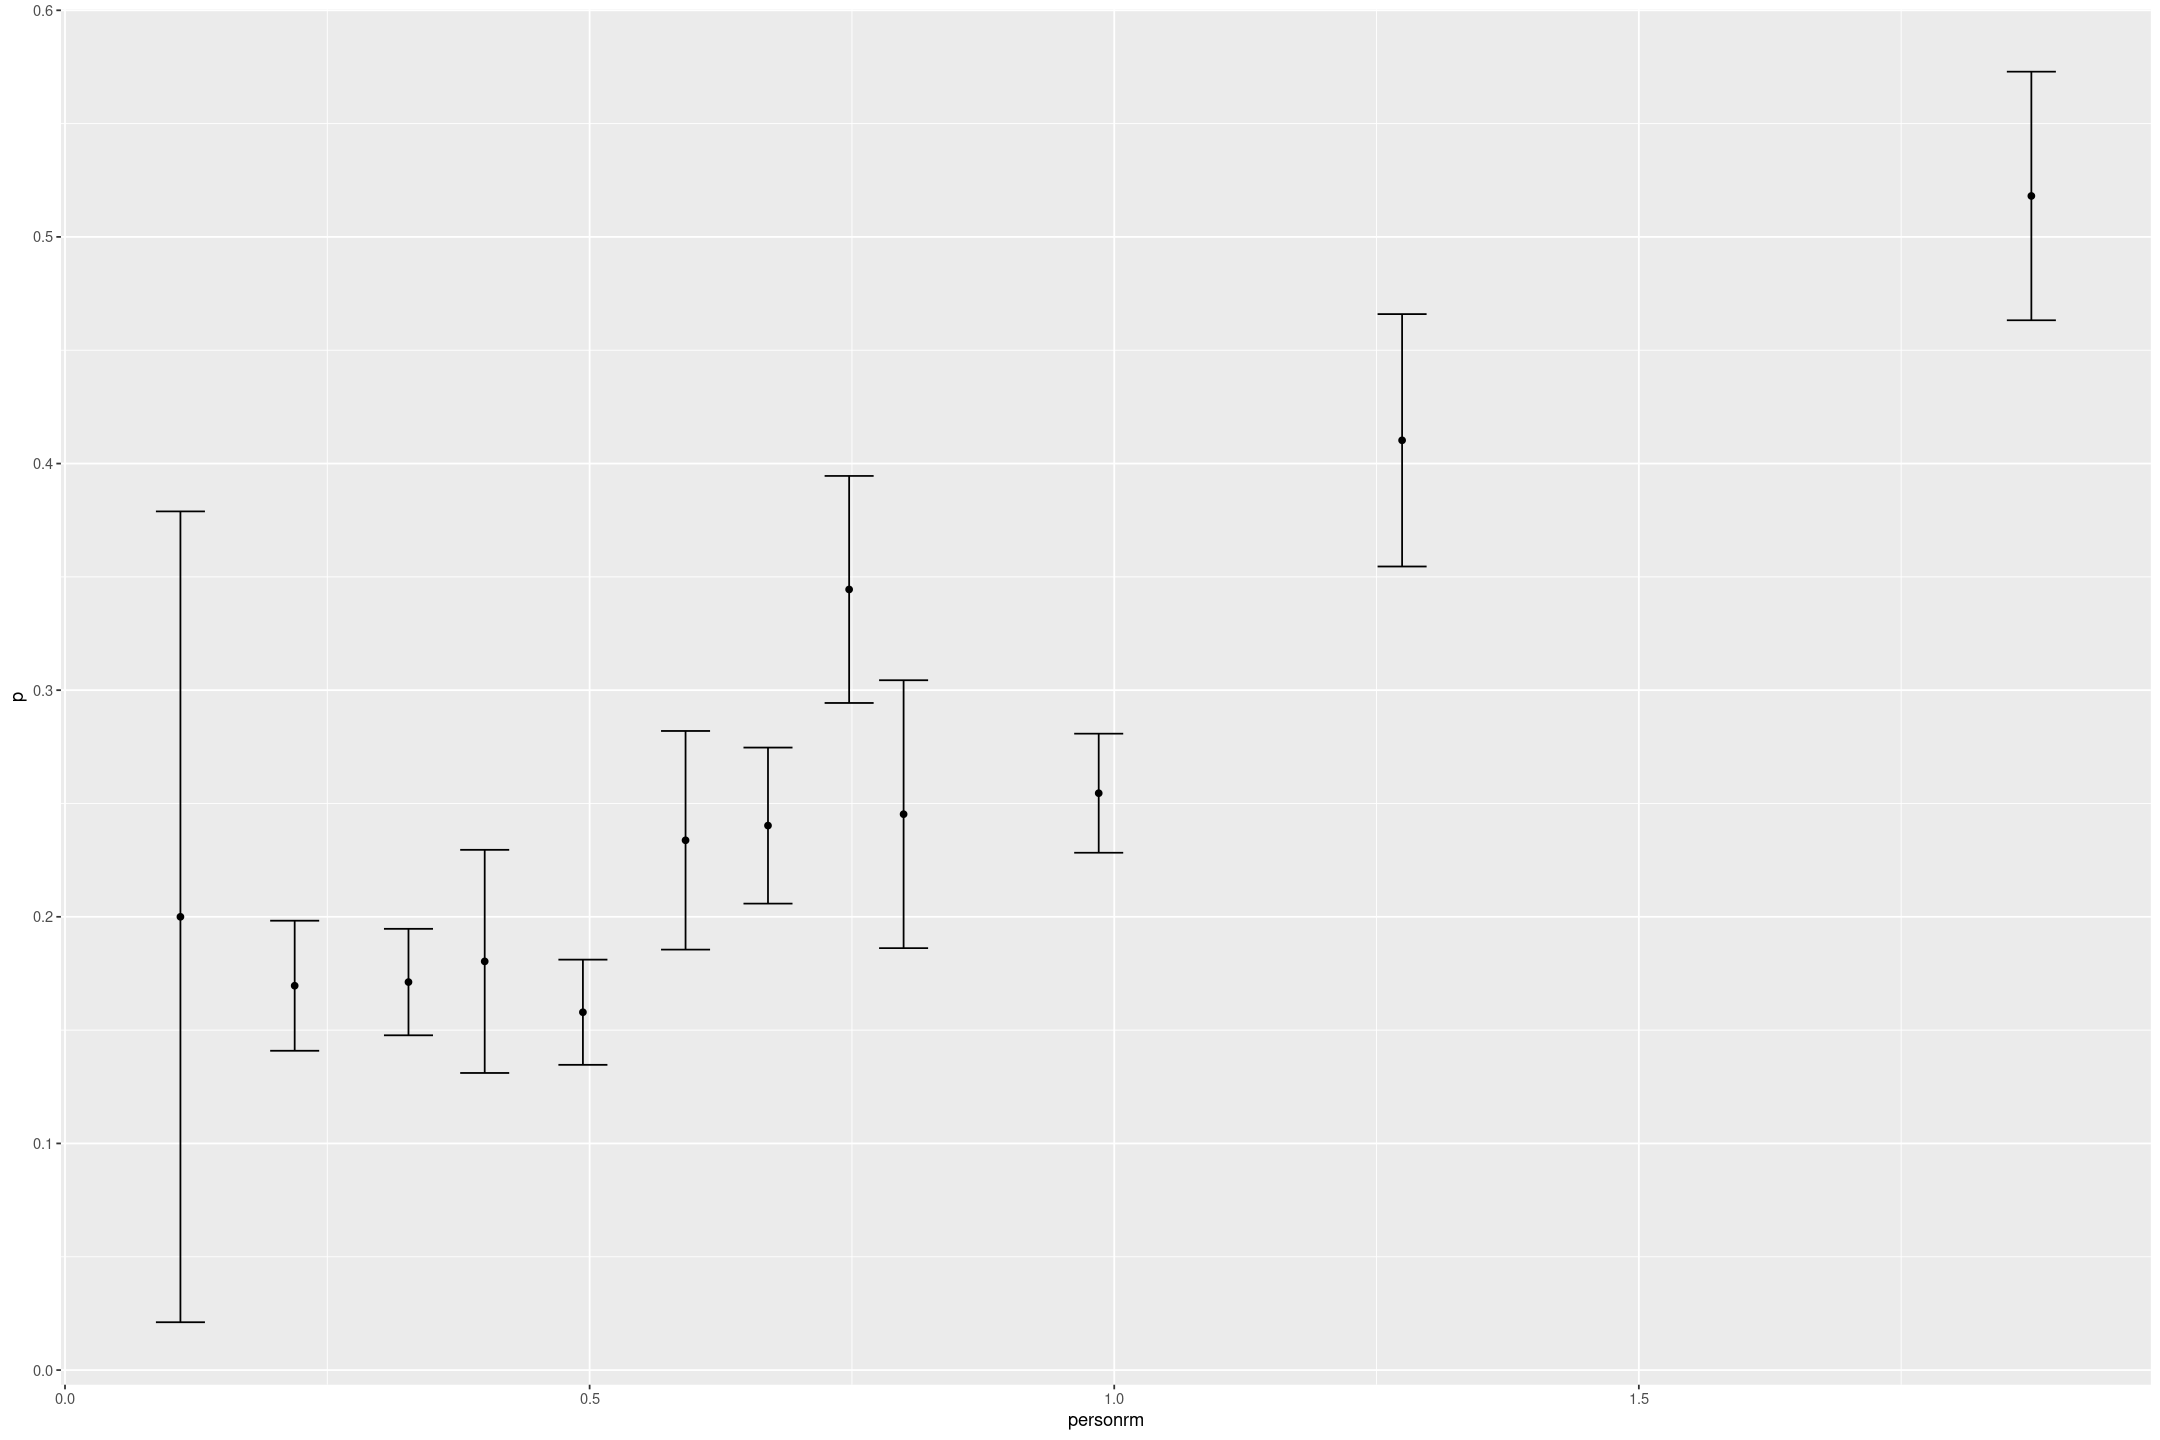

In [164]:
rodents %>% 
mutate(personrm_quantile = cut(personrm, unique(quantile(personrm, seq(0, 1, length.out=15))))) %>%
group_by(personrm_quantile) %>%
summarise(n=n(), p=mean(rodent2), personrm=mean(personrm)) %>%
ungroup() %>%
mutate(se = sqrt(p*(1-p)/n)) %>%
gf_point(p ~ personrm) %>%
gf_errorbar(ymin=~p-se, ymax=~p+se)

### Personrm

In the data the more people per room the more likely there is a rat.

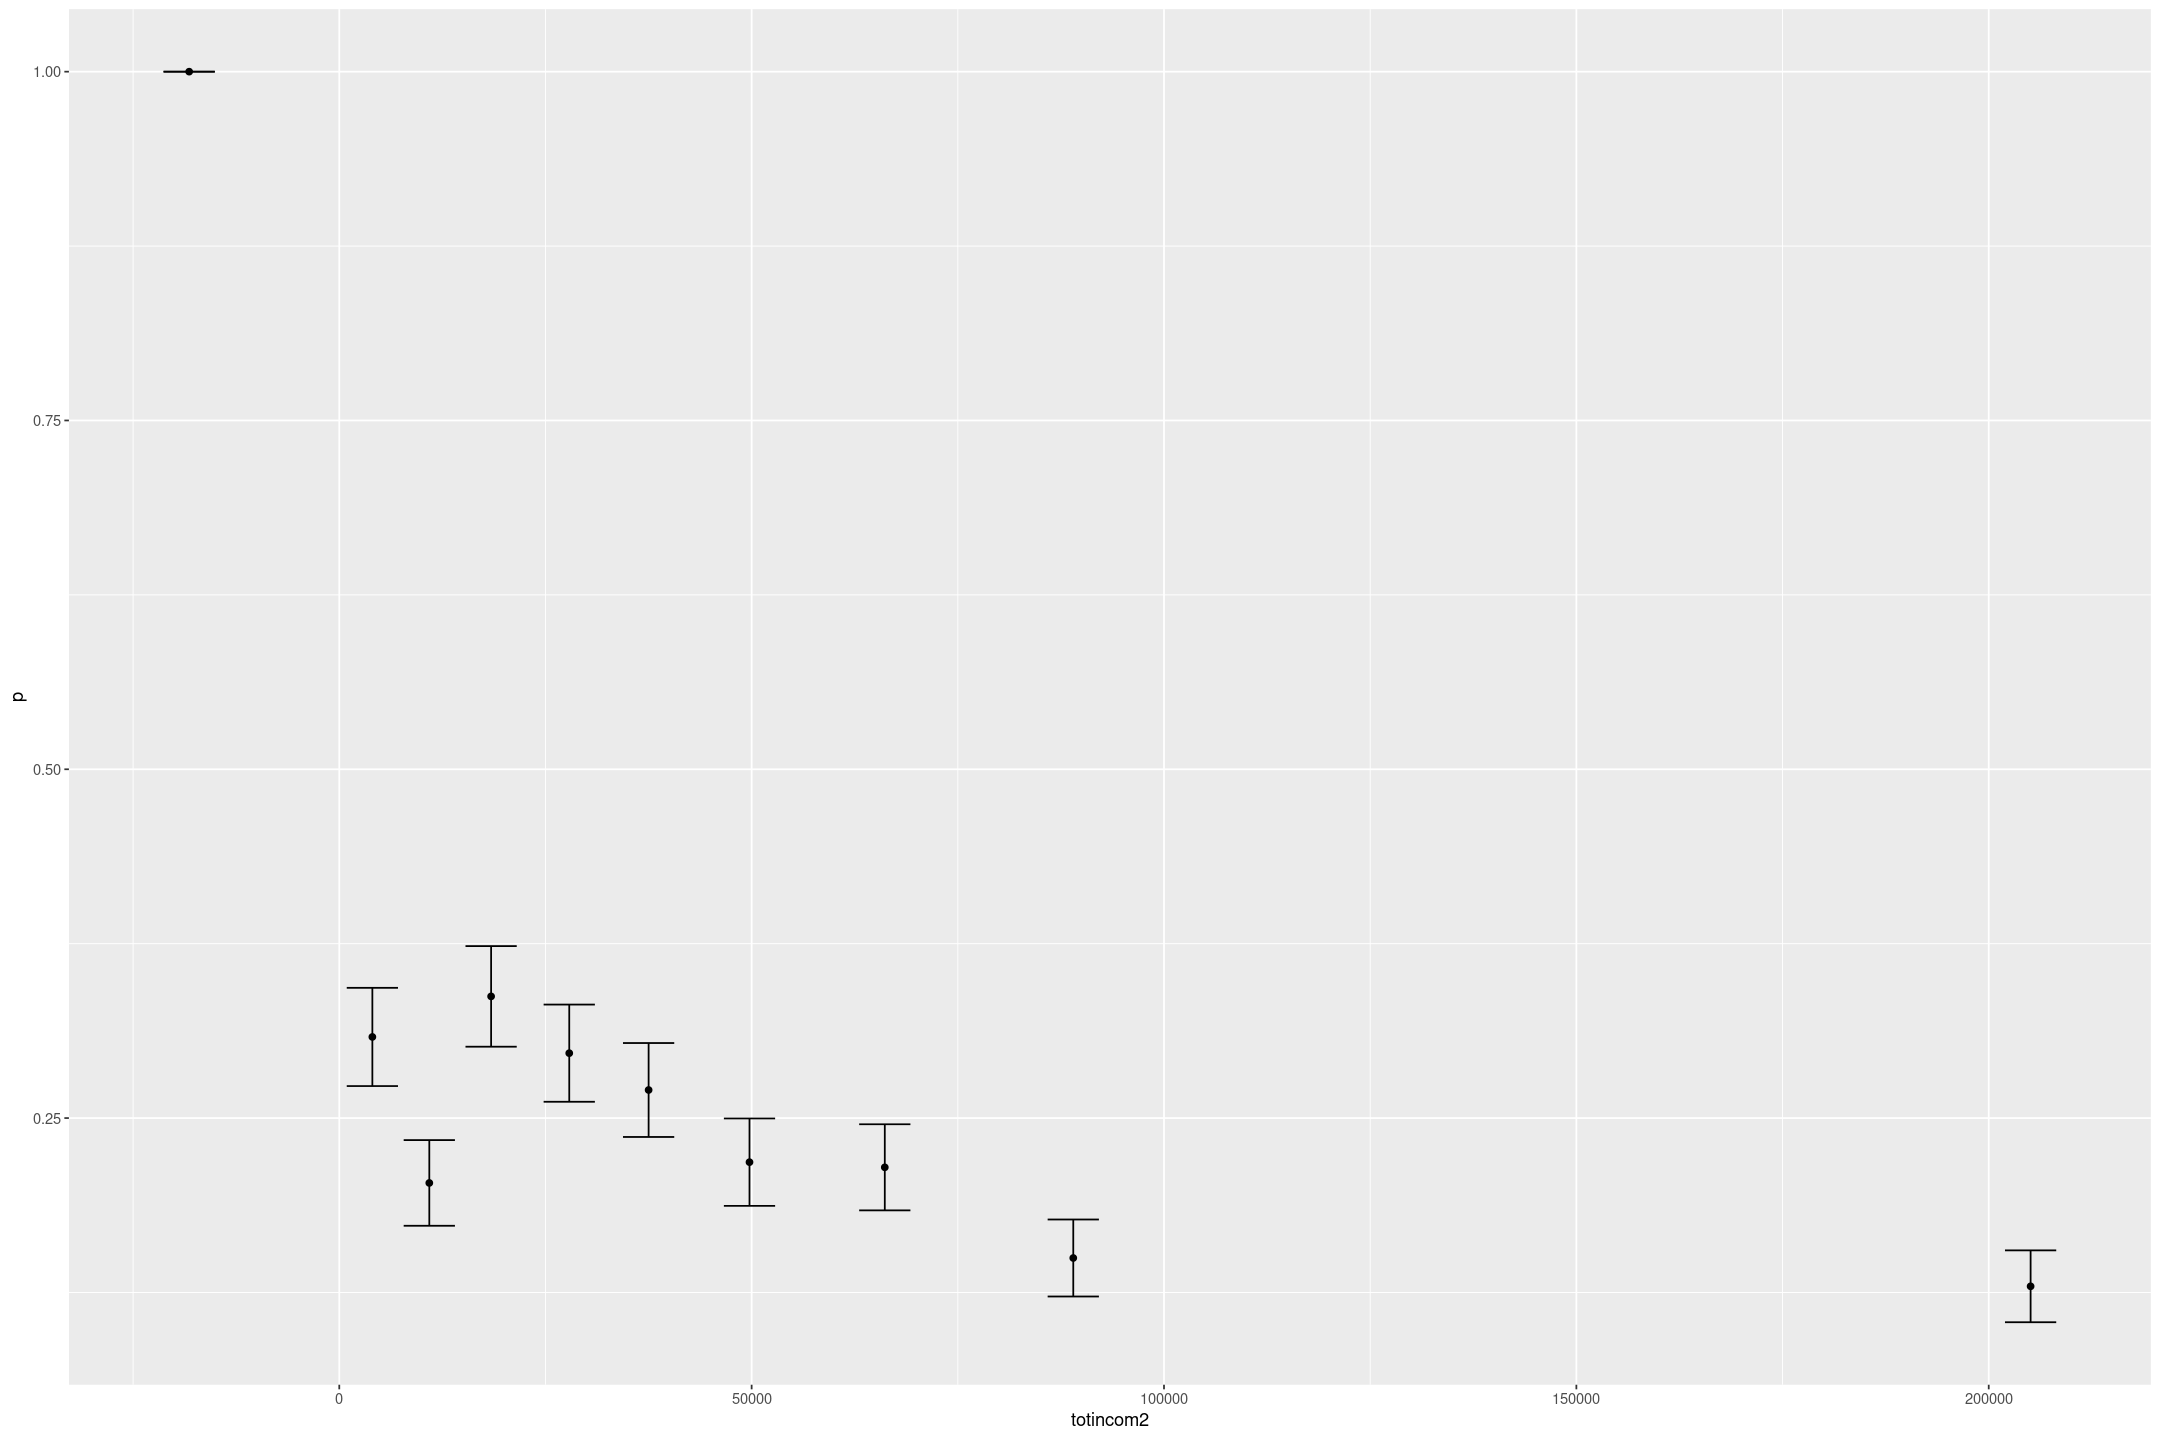

In [165]:
rodents %>% 
mutate(quantile = cut(totincom2, unique(quantile(totincom2, seq(0, 1, length.out=10))))) %>%
group_by(quantile) %>%
summarise(n=n(), p=mean(rodent2), totincom2=mean(totincom2)) %>%
ungroup() %>%
mutate(se = sqrt(p*(1-p)/n)) %>%
gf_point(p ~ totincom2) %>%
gf_errorbar(ymin=~p-se, ymax=~p+se)

Some have a zero or negative income

In [166]:
rodents %>% count(totincom2 <= 0)

totincom2 <= 0 n   
1 FALSE          1506
2  TRUE            45

### Personrm

In the data the more people per room the more likely there is a rat.

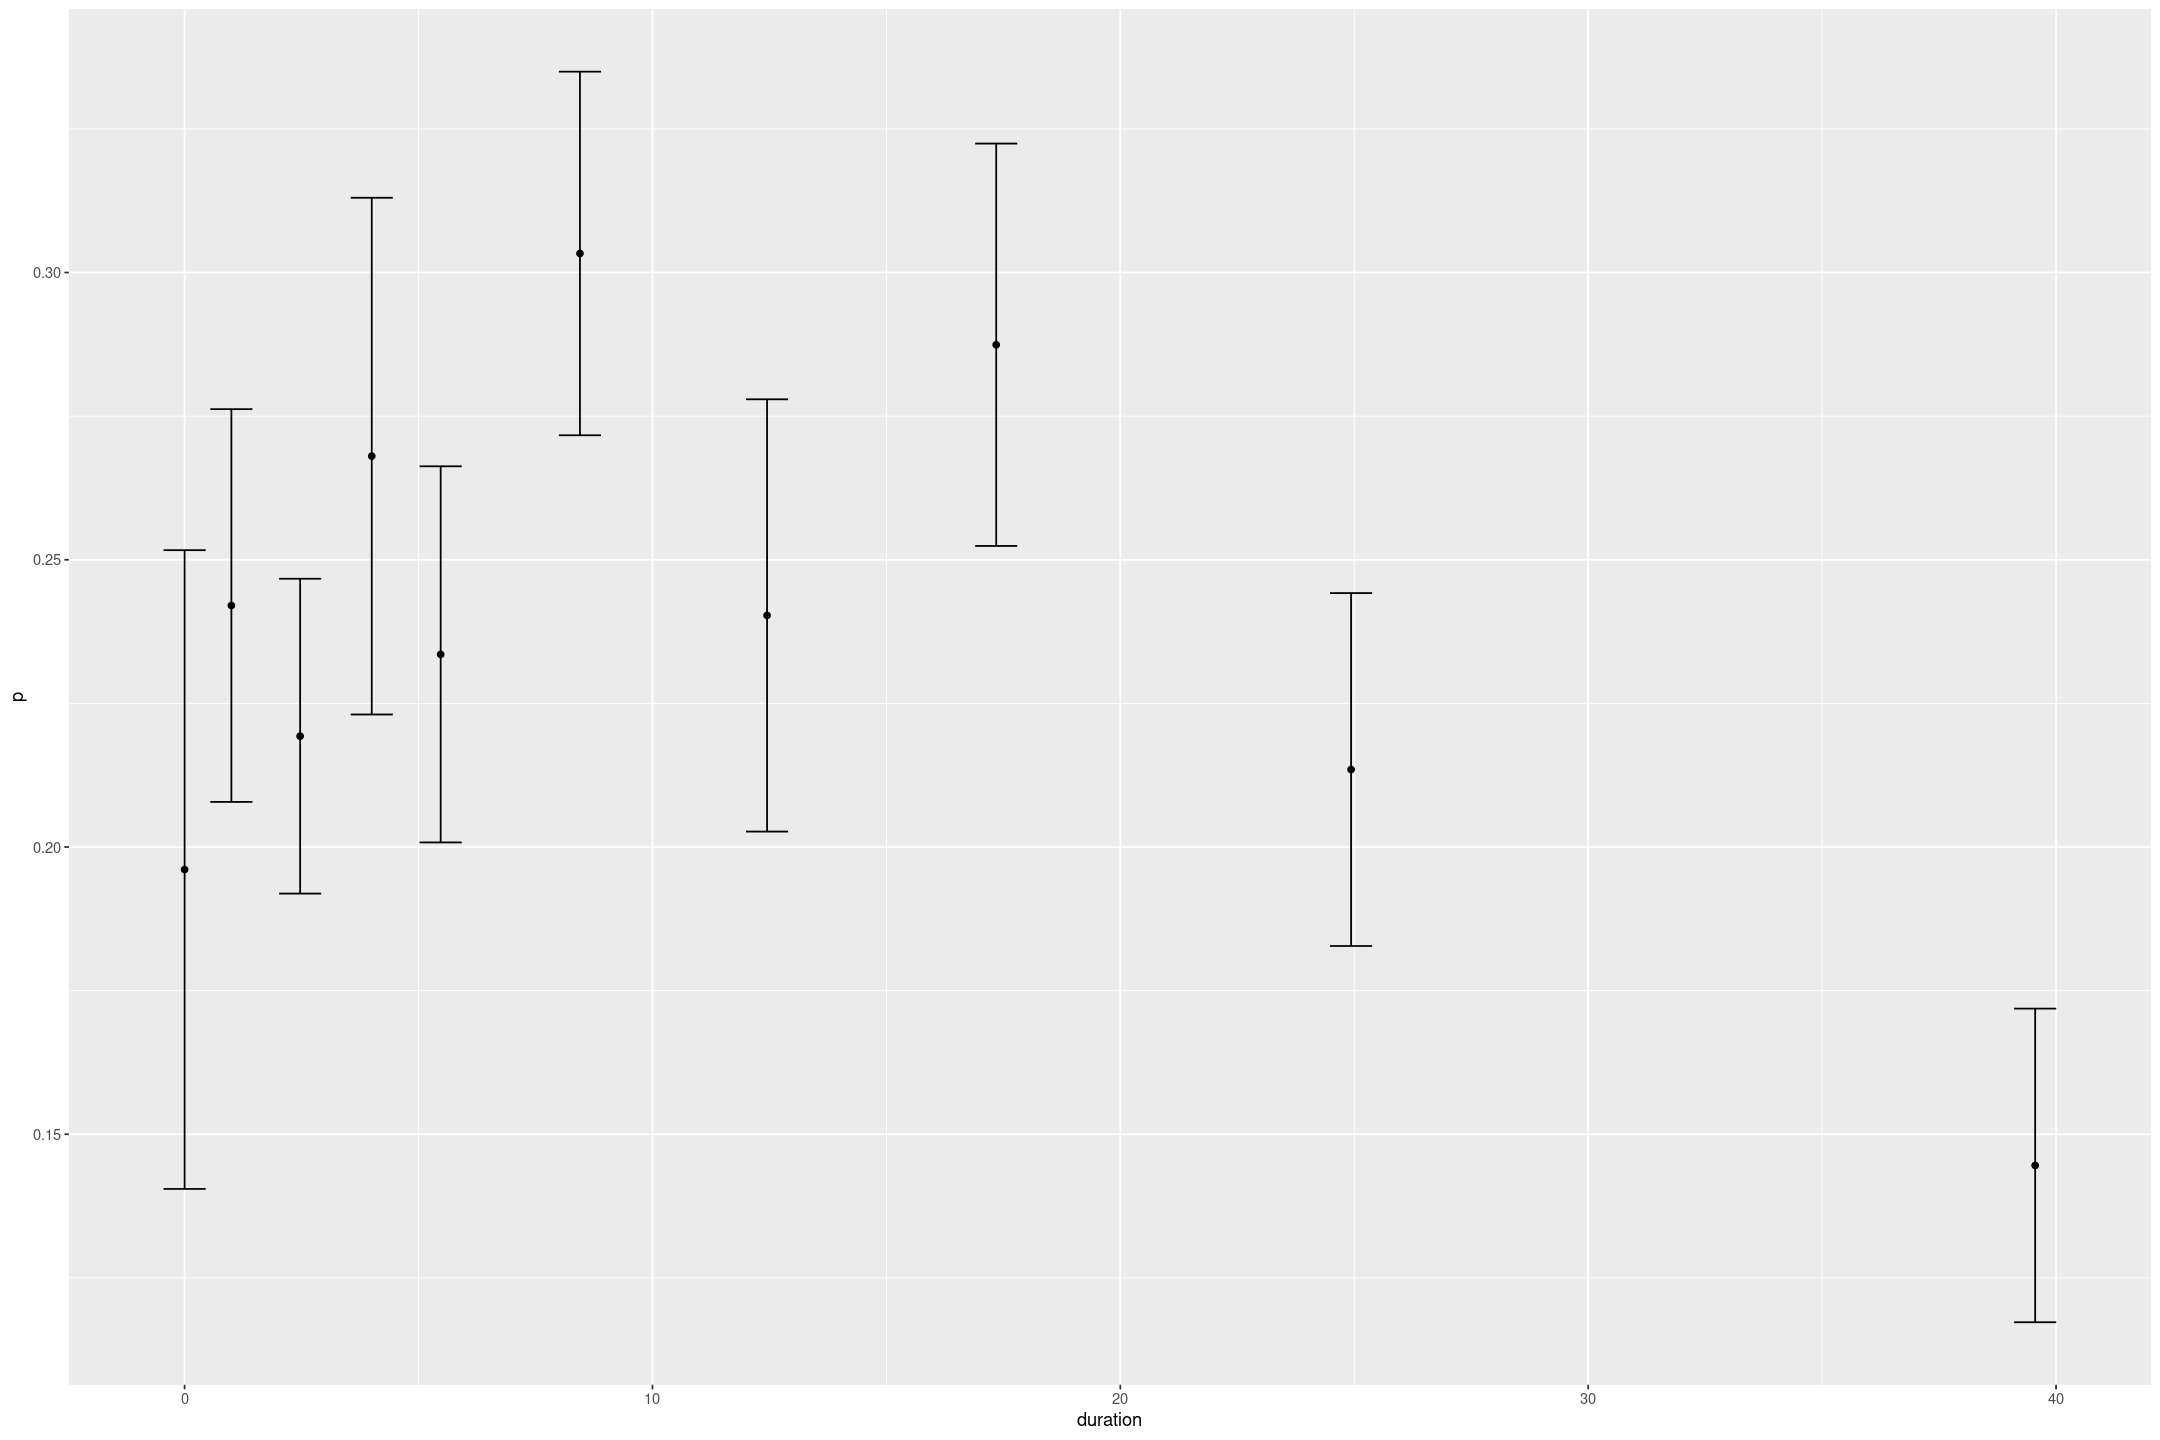

In [167]:
rodents %>% 
mutate(quantile = cut(duration, unique(quantile(duration, seq(0, 1, length.out=10))))) %>%
group_by(quantile) %>%
summarise(n=n(), p=mean(rodent2), duration=mean(duration)) %>%
ungroup() %>%
mutate(se = sqrt(p*(1-p)/n)) %>%
gf_point(p ~ duration) %>%
gf_errorbar(ymin=~p-se, ymax=~p+se)

Something seems to qualitatively change at 20 years (but perhaps it's correlated with one of the other factors)

In [168]:
rodents %>% count(duration  >= 20)

duration >= 20 n   
1 FALSE          1180
2  TRUE           371

### Under 6

In [169]:
rodents %>% 
group_by(under6) %>%
summarise(n=n(), p=mean(rodent2)) %>%
ungroup() %>%
mutate(se = sqrt(p*(1-p)/n)) %>%
gf_point(p ~ under6) %>%
gf_errorbar(ymin=~p-se, ymax=~p+se)

Warning message:
“Removed 1 rows containing missing values (geom_point).”


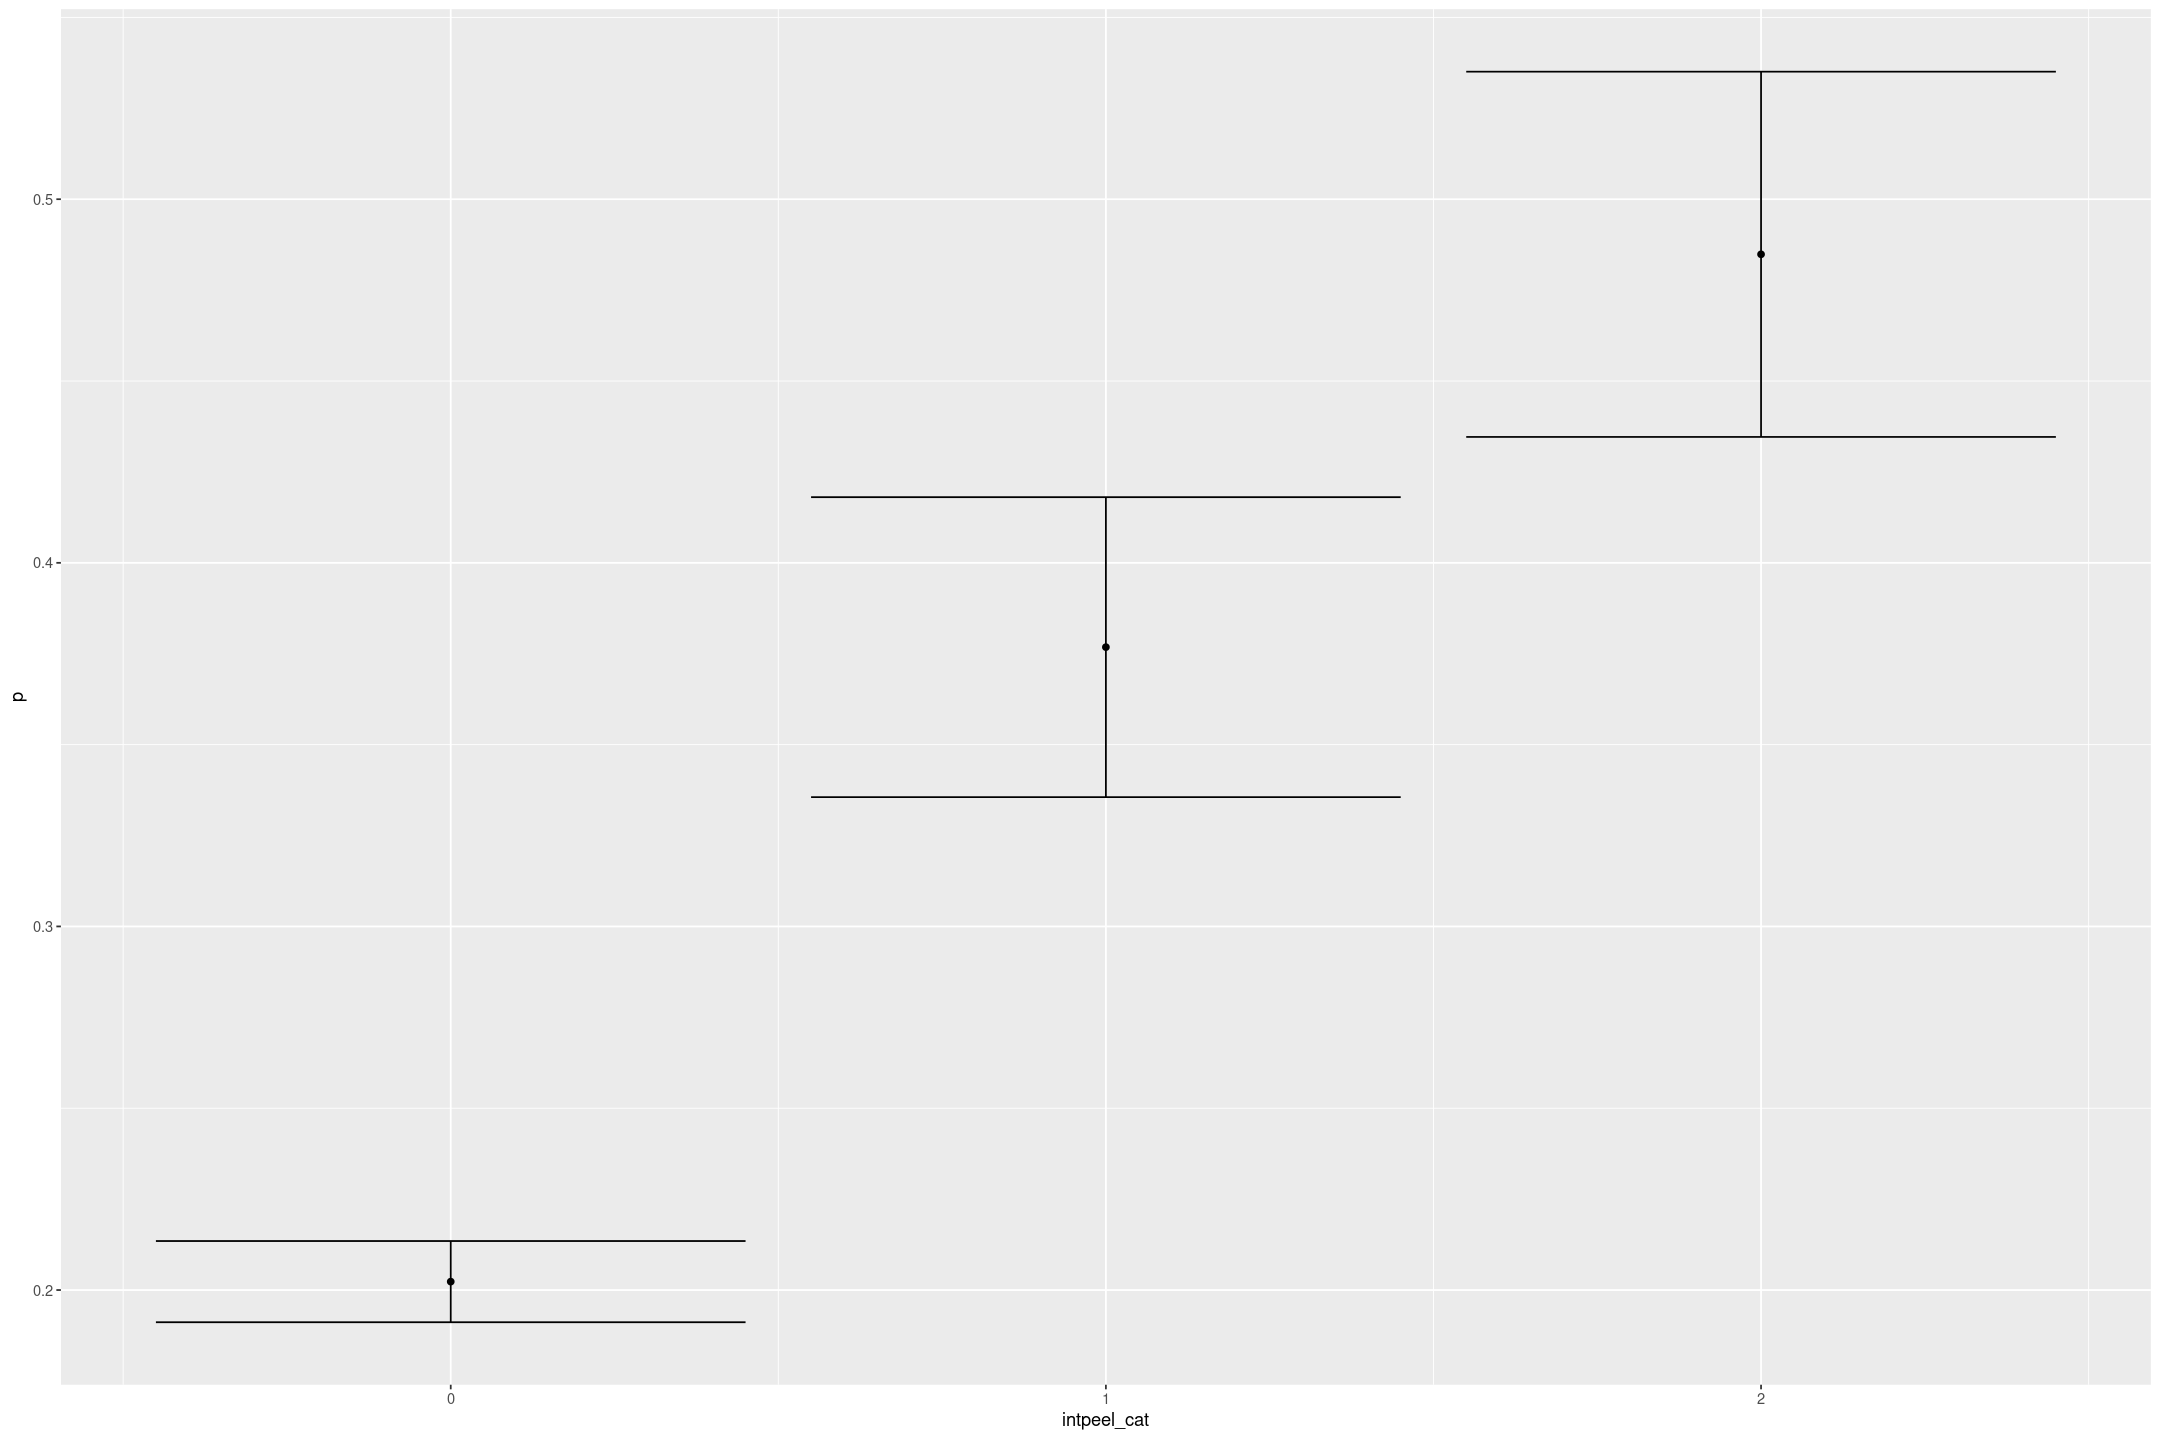

In [170]:
rodents %>% 
group_by(intpeel_cat) %>%
summarise(n=n(), p=mean(rodent2)) %>%
ungroup() %>%
mutate(se = sqrt(p*(1-p)/n)) %>%
gf_point(p ~ intpeel_cat) %>%
gf_errorbar(ymin=~p-se, ymax=~p+se)

We won't use foreign

In [171]:
rodents %>% count(rodent2, foreign)

rodent2 foreign n  
1 0        0      644
2 0        1      523
3 0       NA       16
4 1        0      152
5 1        1      216

### Fitting a model with many predictors

Let's standardise predictors and impute missing values with most common (not great, but let's us fit something).

I haven't used the `_Mean` neighbourhood variables.

In [172]:
standardise <- function(x) { (x - mean(x)) / (2 *sd(x))}

In [173]:
Mode <- function(x) { as(names(sort(table(x), decreasing = TRUE)[1]), class(x)) }

In [174]:
impute_mode <- function(x) { coalesce(x, Mode(x))}

In [175]:
rodents <- rodents %>%
mutate(numunits_std = standardise(numunits_int),
       unitflr_std = standardise(unitflr_int),
       personrm_std = standardise(personrm),
       under6_std = standardise(under6),
       totincom2_std = standardise(totincom2),
       # impute missing with most common value
       subsidy_impute = impute_mode(subsidy),
       extflr5_2_impute = impute_mode(extflr5_2),
       extwin4_2_impute = impute_mode(extwin4_2),
       intcrack2_impute = impute_mode(intcrack2),
       inthole2_impute = impute_mode(inthole2),
       intpeel_cat_impute_std = standardise(impute_mode(intpeel_cat)),
       intleak2_impute = impute_mode(intleak2),
       regext_impute = impute_mode(regext),
       struct_impute = impute_mode(struct),
       help_impute = impute_mode(help),
       dilap_impute = impute_mode(dilap),
       subsidy_missing = is.na(subsidy),
       regext_missing = is.na(regext),
       foreign_impute = impute_mode(foreign))

In [176]:
fit_rodent_all <- stan_glm(rodent2 ~ 
                           borough + 
                           numunits_std + unitflr_std + unitflr_high +
                           personrm_std + under6_std +
                           totincom2_std + subsidy_impute + subsidy_missing +
                           housing + poverty + povertyx2 +
                           extwin4_2_impute + extflr5_2_impute + intcrack2_impute + inthole2_impute + intpeel_cat_impute_std + intleak2_impute + regext_impute + regext_missing + struct_impute + help_impute + dilap_impute +
                           old + 
                           race_group
                           , 
                           family=binomial(link="logit"), 
                           data=rodents, 
                           refresh=0)

In [177]:
fit_rodent_all

stan_glm
 family:       binomial [logit]
 formula:      rodent2 ~ borough + numunits_std + unitflr_std + unitflr_high + 
	   personrm_std + under6_std + totincom2_std + subsidy_impute + 
	   subsidy_missing + housing + poverty + povertyx2 + extwin4_2_impute + 
	   extflr5_2_impute + intcrack2_impute + inthole2_impute + intpeel_cat_impute_std + 
	   intleak2_impute + regext_impute + regext_missing + struct_impute + 
	   help_impute + dilap_impute + old + race_group
 observations: 1551
 predictors:   34
------
                         Median MAD_SD
(Intercept)              -1.4    0.4  
boroughBrooklyn           0.3    0.2  
boroughManhattan          0.0    0.3  
boroughQueens            -0.4    0.2  
boroughStaten Island     -1.0    0.7  
numunits_std              1.1    0.3  
unitflr_std               0.6    0.3  
unitflr_highTRUE         -1.5    0.3  
personrm_std              0.3    0.2  
under6_std                0.3    0.2  
totincom2_std             0.1    0.2  
subsidy_impute    

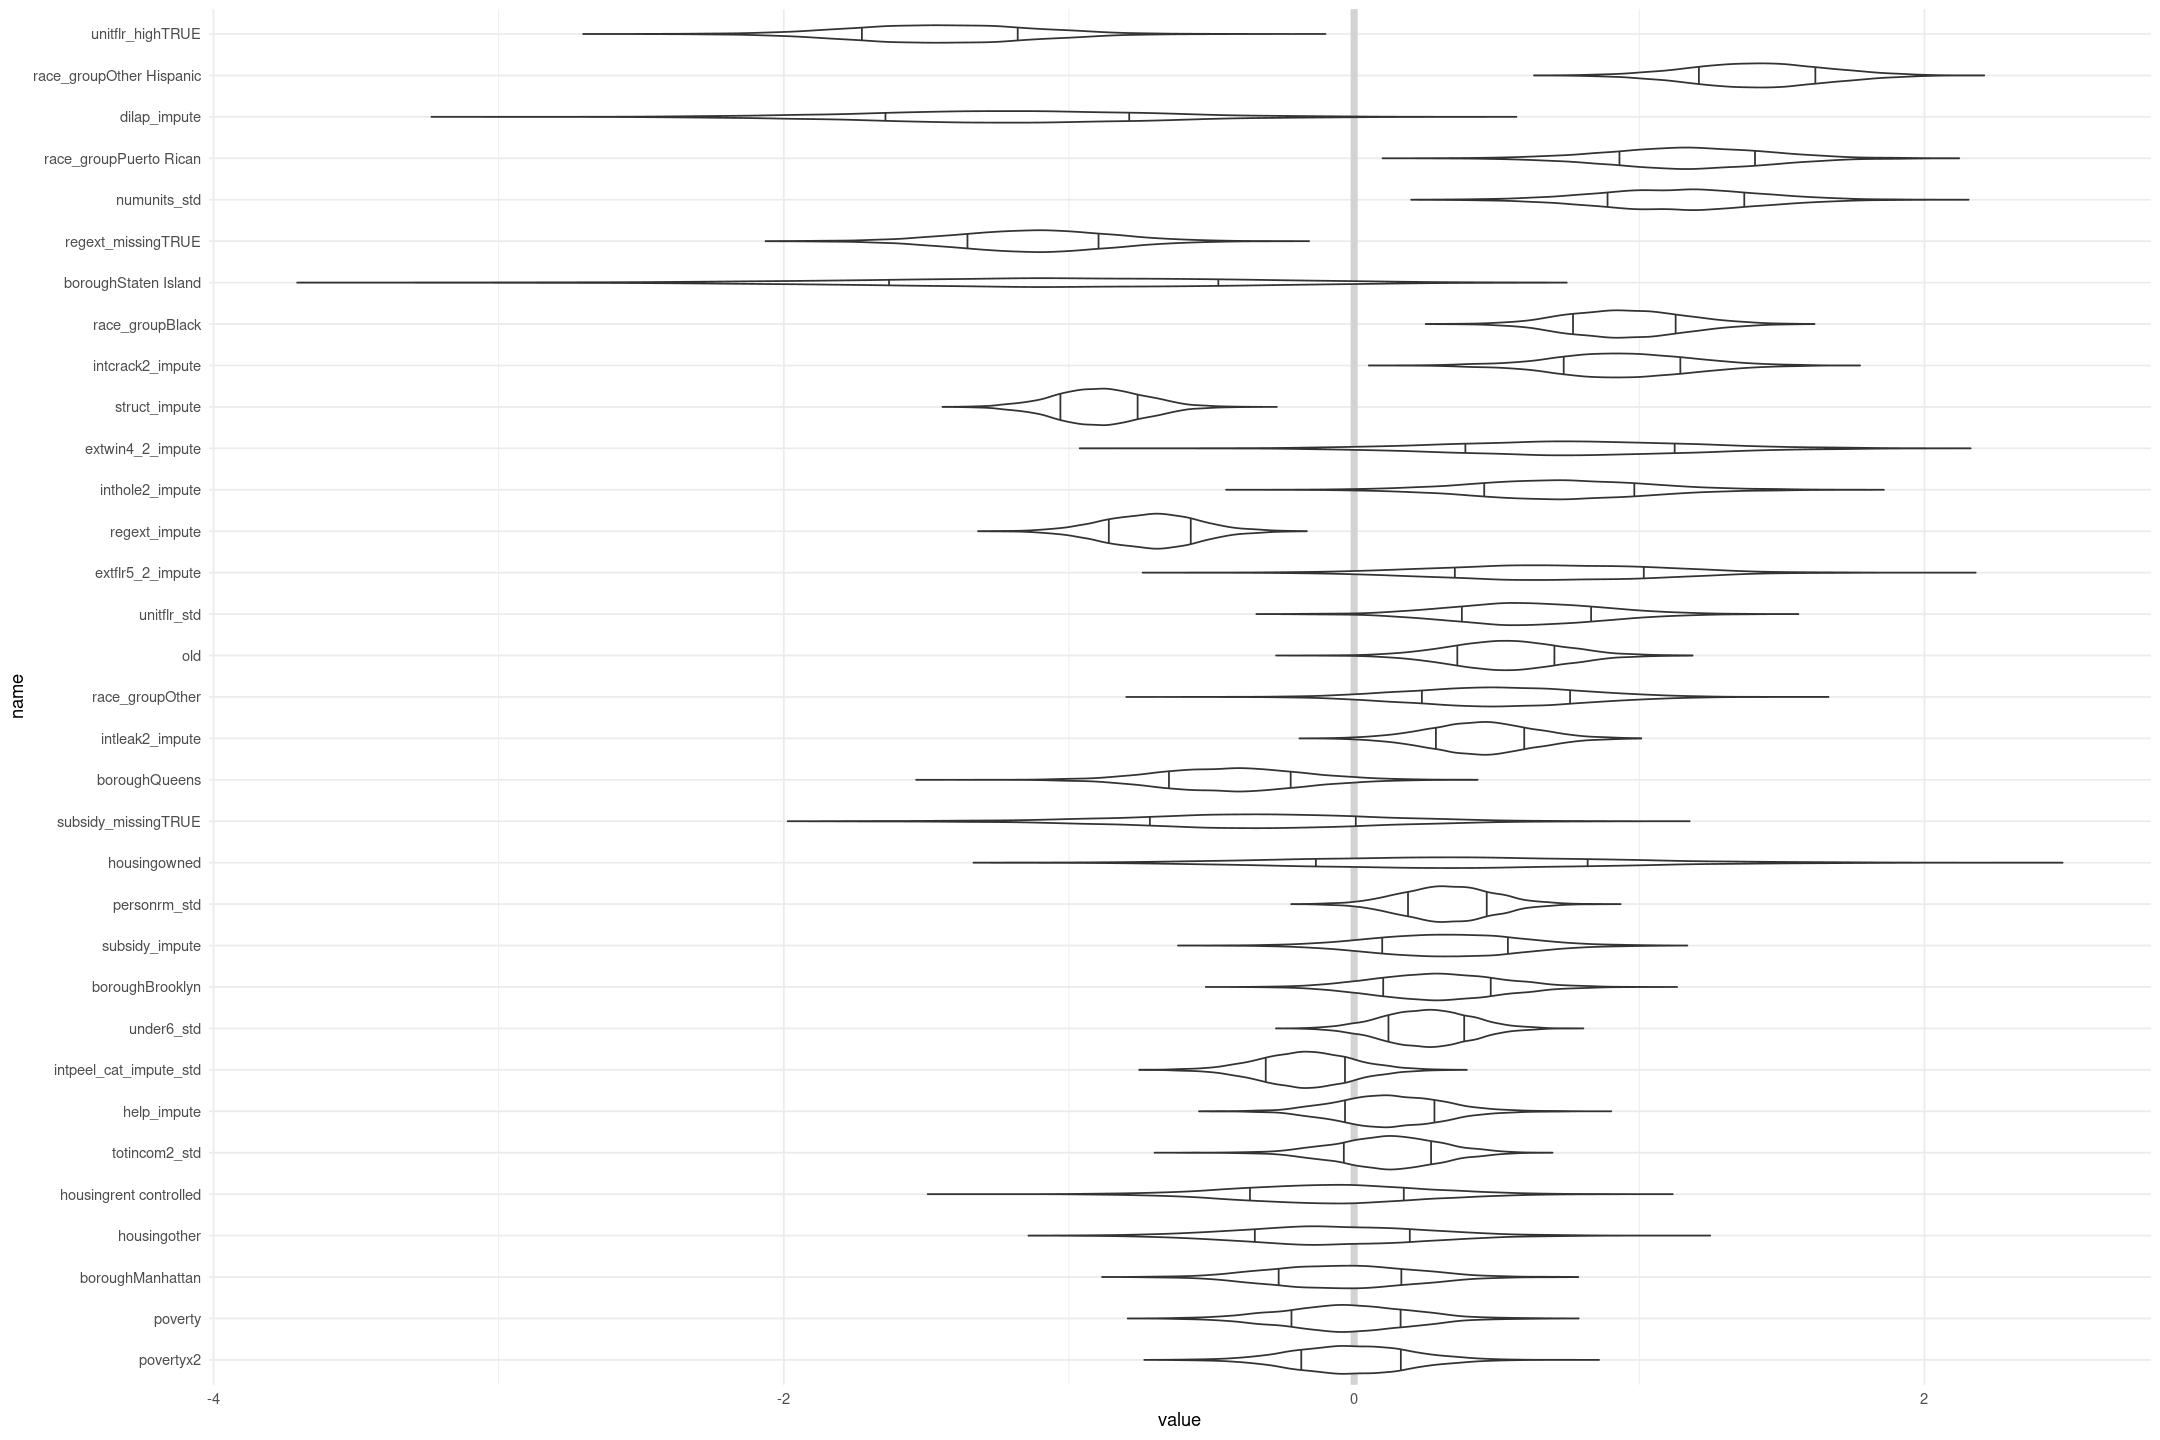

In [178]:
fit_rodent_all %>%
# Convert it to a data frame of coefficients
as.data.frame() %>% 
# Remove the intercept and standard deviation estimates
dplyr::select(-`(Intercept)`) %>% 
# Pivot into long form, one row per variable and estimate
tidyr::pivot_longer(dplyr::everything()) %>% 
# Reorder the variables for plotting in order of descending (median) value
dplyr::mutate(name = forcats::fct_reorder(name, value, .fun=function(v) abs(median(v)))) %>% #
# Draw a violin plot, with 20th and 80th percentiles marked
gf_hline(yintercept=~0, colour="lightgrey", size=2) %>%
ggformula::gf_violin(value ~ name, draw_quantiles=c(0.2, 0.8)) +
# Draw the variables on the vertical axis
ggplot2::coord_flip() +
# Chang the theme
ggplot2::theme_minimal()

### Removing the predictors with small coefficients

Let's make a new model where we drop the factors with relatively little impact.

In [179]:
fit_rodent_subset <- stan_glm(rodent2 ~ 
                           borough + 
                           numunits_std + unitflr_std + unitflr_high +
                           personrm_std + under6_std +
                           subsidy_impute +
                           extwin4_2_impute + extflr5_2_impute + intcrack2_impute + inthole2_impute + intpeel_cat_impute_std + intleak2_impute + regext_impute + regext_missing + struct_impute +  dilap_impute +
                           old + 
                           race_group
                           , 
                           family=binomial(link="logit"), 
                           data=rodents, 
                           refresh=0)

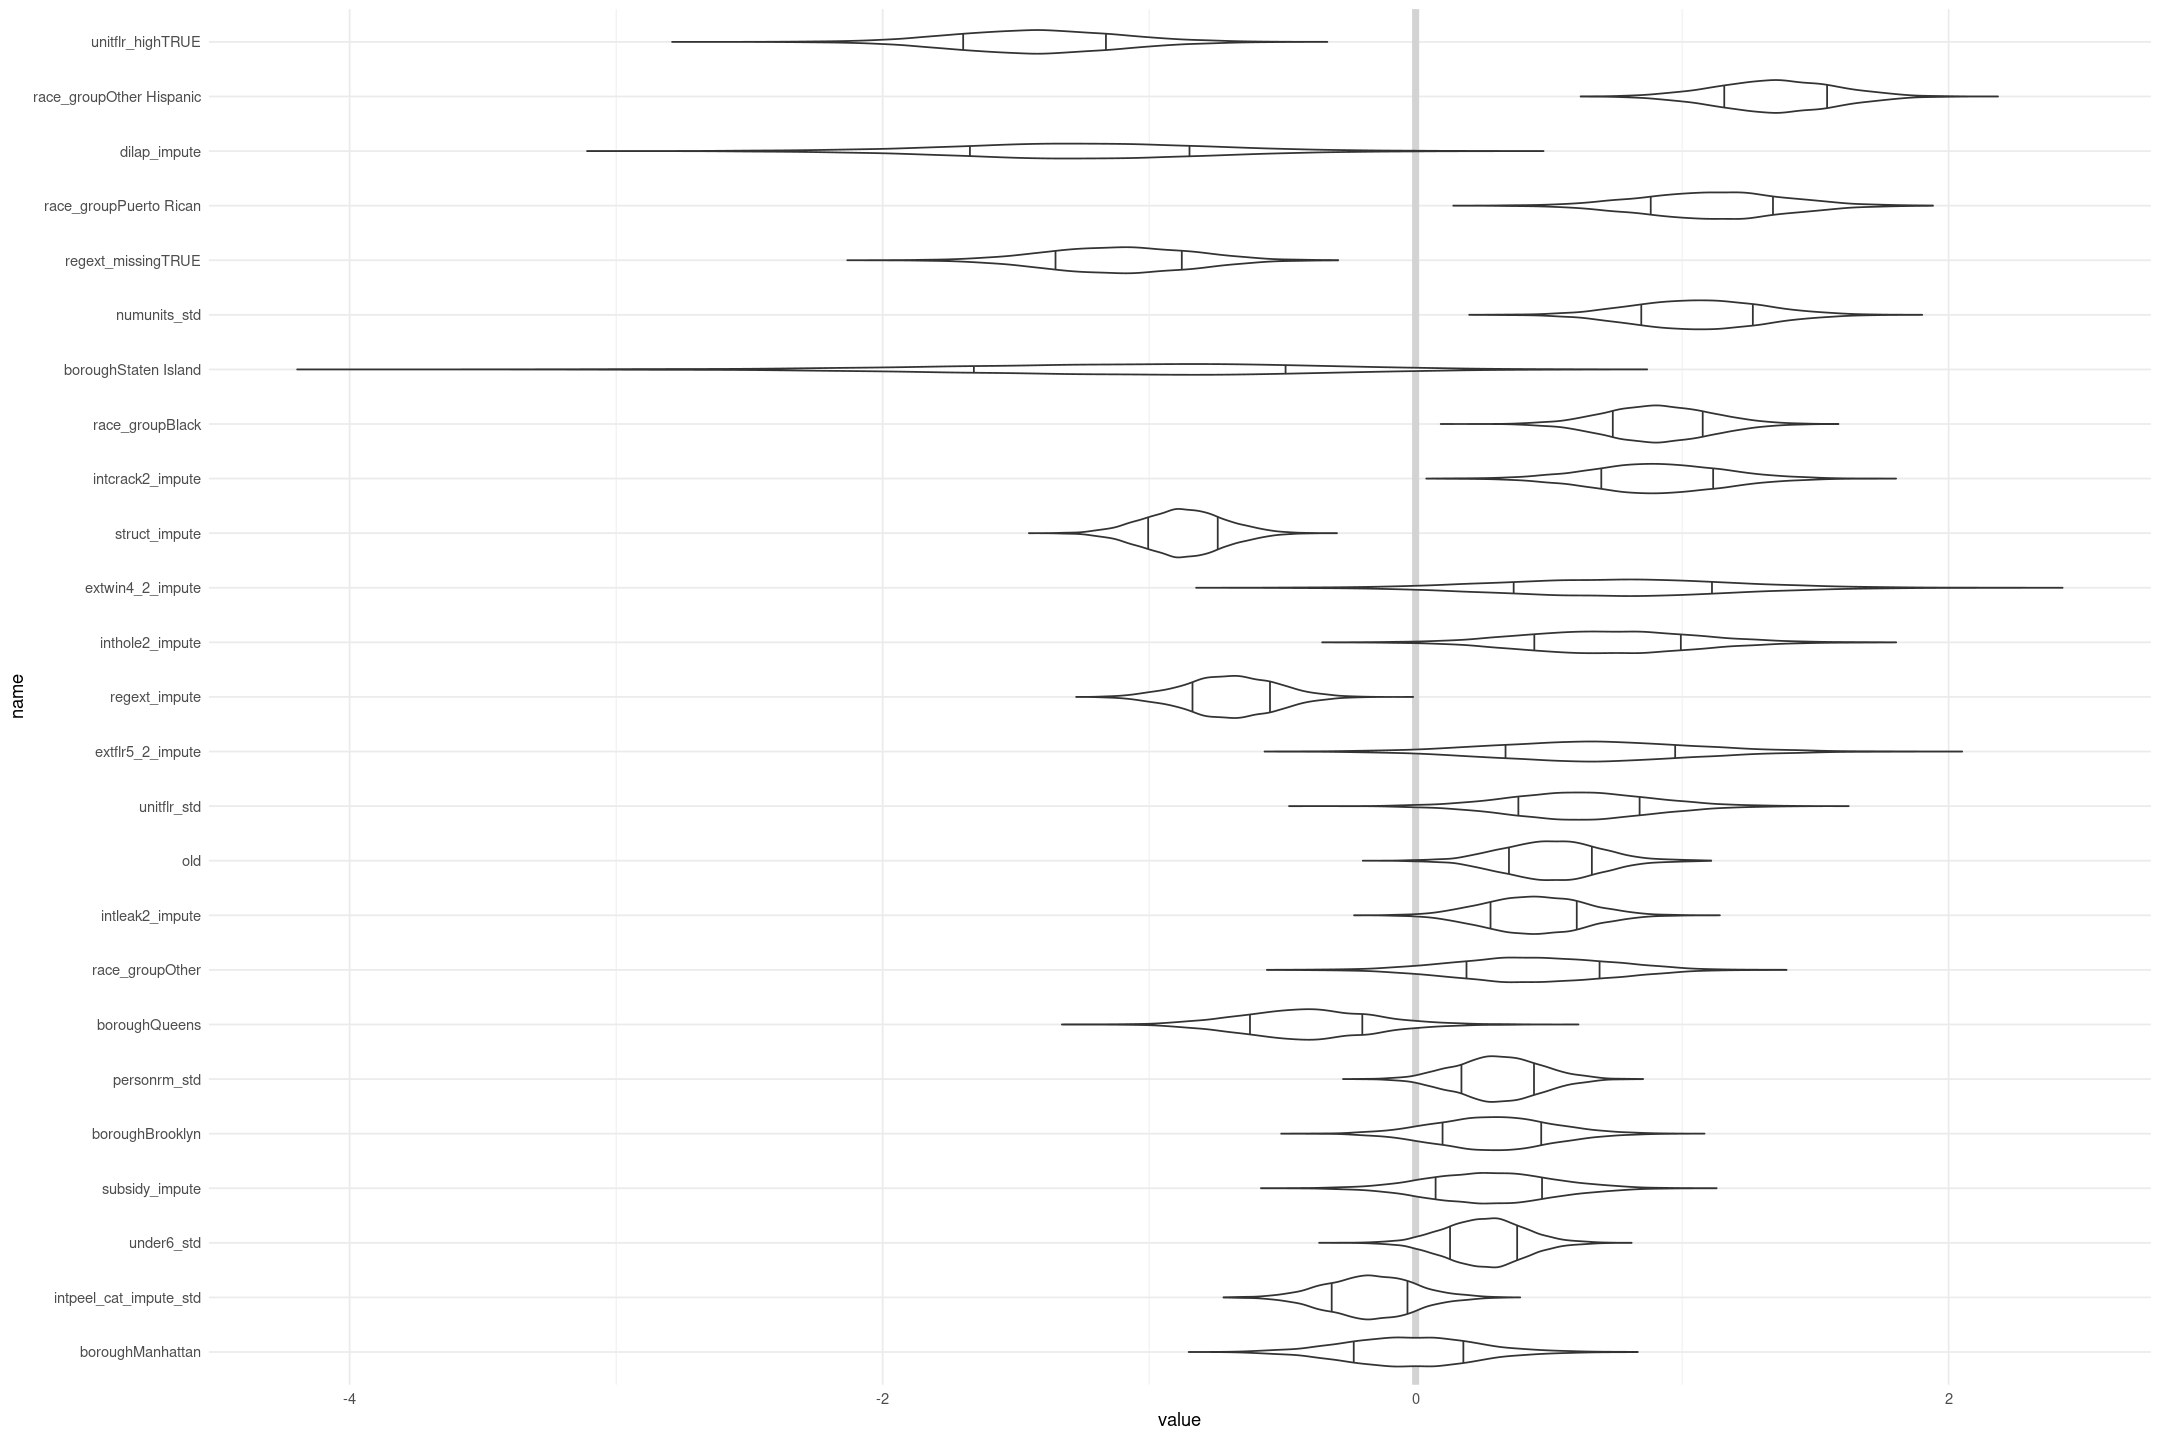

In [180]:
fit_rodent_subset %>%
# Convert it to a data frame of coefficients
as.data.frame() %>% 
# Remove the intercept and standard deviation estimates
dplyr::select(-`(Intercept)`) %>% 
# Pivot into long form, one row per variable and estimate
tidyr::pivot_longer(dplyr::everything()) %>% 
# Reorder the variables for plotting in order of descending (median) value
dplyr::mutate(name = forcats::fct_reorder(name, value, .fun=function(v) abs(median(v)))) %>% #
# Draw a violin plot, with 20th and 80th percentiles marked
gf_hline(yintercept=~0, colour="lightgrey", size=2) %>%
ggformula::gf_violin(value ~ name, draw_quantiles=c(0.2, 0.8)) +
# Draw the variables on the vertical axis
ggplot2::coord_flip() +
# Chang the theme
ggplot2::theme_minimal()

### Adding interactions

In [181]:
rodents <- rodents %>% mutate(black = race_group == "Black",
                   puerto_rican = race_group == "Puerto Rican",
                   other_hispanic = race_group == "Other Hispanic"
                  )
rodents %>% count(race_group, black, puerto_rican, other_hispanic)

race_group     black puerto_rican other_hispanic n  
1 White          FALSE FALSE        FALSE          633
2 Black           TRUE FALSE        FALSE          404
3 Puerto Rican   FALSE  TRUE        FALSE          139
4 Other Hispanic FALSE FALSE         TRUE          223
5 Other          FALSE FALSE        FALSE          152

In [182]:
fit_rodent_interaction <- stan_glm(rodent2 ~ 
                           borough + 
                           numunits_std + unitflr_std + unitflr_high +
                           personrm_std + under6_std +
                           subsidy_impute +
                           extwin4_2_impute + extflr5_2_impute + intcrack2_impute + inthole2_impute + intpeel_cat_impute_std + intleak2_impute + regext_impute + regext_missing + struct_impute +  dilap_impute +
                           old + 
                           race_group + 
                           black : unitflr_high + puerto_rican : unitflr_high + other_hispanic : unitflr_high + 
                           unitflr_high : dilap_impute + black : dilap_impute + puerto_rican : dilap_impute + other_hispanic : dilap_impute +
                           numunits_std:unitflr_high + numunits_std:dilap_impute + numunits_std:black +  numunits_std:puerto_rican + numunits_std:other_hispanic 
                           , 
                           family=binomial(link="logit"), 
                           data=rodents, 
                           refresh=0)

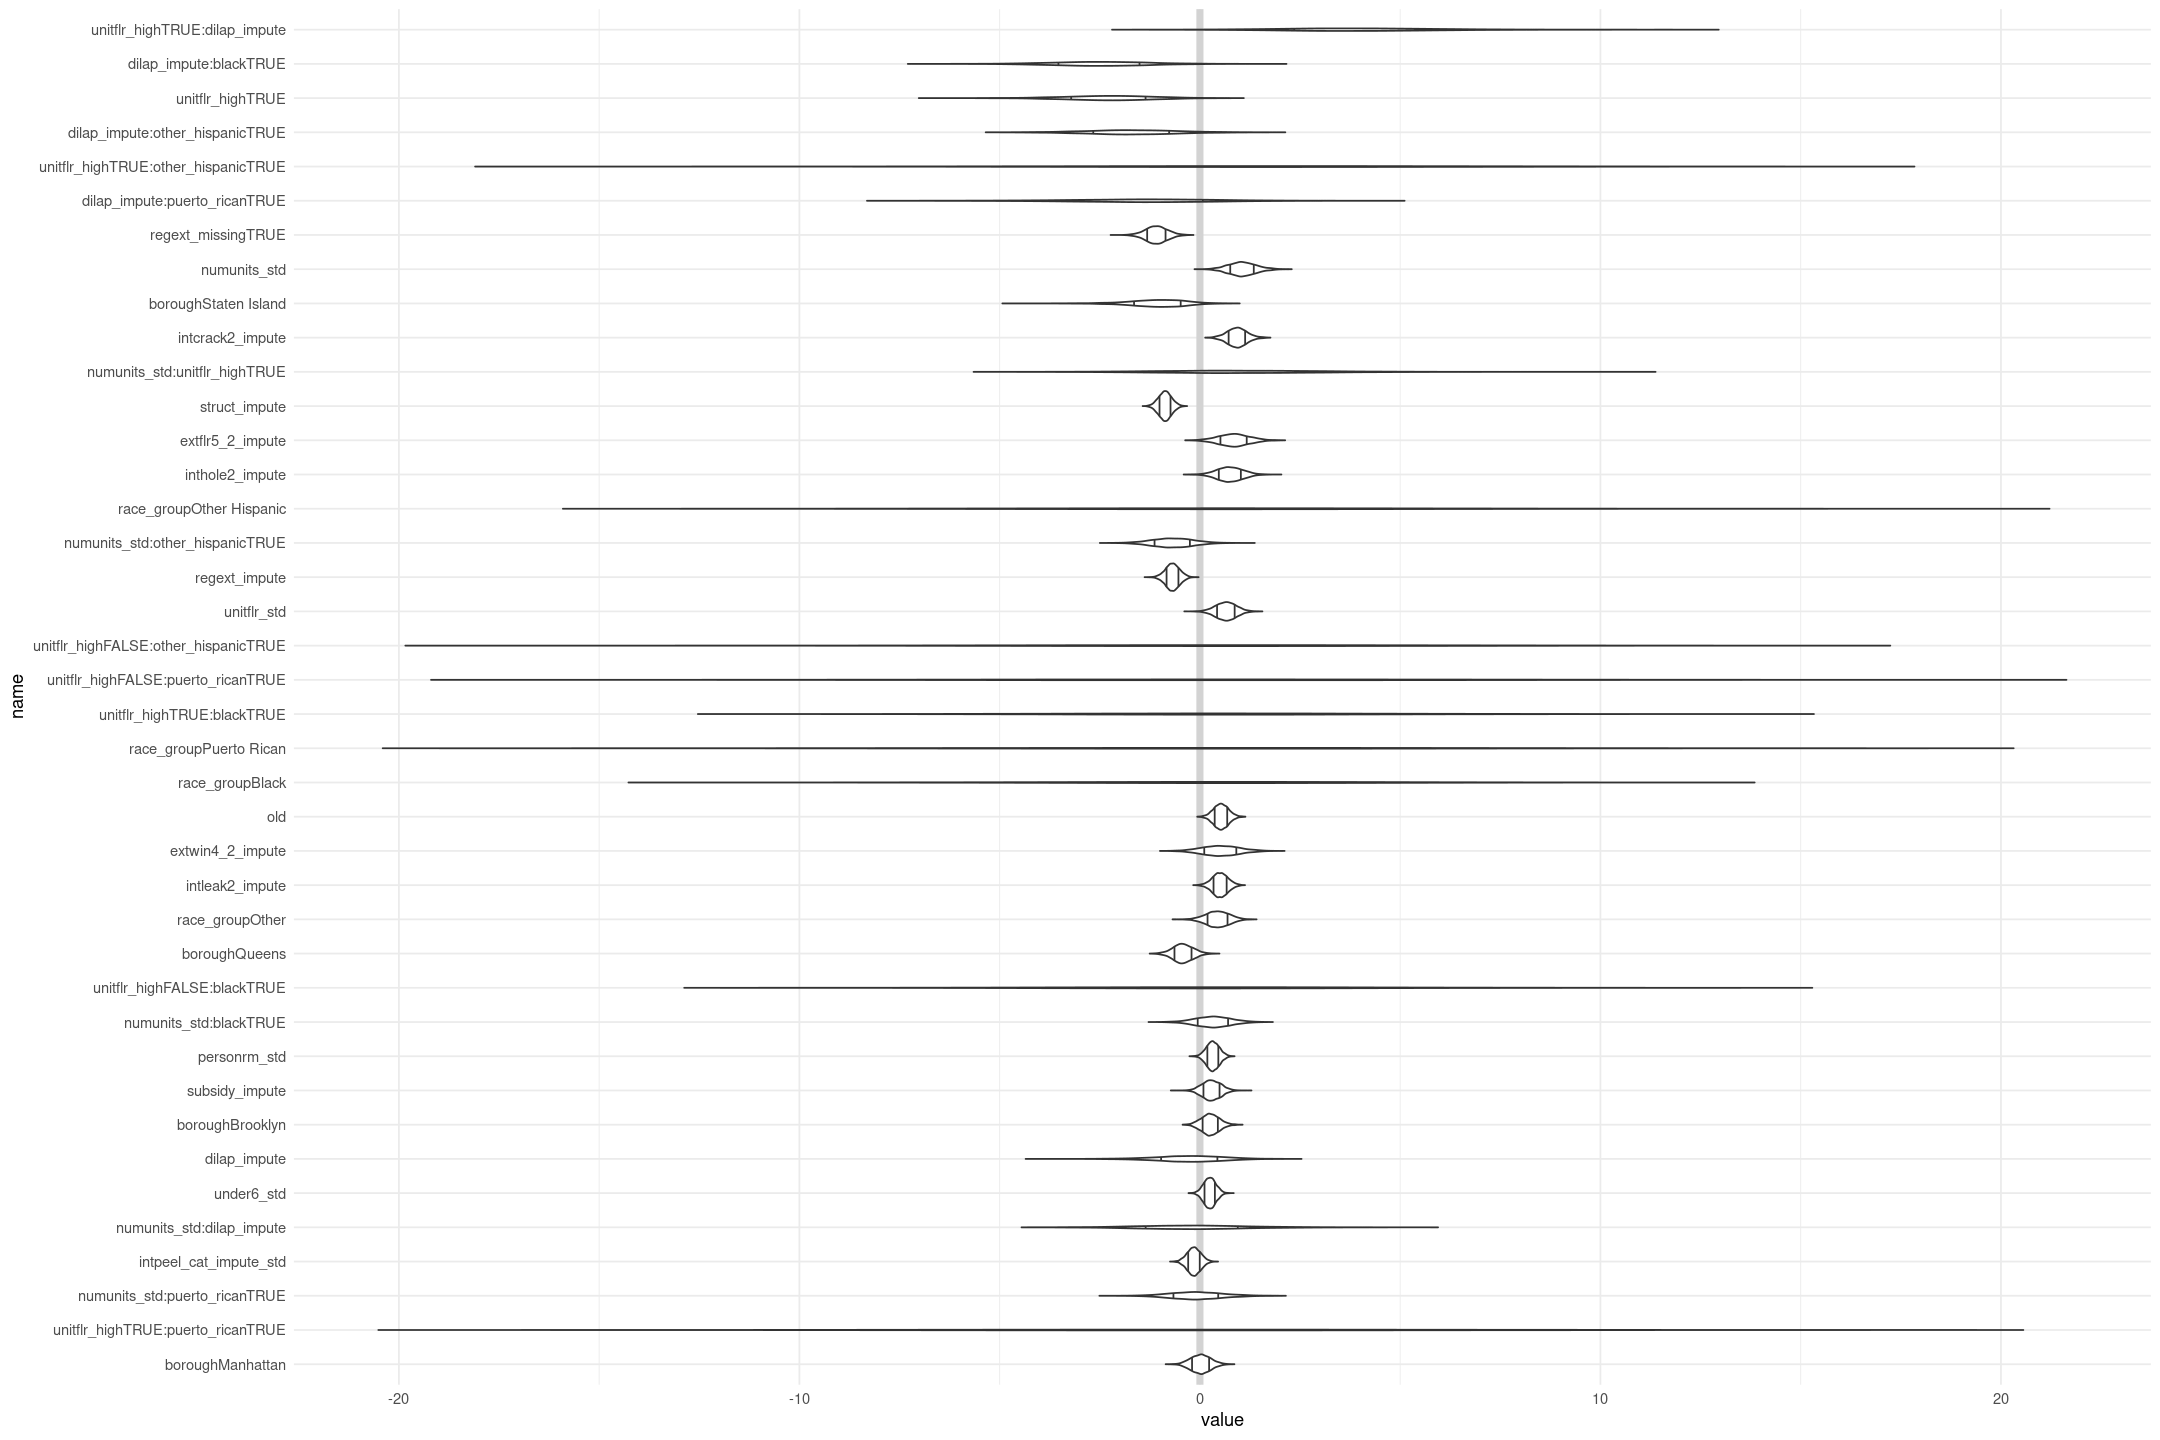

In [183]:
fit_rodent_interaction %>%
# Convert it to a data frame of coefficients
as.data.frame() %>% 
# Remove the intercept and standard deviation estimates
dplyr::select(-`(Intercept)`) %>% 
# Pivot into long form, one row per variable and estimate
tidyr::pivot_longer(dplyr::everything()) %>% 
# Reorder the variables for plotting in order of descending (median) value
dplyr::mutate(name = forcats::fct_reorder(name, value, .fun=function(v) abs(median(v)))) %>% #
# Draw a violin plot, with 20th and 80th percentiles marked
gf_hline(yintercept=~0, colour="lightgrey", size=2) %>%
ggformula::gf_violin(value ~ name, draw_quantiles=c(0.2, 0.8)) +
# Draw the variables on the vertical axis
ggplot2::coord_flip() +
# Chang the theme
ggplot2::theme_minimal()

### Removing interactions with low coefficients

In [184]:
fit_rodent_interaction_subset <- stan_glm(rodent2 ~ 
                           borough + 
                           numunits_std + unitflr_std + unitflr_high +
                           personrm_std + under6_std +
                           subsidy_impute +
                           extwin4_2_impute + extflr5_2_impute + intcrack2_impute + inthole2_impute + intpeel_cat_impute_std + intleak2_impute + regext_impute + regext_missing + struct_impute +  dilap_impute +
                           old + 
                           race_group + 
                           unitflr_high : dilap_impute + black : dilap_impute + puerto_rican : dilap_impute + other_hispanic : dilap_impute
                           , 
                           family=binomial(link="logit"), 
                           data=rodents, 
                           refresh=0)

In [185]:
fit_rodent_interaction_subset

stan_glm
 family:       binomial [logit]
 formula:      rodent2 ~ borough + numunits_std + unitflr_std + unitflr_high + 
	   personrm_std + under6_std + subsidy_impute + extwin4_2_impute + 
	   extflr5_2_impute + intcrack2_impute + inthole2_impute + intpeel_cat_impute_std + 
	   intleak2_impute + regext_impute + regext_missing + struct_impute + 
	   dilap_impute + old + race_group + unitflr_high:dilap_impute + 
	   black:dilap_impute + puerto_rican:dilap_impute + other_hispanic:dilap_impute
 observations: 1551
 predictors:   30
------
                                Median MAD_SD
(Intercept)                     -1.5    0.3  
boroughBrooklyn                  0.3    0.2  
boroughManhattan                 0.0    0.2  
boroughQueens                   -0.4    0.2  
boroughStaten Island            -1.0    0.7  
numunits_std                     1.0    0.2  
unitflr_std                      0.6    0.3  
unitflr_highTRUE                -1.5    0.3  
personrm_std                     0.3    0.2  

### Comparing models

Let's check we haven't overfit too much with LOO

In [186]:
loo_rodent_race <- loo(fit_rodent_race)
loo_rodent_all <- loo(fit_rodent_all)

In [187]:
loo_rodent_subset <- loo(fit_rodent_subset)

In [188]:
loo_rodent_interaction <- loo(fit_rodent_interaction, k_threshold=0.7)

2 problematic observation(s) found.
Model will be refit 2 times.


Fitting model 1 out of 2 (leaving out observation 22)


Fitting model 2 out of 2 (leaving out observation 84)



In [189]:
loo_rodent_interaction_subset <- loo(fit_rodent_interaction_subset, k_threshold=0.7)

3 problematic observation(s) found.
Model will be refit 3 times.


Fitting model 1 out of 3 (leaving out observation 22)


Fitting model 2 out of 3 (leaving out observation 80)


Fitting model 3 out of 3 (leaving out observation 84)



It looks like the interactions haven't improved the model, so our best model is the subset model (which is much improved over race).

In [190]:
loo_compare(loo_rodent_race, loo_rodent_all, loo_rodent_subset, loo_rodent_interaction, loo_rodent_interaction_subset)

elpd_diff   se_diff   elpd_loo  se_elpd_loo
fit_rodent_subset                0.000000  0.000000 -656.0450 23.62063   
fit_rodent_interaction_subset   -5.549655  6.216764 -661.5947 24.37799   
fit_rodent_all                  -7.498587  1.602119 -663.5436 23.94006   
fit_rodent_interaction         -10.844989  6.874397 -666.8900 24.79737   
fit_rodent_race               -123.469712 16.895461 -779.5148 20.84960   
                              p_loo     se_p_loo  looic    se_looic
fit_rodent_subset             27.920400 1.4877003 1312.090 47.24126
fit_rodent_interaction_subset 37.483035 5.2638103 1323.189 48.75597
fit_rodent_all                36.563044 1.8437372 1327.087 47.88011
fit_rodent_interaction        44.994710 5.5158349 1333.780 49.59474
fit_rodent_race                5.031269 0.1921058 1559.030 41.69921

### Effect of race

In [191]:
fit_rodent_race

stan_glm
 family:       binomial [logit]
 formula:      rodent2 ~ race_group
 observations: 1551
 predictors:   5
------
                         Median MAD_SD
(Intercept)              -2.2    0.1  
race_groupBlack           1.4    0.2  
race_groupPuerto Rican    1.7    0.2  
race_groupOther Hispanic  2.0    0.2  
race_groupOther           0.8    0.3  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

The effect of race has reduced somewhat when adjusting for these other factors, but they are still strong predictors.

An interesting next step would be to look at neighbourhood level features.

In [192]:
fit_rodent_subset

stan_glm
 family:       binomial [logit]
 formula:      rodent2 ~ borough + numunits_std + unitflr_std + unitflr_high + 
	   personrm_std + under6_std + subsidy_impute + extwin4_2_impute + 
	   extflr5_2_impute + intcrack2_impute + inthole2_impute + intpeel_cat_impute_std + 
	   intleak2_impute + regext_impute + regext_missing + struct_impute + 
	   dilap_impute + old + race_group
 observations: 1551
 predictors:   26
------
                         Median MAD_SD
(Intercept)              -1.4    0.3  
boroughBrooklyn           0.3    0.2  
boroughManhattan          0.0    0.2  
boroughQueens            -0.4    0.2  
boroughStaten Island     -1.0    0.7  
numunits_std              1.1    0.2  
unitflr_std               0.6    0.3  
unitflr_highTRUE         -1.4    0.3  
personrm_std              0.3    0.2  
under6_std                0.3    0.1  
subsidy_impute            0.3    0.2  
extwin4_2_impute          0.8    0.4  
extflr5_2_impute          0.7    0.4  
intcrack2_impute         

# Fake-data simulation to evaluate a statistical procedure

When can we get away with fitting linear regression to binary data?
You will explore this question by simulating data from a logistic regression, then fitting a lienar regression, then looping this procedure to compute the coverage of the estimates.

## Simulation

You will be simulating indepentent binary data, $y_i, i=1,\ldots,n$, from the model, ${\rm Pr}(y_i = 1) = {\rm logit}^{-1}(a + bx_i + \theta z_i$), where the $x_i$'s are drawn uniformly from the range (0, 100) and the $z_i$'s are randomly set to 0 or 1.
The "cover story" here is that $y$ represents passing or failing an exam, $x$ is the score on a pre-test, and $z$ is a treatment.

To do this simulation, you will need to set true values of $a$, $b$, and $\theta$. Choose $a$ and $b$ so that 60% of the students in the control group will pass the exam, with the probability of passing being 80% for students in the control group who scored 100 on the midterm.

Choose $\theta$ so that the average probability of passing increases by 10 percentage points under the treatment.

Report your values fo $a, b, \theta$ and explain your reasoning (including simulation code).
It's not enough just to guess.

$x_i \in {\rm Unif}(0, 100), z_i \in {\rm Binom}(1)$

We want $a$ and $b$ so that 60% of the students in the control group will pass the exam, and 80% pass rate for the control group who scored 100 on the midterm.

A naive way to approach this is to say if we want the average rate to be 60%, given the scores are uniformly distributed between 0 and 100, and the top probability is 80%, we would guess the bottom probability should around 40%.
The logit function isn't linear or symmetric around 60%, and so the actual answer would be a little bit below this.

Our initial estimate based on this is $ a = {\rm logit}(0.4) \approx -0.4 $ and $ a + 100 b = {\rm logit}(0.8) \approx 1.4 $ and so $ b \approx 0.018 $.

We can calculate this exactly.
The expected percentage of students in the control group who will pass the exam is $ \int_0^{100} \frac{{\rm d}x}{100} {\rm logit}^{-1}(a + bx) $

Now the antiderivative of $ {\rm logit}^{-1}(x) = \frac{e^x}{1 + e^x}$ is $ \ln(1+e^x)$.

So the expected percentage of students in the control group who will pass is $ \left.\frac{1}{100 b} \ln(1 + \exp(a+bx)) \right]_{x=0}^{100}$, which is $ \frac{1}{100 b} \ln\left(\frac{1+\exp(a+100b)}{1+\exp(a)}\right) = p$, where $p$ is 0.6..

Rearranging this gives $$ a = \log\left(\frac{e^{100 b p} - 1}{e^{100 b} - e^{100 b p}}\right) $$.


The probability of passing is 80% for students who scored 100 in the midterm, so ${\rm logit}^{-1}(a + 100b) = q $, where q = 0.8.
Rearranging $$ e^{a} e^{100b} = \frac{q}{1-q} $$

Putting these two equations together gives us a transcendental relation for $b$:

$$ \frac{e^{100bp} - 1}{1 - e^{100b(p-1)}} = \frac{q}{1-q} $$

Starting with our estimate of b above, by setting the probability at a pre-test score of 0 to 40% gives

In [193]:
b <- 0.018
p <- 0.6
q <- 0.8

b_constraint <- function(b) (exp(100*b*p) - 1)/(1-exp(100*b*(p-1))) - q/(1-q)

In [194]:
b_constraint(b)

[1] -0.2110315

If we set the probability with a pretest score of 0 to, say 30%, then we'd probably get the average probability under 60%.
Then we would have:

In [195]:
(b_min <- (logit(0.8) - logit(0.3))/100)

[1] 0.02233592

In [196]:
b_constraint(b_min)

[1] 0.7729522

We can then find the root by bisection

In [197]:
(b_root <- uniroot(b_constraint, c(b_min, b)))

$root
[1] 0.01902303

$f.root
[1] 6.637045e-05

$iter
[1] 2

$init.it
[1] NA

$estim.prec
[1] 9.312191e-05

In [198]:
b <- b_root$root
(a <- log((exp(100*b*p) - 1)/(exp(100*b) - exp(100*b*p))))

[1] -0.5159922

Checking the prediction at a score of 100 is 80%

In [199]:
invlogit(a + 100 * b)

[1] 0.8000027

And the average score is around 60%

In [200]:
x <- runif(1000, 0, 100)
mean(invlogit(a+x*b))

[1] 0.6031705

Finally we need $\theta$ such that the average probability of passing increases by 10 percentage points under the treatment.

Using the divide-by-four rule a first estimate for $\theta$ is 0.4 (so a quarter of this is 1). Since this is the *maximum* effect the actual number should be a little higher than this.

To calculate it precisely we can adapt our previous expression to involve the treatment
$ \frac{1}{100 b} \ln\left(\frac{1+\exp(a+100b + \theta)}{1+\exp(a + \theta)}\right) = p'$ where $p'=0.6+0.1=0.7$

Again solving this gives $$ a + \theta = \log\left(\frac{e^{100 b p'} - 1}{e^{100 b} - e^{100 b p'}}\right) $$

In [201]:
pp <- 0.7

(theta <- log((exp(100*b*pp) - 1)/(exp(100*b) - exp(100*b*pp))) - a)

[1] 0.4714258

Checking the mean score is 70

In [202]:
mean(invlogit(a+x*b+theta))

[1] 0.702866

## Fitting a linear regression

Simulate $n=50$ data points from you model, and then fit a linear regression of $y$ on $x$ and $z$.
Look at the estimate and standard error for the coefficient of $z$.
Does the true average treatment effect fall inside this interval?

In [203]:
n <- 50

fake_data <- data.frame(pretest=runif(n,0,100), treatment=rbinom(n,1,0.5)) %>%
mutate(pass=rbinom(n, 1, invlogit(a + b*pretest + theta * treatment)))

fake_data %>% t()

[,1]     [,2]     [,3]     [,4]     [,5]     [,6]     [,7]    
pretest   36.08977 2.051403 78.78814 93.83439 22.67074 89.03832 55.17705
treatment  0.00000 1.000000  0.00000  1.00000  0.00000  0.00000  0.00000
pass       0.00000 1.000000  1.00000  1.00000  1.00000  1.00000  0.00000
          [,8]     [,9]     [,10]    [,11]    [,12]    [,13]    [,14]   
pretest   19.88733 37.53327 75.64587 22.58662 43.00067 58.64641 39.46285
treatment  0.00000  1.00000  1.00000  1.00000  0.00000  1.00000  1.00000
pass       0.00000  1.00000  1.00000  0.00000  0.00000  1.00000  0.00000
          [,15]    [,16]    [,17]    [,18]    [,19]    [,20]    [,21]   
pretest   28.13235 66.37819 44.06167 81.52764 72.92181 59.79213 62.13691
treatment  0.00000  1.00000  0.00000  1.00000  0.00000  1.00000  1.00000
pass       1.00000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000
          [,22]    [,23]    [,24]    [,25]   [,26]    [,27]    [,28]   
pretest   29.21389 68.04451 29.33885 30.7197 50.32602 17.98171 72.82727
treatment  1.00000  1.00000  1.00000  0.0000  1.00000  0.00000  0.00000
pass       1.00000  1.00000  1.00000  1.0000  0.00000  0.00000  0.00000
          [,29]    [,30]   [,31]    [,32]    [,33]   [,34]    [,35]   [,36]   
pretest   97.20026 6.49682 99.22168 22.22856 62.7702 99.28506 95.1748 7.646733
treatment  1.00000 1.00000  1.00000  0.00000  1.0000  1.00000  1.0000 1.000000
pass       0.00000 0.00000  1.00000  1.00000  1.0000  1.00000  1.0000 1.000000
          [,37]    [,38]    [,39]    [,40]    [,41]    [,42]    [,43]   
pretest   50.68438 24.78824 27.62453 48.57942 76.92116 9.719434 83.45578
treatment  1.00000  0.00000  1.00000  1.00000  1.00000 0.000000  0.00000
pass       0.00000  1.00000  1.00000  0.00000  1.00000 0.000000  1.00000
          [,44]     [,45]    [,46]    [,47]    [,48]    [,49]    [,50]   
pretest   0.2362172 91.65812 82.40582 1.361237 33.24099 96.89049 49.71422
treatment 0.0000000  0.00000  1.00000 0.000000  1.00000  1.00000  0.00000
pass      0.0000000  1.00000  1.00000 0.000000  1.00000  1.00000  1.00000

The true treatment value is in this range, but the range is large

In [204]:
linear_model <- stan_glm(pass ~ pretest + treatment, data=fake_data, refresh=0)

print(linear_model, digits=2)

stan_glm
 family:       gaussian [identity]
 formula:      pass ~ pretest + treatment
 observations: 50
 predictors:   3
------
            Median MAD_SD
(Intercept) 0.36   0.13  
pretest     0.01   0.00  
treatment   0.12   0.13  

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.45   0.05  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


## Coverage

Repeat you simulation 10&thinsp;000 times.
Compute the coverage of the normal-theory 50% and 95% intervals (that is, the estimates of ±0.67 and 1.96 standard errors).

In [205]:
linear_tretment_estimate <- function() {
    n <- 50
    fake_data <- data.frame(pretest=runif(n,0,100), treatment=rbinom(n,1,0.5)) %>%
        mutate(pass=rbinom(n, 1, invlogit(a + b*pretest + theta * treatment)))
    
    linear_model <- lm(pass ~ pretest + treatment, data=fake_data)
    coef(linear_model)[['treatment']]
}

In [206]:
linear_estimates <- replicate(10000, linear_tretment_estimate())

In [207]:
mu <- mean(linear_estimates)
se <- sd(linear_estimates)

The 50% coverage interval contains the correct value, but it's very wide.

In [208]:
c(mu - 0.67 * se, mu+0.67 * se)

[1] 0.01074177 0.18968433

The 95% coverage interval does contain the value, but it is very very wide.

In [209]:
c(mu - 1.96 * se, mu+ 1.96 * se)

[1] -0.1615238  0.3619499

### What does it look like for binomial models?

Roughly let's use the divide by 4 rule (we could use something like an average comparison alternatively)

In [210]:
binomial_tretment_estimate <- function() {
    n <- 50
    fake_data <- data.frame(pretest=runif(n,0,100), treatment=rbinom(n,1,0.5)) %>%
        mutate(pass=rbinom(n, 1, invlogit(a + b*pretest + theta * treatment)))
    
    linear_model <- glm(pass ~ pretest + treatment, family=binomial(link="logit"), data=fake_data)
    coef(linear_model)[['treatment']] / 4
}

In [211]:
binomial_estimates <- replicate(10000, binomial_tretment_estimate())

In [212]:
mu <- mean(binomial_estimates)
se <- sd(binomial_estimates)

The intervals are reasonably similar - the linear model works alright here where we do not have values too close to 0 or 100% and not enough data to more precisely estimate the coefficients.

In [213]:
c(mu - 0.67 * se, mu+0.67 * se)

[1] 0.0060946 0.2495089

In [214]:
c(mu - 1.96 * se, mu+ 1.96 * se)

[1] -0.2282371  0.4838406